##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 加载 pandas DataFrame

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/load_data/pandas_dataframe"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">View on TensorFlow.org</a> </td>
  <td>     在 Google Colab 中运行   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/pandas_dataframe.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/load_data/pandas_dataframe.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

本教程提供了将 <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html" class="external">pandas DataFrame</a> 加载到 TensorFlow 中的示例。

本教程使用了一个小型[数据集](https://archive.ics.uci.edu/ml/datasets/heart+Disease)，由克利夫兰诊所心脏病基金会（Cleveland Clinic Foundation for Heart Disease）提供. 此数据集中有几百行CSV。每行表示一个患者，每列表示一个属性（describe）。我们将使用这些信息来预测患者是否患有心脏病，这是一个二分类问题。

## 使用 pandas 读取数据

In [2]:
import pandas as pd
import tensorflow as tf

SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

2023-11-07 23:52:53.061374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 23:52:53.061428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 23:52:53.063212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


下载包含心脏病数据集的 CSV 文件：

In [3]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

 8192/13273 [=================>............] - ETA: 0s

13273/13273 [==============================] - 0s 0us/step


使用 pandas 读取 CSV 文件：

In [4]:
df = pd.read_csv(csv_file)

数据如下：

In [5]:
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0

In [6]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

您将构建模型来预测 `target` 列中包含的标签。

In [7]:
target = df.pop('target')

## 创建并训练模型

如果您的数据具有统一的数据类型或 `dtype`，则可在任何可以使用 NumPy 数组的地方使用 pandas DataFrame。这是因为 `pandas.DataFrame` 类支持 `__array__` 协议，并且 TensorFlow 的 `tf.convert_to_tensor` 函数接受支持该协议的对象。

从数据集中获取数值特征（暂时跳过分类特征）：

In [8]:
numeric_feature_names = ['age', 'thalach', 'trestbps',  'chol', 'oldpeak']
numeric_features = df[numeric_feature_names]
numeric_features.head()

age  thalach  trestbps  chol  oldpeak
0   63      150       145   233      2.3
1   67      108       160   286      1.5
2   67      129       120   229      2.6
3   37      187       130   250      3.5
4   41      172       130   204      1.4

可以使用 `DataFrame.values` 属性或 `numpy.array(df)` 将 DataFrame 转换为 NumPy 数组。要将其转换为张量，请使用 `tf.convert_to_tensor`：

In [9]:
tf.convert_to_tensor(numeric_features)

<tf.Tensor: shape=(303, 5), dtype=float64, numpy=
array([[ 63. , 150. , 145. , 233. ,   2.3],
       [ 67. , 108. , 160. , 286. ,   1.5],
       [ 67. , 129. , 120. , 229. ,   2.6],
       ...,
       [ 65. , 127. , 135. , 254. ,   2.8],
       [ 48. , 150. , 130. , 256. ,   0. ],
       [ 63. , 154. , 150. , 407. ,   4. ]])>

通常，如果一个对象可以使用 `tf.convert_to_tensor` 转换为张量，则可以在任何可以传递 `tf.Tensor` 的位置传递该对象。

### 使用 Model.fit

解释为单个张量的 DataFrame，可以直接用作 `Model.fit` 方法的参数。

下面是使用数据集的数值特征训练模型的示例。

第一步是归一化输入范围。为此，请使用 `tf.keras.layers.Normalization` 层。

要在运行之前设置层的均值和标准差，请务必调用 `Normalization.adapt` 方法：

In [10]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)

调用 DataFrame 前三行的层，以呈现此层的输出的样本：

In [11]:
normalizer(numeric_features.iloc[:3])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.93383914,  0.03480718,  0.74578077, -0.26008663,  1.0680453 ],
       [ 1.3782105 , -1.7806165 ,  1.5923285 ,  0.7573877 ,  0.38022864],
       [ 1.3782105 , -0.87290466, -0.6651321 , -0.33687714,  1.3259765 ]],
      dtype=float32)>

使用归一化层作为简单模型的第一层：

In [12]:
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

当您将 DataFrame 作为 `x` 参数传递给 `Model.fit` 时，Keras 会将 DataFrame 视为 NumPy 数组：

In [13]:
model = get_basic_model()
model.fit(numeric_features, target, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15


I0000 00:00:1699401180.163111  580456 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/152 [..............................] - ETA: 4:47 - loss: 0.6215 - accuracy: 0.5000

 17/152 [==>...........................] - ETA: 0s - loss: 0.7375 - accuracy: 0.6176  

 34/152 [=====>........................] - ETA: 0s - loss: 0.6862 - accuracy: 0.6912

 51/152 [=========>....................] - ETA: 0s - loss: 0.6741 - accuracy: 0.6961

 68/152 [============>.................] - ETA: 0s - loss: 0.6560 - accuracy: 0.7132

 85/152 [===============>..............] - ETA: 0s - loss: 0.6397 - accuracy: 0.7353

102/152 [===================>..........] - ETA: 0s - loss: 0.6262 - accuracy: 0.7451

119/152 [======================>.......] - ETA: 0s - loss: 0.6116 - accuracy: 0.7521

136/152 [=========================>....] - ETA: 0s - loss: 0.6012 - accuracy: 0.7463

152/152 [==============================] - ETA: 0s - loss: 0.5858 - accuracy: 0.7558

152/152 [==============================] - 2s 3ms/step - loss: 0.5858 - accuracy: 0.7558


Epoch 2/15


  1/152 [..............................] - ETA: 0s - loss: 0.4568 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.4744 - accuracy: 0.7778

 35/152 [=====>........................] - ETA: 0s - loss: 0.5068 - accuracy: 0.7571

 52/152 [=========>....................] - ETA: 0s - loss: 0.4719 - accuracy: 0.7788

 68/152 [============>.................] - ETA: 0s - loss: 0.4891 - accuracy: 0.7500

 85/152 [===============>..............] - ETA: 0s - loss: 0.4931 - accuracy: 0.7412

102/152 [===================>..........] - ETA: 0s - loss: 0.4808 - accuracy: 0.7549

119/152 [======================>.......] - ETA: 0s - loss: 0.4803 - accuracy: 0.7521

136/152 [=========================>....] - ETA: 0s - loss: 0.4667 - accuracy: 0.7647

152/152 [==============================] - 0s 3ms/step - loss: 0.4783 - accuracy: 0.7591


Epoch 3/15


  1/152 [..............................] - ETA: 0s - loss: 0.7948 - accuracy: 0.0000e+00

 18/152 [==>...........................] - ETA: 0s - loss: 0.4580 - accuracy: 0.7500    

 35/152 [=====>........................] - ETA: 0s - loss: 0.4634 - accuracy: 0.7571

 52/152 [=========>....................] - ETA: 0s - loss: 0.4503 - accuracy: 0.7692

 69/152 [============>.................] - ETA: 0s - loss: 0.4548 - accuracy: 0.7681

 86/152 [===============>..............] - ETA: 0s - loss: 0.4737 - accuracy: 0.7500

103/152 [===================>..........] - ETA: 0s - loss: 0.4738 - accuracy: 0.7524

120/152 [======================>.......] - ETA: 0s - loss: 0.4647 - accuracy: 0.7667

137/152 [==========================>...] - ETA: 0s - loss: 0.4544 - accuracy: 0.7701

152/152 [==============================] - 0s 3ms/step - loss: 0.4547 - accuracy: 0.7690


Epoch 4/15


  1/152 [..............................] - ETA: 0s - loss: 0.3159 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.4660 - accuracy: 0.8056

 35/152 [=====>........................] - ETA: 0s - loss: 0.4352 - accuracy: 0.8000

 52/152 [=========>....................] - ETA: 0s - loss: 0.4297 - accuracy: 0.7885

 69/152 [============>.................] - ETA: 0s - loss: 0.4361 - accuracy: 0.7754

 86/152 [===============>..............] - ETA: 0s - loss: 0.4405 - accuracy: 0.7674

103/152 [===================>..........] - ETA: 0s - loss: 0.4520 - accuracy: 0.7670

119/152 [======================>.......] - ETA: 0s - loss: 0.4477 - accuracy: 0.7731

135/152 [=========================>....] - ETA: 0s - loss: 0.4437 - accuracy: 0.7704

152/152 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.7723

152/152 [==============================] - 0s 3ms/step - loss: 0.4442 - accuracy: 0.7723


Epoch 5/15


  1/152 [..............................] - ETA: 0s - loss: 1.7330 - accuracy: 0.0000e+00

 18/152 [==>...........................] - ETA: 0s - loss: 0.4411 - accuracy: 0.7500    

 35/152 [=====>........................] - ETA: 0s - loss: 0.3905 - accuracy: 0.8000

 52/152 [=========>....................] - ETA: 0s - loss: 0.4077 - accuracy: 0.8077

 69/152 [============>.................] - ETA: 0s - loss: 0.4193 - accuracy: 0.7899

 86/152 [===============>..............] - ETA: 0s - loss: 0.4163 - accuracy: 0.8081

103/152 [===================>..........] - ETA: 0s - loss: 0.4169 - accuracy: 0.7961

120/152 [======================>.......] - ETA: 0s - loss: 0.4039 - accuracy: 0.7958

136/152 [=========================>....] - ETA: 0s - loss: 0.4471 - accuracy: 0.7794

152/152 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.7723

152/152 [==============================] - 0s 3ms/step - loss: 0.4370 - accuracy: 0.7723


Epoch 6/15


  1/152 [..............................] - ETA: 0s - loss: 0.4976 - accuracy: 0.0000e+00

 18/152 [==>...........................] - ETA: 0s - loss: 0.3309 - accuracy: 0.8333    

 35/152 [=====>........................] - ETA: 0s - loss: 0.4686 - accuracy: 0.7571

 52/152 [=========>....................] - ETA: 0s - loss: 0.4606 - accuracy: 0.7596

 69/152 [============>.................] - ETA: 0s - loss: 0.4321 - accuracy: 0.7826

 86/152 [===============>..............] - ETA: 0s - loss: 0.4173 - accuracy: 0.8023

103/152 [===================>..........] - ETA: 0s - loss: 0.4414 - accuracy: 0.7718

120/152 [======================>.......] - ETA: 0s - loss: 0.4555 - accuracy: 0.7708

137/152 [==========================>...] - ETA: 0s - loss: 0.4450 - accuracy: 0.7810

152/152 [==============================] - 0s 3ms/step - loss: 0.4329 - accuracy: 0.7888


Epoch 7/15


  1/152 [..............................] - ETA: 0s - loss: 0.2462 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.4867 - accuracy: 0.8056

 35/152 [=====>........................] - ETA: 0s - loss: 0.4590 - accuracy: 0.8286

 52/152 [=========>....................] - ETA: 0s - loss: 0.4640 - accuracy: 0.8173

 69/152 [============>.................] - ETA: 0s - loss: 0.4346 - accuracy: 0.8261

 86/152 [===============>..............] - ETA: 0s - loss: 0.4486 - accuracy: 0.7849

103/152 [===================>..........] - ETA: 0s - loss: 0.4502 - accuracy: 0.7864

120/152 [======================>.......] - ETA: 0s - loss: 0.4456 - accuracy: 0.7792

137/152 [==========================>...] - ETA: 0s - loss: 0.4338 - accuracy: 0.7810

152/152 [==============================] - 0s 3ms/step - loss: 0.4279 - accuracy: 0.7888


Epoch 8/15


  1/152 [..............................] - ETA: 0s - loss: 0.6029 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.4377 - accuracy: 0.8333

 35/152 [=====>........................] - ETA: 0s - loss: 0.4872 - accuracy: 0.7857

 52/152 [=========>....................] - ETA: 0s - loss: 0.4439 - accuracy: 0.7885

 69/152 [============>.................] - ETA: 0s - loss: 0.4358 - accuracy: 0.7899

 86/152 [===============>..............] - ETA: 0s - loss: 0.3913 - accuracy: 0.8081

103/152 [===================>..........] - ETA: 0s - loss: 0.3778 - accuracy: 0.8155

120/152 [======================>.......] - ETA: 0s - loss: 0.3815 - accuracy: 0.8208

137/152 [==========================>...] - ETA: 0s - loss: 0.4152 - accuracy: 0.7956

152/152 [==============================] - 0s 3ms/step - loss: 0.4259 - accuracy: 0.7921


Epoch 9/15


  1/152 [..............................] - ETA: 0s - loss: 0.7685 - accuracy: 0.5000

 18/152 [==>...........................] - ETA: 0s - loss: 0.4597 - accuracy: 0.7778

 35/152 [=====>........................] - ETA: 0s - loss: 0.4402 - accuracy: 0.7429

 52/152 [=========>....................] - ETA: 0s - loss: 0.3671 - accuracy: 0.8077

 69/152 [============>.................] - ETA: 0s - loss: 0.3509 - accuracy: 0.8406

 87/152 [================>.............] - ETA: 0s - loss: 0.3833 - accuracy: 0.8333

104/152 [===================>..........] - ETA: 0s - loss: 0.3985 - accuracy: 0.8173

121/152 [======================>.......] - ETA: 0s - loss: 0.3897 - accuracy: 0.8140

139/152 [==========================>...] - ETA: 0s - loss: 0.4062 - accuracy: 0.8022

152/152 [==============================] - 0s 3ms/step - loss: 0.4229 - accuracy: 0.7954


Epoch 10/15


  1/152 [..............................] - ETA: 0s - loss: 0.1318 - accuracy: 1.0000

 19/152 [==>...........................] - ETA: 0s - loss: 0.3571 - accuracy: 0.8947

 36/152 [======>.......................] - ETA: 0s - loss: 0.3779 - accuracy: 0.8472

 54/152 [=========>....................] - ETA: 0s - loss: 0.3586 - accuracy: 0.8426

 72/152 [=============>................] - ETA: 0s - loss: 0.3695 - accuracy: 0.8264

 89/152 [================>.............] - ETA: 0s - loss: 0.4052 - accuracy: 0.8090

106/152 [===================>..........] - ETA: 0s - loss: 0.4068 - accuracy: 0.8019

123/152 [=======================>......] - ETA: 0s - loss: 0.4086 - accuracy: 0.7927

140/152 [==========================>...] - ETA: 0s - loss: 0.4317 - accuracy: 0.7821

152/152 [==============================] - 0s 3ms/step - loss: 0.4217 - accuracy: 0.7921


Epoch 11/15


  1/152 [..............................] - ETA: 0s - loss: 0.3185 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.3191 - accuracy: 0.8333

 36/152 [======>.......................] - ETA: 0s - loss: 0.2963 - accuracy: 0.8472

 54/152 [=========>....................] - ETA: 0s - loss: 0.3287 - accuracy: 0.8426

 71/152 [=============>................] - ETA: 0s - loss: 0.3758 - accuracy: 0.8310

 88/152 [================>.............] - ETA: 0s - loss: 0.4142 - accuracy: 0.8011

105/152 [===================>..........] - ETA: 0s - loss: 0.4061 - accuracy: 0.8095

122/152 [=======================>......] - ETA: 0s - loss: 0.4164 - accuracy: 0.7992

139/152 [==========================>...] - ETA: 0s - loss: 0.4207 - accuracy: 0.7986

152/152 [==============================] - 0s 3ms/step - loss: 0.4196 - accuracy: 0.7921


Epoch 12/15


  1/152 [..............................] - ETA: 0s - loss: 0.2825 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.4227 - accuracy: 0.8056

 35/152 [=====>........................] - ETA: 0s - loss: 0.4114 - accuracy: 0.8286

 52/152 [=========>....................] - ETA: 0s - loss: 0.4863 - accuracy: 0.8077

 69/152 [============>.................] - ETA: 0s - loss: 0.4491 - accuracy: 0.8043

 86/152 [===============>..............] - ETA: 0s - loss: 0.4240 - accuracy: 0.8140

103/152 [===================>..........] - ETA: 0s - loss: 0.4264 - accuracy: 0.8058

120/152 [======================>.......] - ETA: 0s - loss: 0.4310 - accuracy: 0.7958

137/152 [==========================>...] - ETA: 0s - loss: 0.4216 - accuracy: 0.8029

152/152 [==============================] - 0s 3ms/step - loss: 0.4162 - accuracy: 0.8086


Epoch 13/15


  1/152 [..............................] - ETA: 0s - loss: 0.2768 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.2966 - accuracy: 0.8611

 35/152 [=====>........................] - ETA: 0s - loss: 0.3320 - accuracy: 0.8571

 52/152 [=========>....................] - ETA: 0s - loss: 0.3820 - accuracy: 0.8173

 69/152 [============>.................] - ETA: 0s - loss: 0.4180 - accuracy: 0.7971

 86/152 [===============>..............] - ETA: 0s - loss: 0.3998 - accuracy: 0.8081

103/152 [===================>..........] - ETA: 0s - loss: 0.3959 - accuracy: 0.8155

120/152 [======================>.......] - ETA: 0s - loss: 0.4009 - accuracy: 0.8000

138/152 [==========================>...] - ETA: 0s - loss: 0.4061 - accuracy: 0.8043

152/152 [==============================] - 0s 3ms/step - loss: 0.4149 - accuracy: 0.7921


Epoch 14/15


  1/152 [..............................] - ETA: 0s - loss: 0.2587 - accuracy: 0.5000

 18/152 [==>...........................] - ETA: 0s - loss: 0.2115 - accuracy: 0.9444

 34/152 [=====>........................] - ETA: 0s - loss: 0.3644 - accuracy: 0.8529

 51/152 [=========>....................] - ETA: 0s - loss: 0.3588 - accuracy: 0.8431

 67/152 [============>.................] - ETA: 0s - loss: 0.4414 - accuracy: 0.8060

 84/152 [===============>..............] - ETA: 0s - loss: 0.4397 - accuracy: 0.8036

101/152 [==================>...........] - ETA: 0s - loss: 0.4154 - accuracy: 0.8069

118/152 [======================>.......] - ETA: 0s - loss: 0.4196 - accuracy: 0.7966

135/152 [=========================>....] - ETA: 0s - loss: 0.4099 - accuracy: 0.7926

151/152 [============================>.] - ETA: 0s - loss: 0.4148 - accuracy: 0.7980

152/152 [==============================] - 0s 3ms/step - loss: 0.4137 - accuracy: 0.7987


Epoch 15/15


  1/152 [..............................] - ETA: 0s - loss: 0.6052 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.3854 - accuracy: 0.8611

 34/152 [=====>........................] - ETA: 0s - loss: 0.3600 - accuracy: 0.8529

 51/152 [=========>....................] - ETA: 0s - loss: 0.3903 - accuracy: 0.8431

 67/152 [============>.................] - ETA: 0s - loss: 0.4219 - accuracy: 0.7985

 84/152 [===============>..............] - ETA: 0s - loss: 0.4119 - accuracy: 0.8036

100/152 [==================>...........] - ETA: 0s - loss: 0.3944 - accuracy: 0.8150

116/152 [=====================>........] - ETA: 0s - loss: 0.4108 - accuracy: 0.7974

133/152 [=========================>....] - ETA: 0s - loss: 0.4184 - accuracy: 0.8008

150/152 [============================>.] - ETA: 0s - loss: 0.4145 - accuracy: 0.8100

152/152 [==============================] - 0s 3ms/step - loss: 0.4117 - accuracy: 0.8119


### 使用 tf.data

如果您想对统一 `dtype` 的 DataFrame 应用 `tf.data` 转换，`Dataset.from_tensor_slices` 方法将创建一个遍历 DataFrame 的行的数据集。每行最初都是一个值向量。要训练模型，您需要 `(inputs, labels)` 对，因此传递 `(features, labels)` 和 `Dataset.from_tensor_slices` 将返回所需的切片对：

In [14]:
numeric_dataset = tf.data.Dataset.from_tensor_slices((numeric_features, target))

for row in numeric_dataset.take(3):
  print(row)

(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 63. , 150. , 145. , 233. ,   2.3])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 108. , 160. , 286. ,   1.5])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 129. , 120. , 229. ,   2.6])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [15]:
numeric_batches = numeric_dataset.shuffle(1000).batch(BATCH_SIZE)

model = get_basic_model()
model.fit(numeric_batches, epochs=15)

Epoch 1/15


  1/152 [..............................] - ETA: 2:28 - loss: 0.8403 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.7090 - accuracy: 0.7500  

 36/152 [======>.......................] - ETA: 0s - loss: 0.6922 - accuracy: 0.7639

 54/152 [=========>....................] - ETA: 0s - loss: 0.6607 - accuracy: 0.7778

 72/152 [=============>................] - ETA: 0s - loss: 0.6614 - accuracy: 0.7847

 90/152 [================>.............] - ETA: 0s - loss: 0.6636 - accuracy: 0.7833

108/152 [====================>.........] - ETA: 0s - loss: 0.6552 - accuracy: 0.7778

126/152 [=======================>......] - ETA: 0s - loss: 0.6505 - accuracy: 0.7619

144/152 [===========================>..] - ETA: 0s - loss: 0.6478 - accuracy: 0.7604

152/152 [==============================] - 1s 3ms/step - loss: 0.6462 - accuracy: 0.7624


Epoch 2/15


  1/152 [..............................] - ETA: 0s - loss: 0.5260 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.5705 - accuracy: 0.8056

 35/152 [=====>........................] - ETA: 0s - loss: 0.5592 - accuracy: 0.8143

 52/152 [=========>....................] - ETA: 0s - loss: 0.5720 - accuracy: 0.7692

 69/152 [============>.................] - ETA: 0s - loss: 0.5603 - accuracy: 0.7681

 86/152 [===============>..............] - ETA: 0s - loss: 0.5630 - accuracy: 0.7442

103/152 [===================>..........] - ETA: 0s - loss: 0.5674 - accuracy: 0.7330

120/152 [======================>.......] - ETA: 0s - loss: 0.5543 - accuracy: 0.7375

138/152 [==========================>...] - ETA: 0s - loss: 0.5466 - accuracy: 0.7391

152/152 [==============================] - 0s 3ms/step - loss: 0.5397 - accuracy: 0.7426


Epoch 3/15


  1/152 [..............................] - ETA: 0s - loss: 0.7500 - accuracy: 0.5000

 18/152 [==>...........................] - ETA: 0s - loss: 0.5854 - accuracy: 0.7500

 35/152 [=====>........................] - ETA: 0s - loss: 0.4998 - accuracy: 0.7857

 52/152 [=========>....................] - ETA: 0s - loss: 0.4828 - accuracy: 0.7692

 69/152 [============>.................] - ETA: 0s - loss: 0.4787 - accuracy: 0.7536

 86/152 [===============>..............] - ETA: 0s - loss: 0.4739 - accuracy: 0.7616

103/152 [===================>..........] - ETA: 0s - loss: 0.4690 - accuracy: 0.7670

121/152 [======================>.......] - ETA: 0s - loss: 0.4930 - accuracy: 0.7438

139/152 [==========================>...] - ETA: 0s - loss: 0.4920 - accuracy: 0.7374

152/152 [==============================] - 0s 3ms/step - loss: 0.4908 - accuracy: 0.7426


Epoch 4/15


  1/152 [..............................] - ETA: 0s - loss: 0.4118 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.5786 - accuracy: 0.7500

 36/152 [======>.......................] - ETA: 0s - loss: 0.5402 - accuracy: 0.7500

 53/152 [=========>....................] - ETA: 0s - loss: 0.5101 - accuracy: 0.7547

 70/152 [============>.................] - ETA: 0s - loss: 0.4927 - accuracy: 0.7357

 87/152 [================>.............] - ETA: 0s - loss: 0.4693 - accuracy: 0.7529

104/152 [===================>..........] - ETA: 0s - loss: 0.4551 - accuracy: 0.7740

120/152 [======================>.......] - ETA: 0s - loss: 0.4676 - accuracy: 0.7667

137/152 [==========================>...] - ETA: 0s - loss: 0.4632 - accuracy: 0.7591

152/152 [==============================] - 0s 3ms/step - loss: 0.4679 - accuracy: 0.7624


Epoch 5/15


  1/152 [..............................] - ETA: 0s - loss: 0.1958 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.5151 - accuracy: 0.7500

 35/152 [=====>........................] - ETA: 0s - loss: 0.4978 - accuracy: 0.7143

 52/152 [=========>....................] - ETA: 0s - loss: 0.4562 - accuracy: 0.7596

 69/152 [============>.................] - ETA: 0s - loss: 0.4490 - accuracy: 0.7826

 86/152 [===============>..............] - ETA: 0s - loss: 0.4626 - accuracy: 0.7791

103/152 [===================>..........] - ETA: 0s - loss: 0.4674 - accuracy: 0.7621

120/152 [======================>.......] - ETA: 0s - loss: 0.4587 - accuracy: 0.7708

137/152 [==========================>...] - ETA: 0s - loss: 0.4630 - accuracy: 0.7737

152/152 [==============================] - 0s 3ms/step - loss: 0.4542 - accuracy: 0.7756


Epoch 6/15


  1/152 [..............................] - ETA: 0s - loss: 0.8648 - accuracy: 0.5000

 18/152 [==>...........................] - ETA: 0s - loss: 0.5999 - accuracy: 0.6667

 35/152 [=====>........................] - ETA: 0s - loss: 0.5938 - accuracy: 0.6714

 52/152 [=========>....................] - ETA: 0s - loss: 0.5236 - accuracy: 0.7404

 69/152 [============>.................] - ETA: 0s - loss: 0.4902 - accuracy: 0.7609

 87/152 [================>.............] - ETA: 0s - loss: 0.4601 - accuracy: 0.7931

105/152 [===================>..........] - ETA: 0s - loss: 0.4660 - accuracy: 0.7714

122/152 [=======================>......] - ETA: 0s - loss: 0.4418 - accuracy: 0.7869

139/152 [==========================>...] - ETA: 0s - loss: 0.4405 - accuracy: 0.7914

152/152 [==============================] - 0s 3ms/step - loss: 0.4452 - accuracy: 0.7888


Epoch 7/15


  1/152 [..............................] - ETA: 0s - loss: 0.4720 - accuracy: 0.5000

 17/152 [==>...........................] - ETA: 0s - loss: 0.5421 - accuracy: 0.8235

 33/152 [=====>........................] - ETA: 0s - loss: 0.4844 - accuracy: 0.8182

 50/152 [========>.....................] - ETA: 0s - loss: 0.4620 - accuracy: 0.7600

 67/152 [============>.................] - ETA: 0s - loss: 0.4839 - accuracy: 0.7463

 84/152 [===============>..............] - ETA: 0s - loss: 0.4467 - accuracy: 0.7738

101/152 [==================>...........] - ETA: 0s - loss: 0.4380 - accuracy: 0.7822

118/152 [======================>.......] - ETA: 0s - loss: 0.4390 - accuracy: 0.7881

135/152 [=========================>....] - ETA: 0s - loss: 0.4386 - accuracy: 0.7889

152/152 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.7855

152/152 [==============================] - 0s 3ms/step - loss: 0.4390 - accuracy: 0.7855


Epoch 8/15


  1/152 [..............................] - ETA: 0s - loss: 0.1877 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.3128 - accuracy: 0.9167

 35/152 [=====>........................] - ETA: 0s - loss: 0.4305 - accuracy: 0.8714

 52/152 [=========>....................] - ETA: 0s - loss: 0.3709 - accuracy: 0.8942

 69/152 [============>.................] - ETA: 0s - loss: 0.3703 - accuracy: 0.8623

 87/152 [================>.............] - ETA: 0s - loss: 0.3720 - accuracy: 0.8506

105/152 [===================>..........] - ETA: 0s - loss: 0.4138 - accuracy: 0.8238

122/152 [=======================>......] - ETA: 0s - loss: 0.4381 - accuracy: 0.7992

139/152 [==========================>...] - ETA: 0s - loss: 0.4404 - accuracy: 0.7914

152/152 [==============================] - 0s 3ms/step - loss: 0.4352 - accuracy: 0.7954


Epoch 9/15


  1/152 [..............................] - ETA: 0s - loss: 0.6348 - accuracy: 0.5000

 18/152 [==>...........................] - ETA: 0s - loss: 0.4737 - accuracy: 0.8333

 36/152 [======>.......................] - ETA: 0s - loss: 0.3942 - accuracy: 0.8472

 53/152 [=========>....................] - ETA: 0s - loss: 0.4354 - accuracy: 0.8019

 70/152 [============>.................] - ETA: 0s - loss: 0.4190 - accuracy: 0.8071

 87/152 [================>.............] - ETA: 0s - loss: 0.4023 - accuracy: 0.8161

105/152 [===================>..........] - ETA: 0s - loss: 0.4104 - accuracy: 0.8095

122/152 [=======================>......] - ETA: 0s - loss: 0.4169 - accuracy: 0.8115

139/152 [==========================>...] - ETA: 0s - loss: 0.4221 - accuracy: 0.8058

152/152 [==============================] - 0s 3ms/step - loss: 0.4307 - accuracy: 0.8053


Epoch 10/15


  1/152 [..............................] - ETA: 0s - loss: 1.2092 - accuracy: 0.5000

 19/152 [==>...........................] - ETA: 0s - loss: 0.4479 - accuracy: 0.7632

 37/152 [======>.......................] - ETA: 0s - loss: 0.4772 - accuracy: 0.7432

 54/152 [=========>....................] - ETA: 0s - loss: 0.4750 - accuracy: 0.7685

 71/152 [=============>................] - ETA: 0s - loss: 0.4610 - accuracy: 0.7746

 88/152 [================>.............] - ETA: 0s - loss: 0.4651 - accuracy: 0.7670

105/152 [===================>..........] - ETA: 0s - loss: 0.4563 - accuracy: 0.7810

122/152 [=======================>......] - ETA: 0s - loss: 0.4671 - accuracy: 0.7828

140/152 [==========================>...] - ETA: 0s - loss: 0.4463 - accuracy: 0.7893

152/152 [==============================] - 0s 3ms/step - loss: 0.4277 - accuracy: 0.7987


Epoch 11/15


  1/152 [..............................] - ETA: 0s - loss: 0.1114 - accuracy: 1.0000

 19/152 [==>...........................] - ETA: 0s - loss: 0.4128 - accuracy: 0.8421

 36/152 [======>.......................] - ETA: 0s - loss: 0.3787 - accuracy: 0.8611

 53/152 [=========>....................] - ETA: 0s - loss: 0.4033 - accuracy: 0.8302

 70/152 [============>.................] - ETA: 0s - loss: 0.4104 - accuracy: 0.8214

 87/152 [================>.............] - ETA: 0s - loss: 0.4098 - accuracy: 0.8103

104/152 [===================>..........] - ETA: 0s - loss: 0.4085 - accuracy: 0.8125

121/152 [======================>.......] - ETA: 0s - loss: 0.4358 - accuracy: 0.7934

138/152 [==========================>...] - ETA: 0s - loss: 0.4276 - accuracy: 0.8007

152/152 [==============================] - 0s 3ms/step - loss: 0.4252 - accuracy: 0.8020


Epoch 12/15


  1/152 [..............................] - ETA: 0s - loss: 0.1671 - accuracy: 1.0000

 18/152 [==>...........................] - ETA: 0s - loss: 0.3310 - accuracy: 0.8889

 35/152 [=====>........................] - ETA: 0s - loss: 0.3722 - accuracy: 0.8571

 52/152 [=========>....................] - ETA: 0s - loss: 0.3625 - accuracy: 0.8750

 70/152 [============>.................] - ETA: 0s - loss: 0.4397 - accuracy: 0.8071

 88/152 [================>.............] - ETA: 0s - loss: 0.4414 - accuracy: 0.7898

106/152 [===================>..........] - ETA: 0s - loss: 0.4304 - accuracy: 0.7972

123/152 [=======================>......] - ETA: 0s - loss: 0.4335 - accuracy: 0.7967

140/152 [==========================>...] - ETA: 0s - loss: 0.4381 - accuracy: 0.7893

152/152 [==============================] - 0s 3ms/step - loss: 0.4229 - accuracy: 0.7954


Epoch 13/15


  1/152 [..............................] - ETA: 0s - loss: 0.0598 - accuracy: 1.0000

 19/152 [==>...........................] - ETA: 0s - loss: 0.3085 - accuracy: 0.8421

 37/152 [======>.......................] - ETA: 0s - loss: 0.4043 - accuracy: 0.7973

 55/152 [=========>....................] - ETA: 0s - loss: 0.3874 - accuracy: 0.8091

 73/152 [=============>................] - ETA: 0s - loss: 0.3893 - accuracy: 0.8014

 90/152 [================>.............] - ETA: 0s - loss: 0.4029 - accuracy: 0.7944

108/152 [====================>.........] - ETA: 0s - loss: 0.4259 - accuracy: 0.7870

126/152 [=======================>......] - ETA: 0s - loss: 0.4281 - accuracy: 0.7778

144/152 [===========================>..] - ETA: 0s - loss: 0.4229 - accuracy: 0.7882

152/152 [==============================] - 0s 3ms/step - loss: 0.4211 - accuracy: 0.7921


Epoch 14/15


  1/152 [..............................] - ETA: 0s - loss: 0.4669 - accuracy: 1.0000

 19/152 [==>...........................] - ETA: 0s - loss: 0.3745 - accuracy: 0.7895

 37/152 [======>.......................] - ETA: 0s - loss: 0.4963 - accuracy: 0.7297

 55/152 [=========>....................] - ETA: 0s - loss: 0.4020 - accuracy: 0.8091

 73/152 [=============>................] - ETA: 0s - loss: 0.4268 - accuracy: 0.7808

 91/152 [================>.............] - ETA: 0s - loss: 0.4469 - accuracy: 0.7747

109/152 [====================>.........] - ETA: 0s - loss: 0.4229 - accuracy: 0.7936

127/152 [========================>.....] - ETA: 0s - loss: 0.4284 - accuracy: 0.7913

144/152 [===========================>..] - ETA: 0s - loss: 0.4180 - accuracy: 0.8021

152/152 [==============================] - 0s 3ms/step - loss: 0.4206 - accuracy: 0.7987


Epoch 15/15


  1/152 [..............................] - ETA: 0s - loss: 0.0371 - accuracy: 1.0000

 19/152 [==>...........................] - ETA: 0s - loss: 0.3456 - accuracy: 0.8158

 37/152 [======>.......................] - ETA: 0s - loss: 0.4139 - accuracy: 0.7838

 55/152 [=========>....................] - ETA: 0s - loss: 0.3930 - accuracy: 0.7727

 72/152 [=============>................] - ETA: 0s - loss: 0.4058 - accuracy: 0.7847

 90/152 [================>.............] - ETA: 0s - loss: 0.4106 - accuracy: 0.7944

108/152 [====================>.........] - ETA: 0s - loss: 0.4064 - accuracy: 0.7917

126/152 [=======================>......] - ETA: 0s - loss: 0.4198 - accuracy: 0.7897

144/152 [===========================>..] - ETA: 0s - loss: 0.4136 - accuracy: 0.7917

152/152 [==============================] - 0s 3ms/step - loss: 0.4168 - accuracy: 0.7921


## DataFrame 作为字典

当您开始处理异构数据时，不再可能将 DataFrame 视为单个数组。TensorFlow 张量要求所有元素都具有相同的 `dtype`。

因此，在这种情况下，您需要开始将它视为列字典，其中每一列都具有统一的 `dtype`。DataFrame 非常像数组字典，所以您通常只需将 DataFrame 强制转换为 Python 字典。许多重要的 TensorFlow API 都支持将（嵌套）数组字典作为输入。

`tf.data` 输入流水线可以很好地进行此项处理。所有 `tf.data` 运算都会自动处理字典和元组。因此，要从 DataFrame 制作字典样本数据集，只需将其强制转换为字典，然后再使用 `Dataset.from_tensor_slices` 对其进行切片：

In [16]:
numeric_dict_ds = tf.data.Dataset.from_tensor_slices((dict(numeric_features), target))

以下是该数据集中的前三个样本：

In [17]:
for row in numeric_dict_ds.take(3):
  print(row)

({'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=145>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=233>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.3>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=108>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=160>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=286>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.5>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=129>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=120>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=229>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.6>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


### 接受字典的 Keras

通常，Keras 模型和层需要单个输入张量，但这些类可以接受和返回字典、元组和张量的嵌套结构。这些结构称为“嵌套”（有关详细信息，请参阅 `tf.nest` 模块）。

可以通过两种等效方式编写接受字典作为输入的 Keras 模型。

#### 1. 模型-子类样式

编写 `tf.keras.Model`（或 `tf.keras.Layer`）的子类。直接处理输入，并创建输出：

In [18]:
  def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
      values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

In [19]:
#@title
class MyModel(tf.keras.Model):
  def __init__(self):
    # Create all the internal layers in init.
    super().__init__(self)

    self.normalizer = tf.keras.layers.Normalization(axis=-1)

    self.seq = tf.keras.Sequential([
      self.normalizer,
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(1)
    ])

  def adapt(self, inputs):
    # Stack the inputs and `adapt` the normalization layer.
    inputs = stack_dict(inputs)
    self.normalizer.adapt(inputs)

  def call(self, inputs):
    # Stack the inputs
    inputs = stack_dict(inputs)
    # Run them through all the layers.
    result = self.seq(inputs)

    return result

model = MyModel()

model.adapt(dict(numeric_features))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

此模型可以接受列字典或字典元素数据集进行训练：

In [20]:
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5


  1/152 [..............................] - ETA: 1:44 - loss: 0.6078 - accuracy: 1.0000

  3/152 [..............................] - ETA: 4s - loss: 0.7700 - accuracy: 0.8333  

  5/152 [..............................] - ETA: 4s - loss: 0.7267 - accuracy: 0.9000

  7/152 [>.............................] - ETA: 4s - loss: 0.7005 - accuracy: 0.8571

  9/152 [>.............................] - ETA: 4s - loss: 0.7248 - accuracy: 0.8333

 11/152 [=>............................] - ETA: 4s - loss: 0.7808 - accuracy: 0.7273

 13/152 [=>............................] - ETA: 4s - loss: 0.8088 - accuracy: 0.6538

 15/152 [=>............................] - ETA: 4s - loss: 0.7922 - accuracy: 0.6333

 17/152 [==>...........................] - ETA: 3s - loss: 0.7981 - accuracy: 0.6176

 19/152 [==>...........................] - ETA: 3s - loss: 0.7727 - accuracy: 0.6579

 21/152 [===>..........................] - ETA: 3s - loss: 0.7762 - accuracy: 0.6667

 23/152 [===>..........................] - ETA: 3s - loss: 0.7701 - accuracy: 0.6739

 25/152 [===>..........................] - ETA: 3s - loss: 0.7598 - accuracy: 0.6800

 27/152 [====>.........................] - ETA: 3s - loss: 0.7563 - accuracy: 0.7037

 29/152 [====>.........................] - ETA: 3s - loss: 0.7529 - accuracy: 0.6724

 31/152 [=====>........................] - ETA: 3s - loss: 0.7377 - accuracy: 0.6935

 33/152 [=====>........................] - ETA: 3s - loss: 0.7278 - accuracy: 0.7121

 35/152 [=====>........................] - ETA: 3s - loss: 0.7209 - accuracy: 0.7143

 37/152 [======>.......................] - ETA: 3s - loss: 0.7146 - accuracy: 0.7162

 39/152 [======>.......................] - ETA: 3s - loss: 0.7059 - accuracy: 0.7179

 41/152 [=======>......................] - ETA: 3s - loss: 0.7070 - accuracy: 0.7073

 43/152 [=======>......................] - ETA: 3s - loss: 0.7004 - accuracy: 0.7093

 45/152 [=======>......................] - ETA: 3s - loss: 0.7016 - accuracy: 0.7111

 47/152 [========>.....................] - ETA: 2s - loss: 0.6930 - accuracy: 0.7234

 49/152 [========>.....................] - ETA: 2s - loss: 0.6886 - accuracy: 0.7347

 51/152 [=========>....................] - ETA: 2s - loss: 0.6836 - accuracy: 0.7451

 53/152 [=========>....................] - ETA: 2s - loss: 0.6819 - accuracy: 0.7547

 55/152 [=========>....................] - ETA: 2s - loss: 0.6859 - accuracy: 0.7455

 57/152 [==========>...................] - ETA: 2s - loss: 0.6841 - accuracy: 0.7456

 59/152 [==========>...................] - ETA: 2s - loss: 0.6794 - accuracy: 0.7542

 61/152 [===========>..................] - ETA: 2s - loss: 0.6769 - accuracy: 0.7541

 63/152 [===========>..................] - ETA: 2s - loss: 0.6820 - accuracy: 0.7460

 65/152 [===========>..................] - ETA: 2s - loss: 0.6836 - accuracy: 0.7385

 67/152 [============>.................] - ETA: 2s - loss: 0.6814 - accuracy: 0.7463

 69/152 [============>.................] - ETA: 2s - loss: 0.6740 - accuracy: 0.7536

 71/152 [=============>................] - ETA: 2s - loss: 0.6716 - accuracy: 0.7535

 73/152 [=============>................] - ETA: 2s - loss: 0.6666 - accuracy: 0.7603

 75/152 [=============>................] - ETA: 2s - loss: 0.6646 - accuracy: 0.7600

 77/152 [==============>...............] - ETA: 2s - loss: 0.6625 - accuracy: 0.7597

 79/152 [==============>...............] - ETA: 2s - loss: 0.6606 - accuracy: 0.7532

 81/152 [==============>...............] - ETA: 2s - loss: 0.6632 - accuracy: 0.7469

 83/152 [===============>..............] - ETA: 1s - loss: 0.6618 - accuracy: 0.7470

 85/152 [===============>..............] - ETA: 1s - loss: 0.6550 - accuracy: 0.7529

 87/152 [================>.............] - ETA: 1s - loss: 0.6538 - accuracy: 0.7529

 89/152 [================>.............] - ETA: 1s - loss: 0.6494 - accuracy: 0.7584

 91/152 [================>.............] - ETA: 1s - loss: 0.6470 - accuracy: 0.7582

 93/152 [=================>............] - ETA: 1s - loss: 0.6526 - accuracy: 0.7527

 95/152 [=================>............] - ETA: 1s - loss: 0.6551 - accuracy: 0.7526

 97/152 [==================>...........] - ETA: 1s - loss: 0.6547 - accuracy: 0.7526

 99/152 [==================>...........] - ETA: 1s - loss: 0.6552 - accuracy: 0.7475

101/152 [==================>...........] - ETA: 1s - loss: 0.6545 - accuracy: 0.7475

103/152 [===================>..........] - ETA: 1s - loss: 0.6578 - accuracy: 0.7379

105/152 [===================>..........] - ETA: 1s - loss: 0.6588 - accuracy: 0.7381

107/152 [====================>.........] - ETA: 1s - loss: 0.6593 - accuracy: 0.7336

109/152 [====================>.........] - ETA: 1s - loss: 0.6599 - accuracy: 0.7339

111/152 [====================>.........] - ETA: 1s - loss: 0.6594 - accuracy: 0.7342

113/152 [=====================>........] - ETA: 1s - loss: 0.6586 - accuracy: 0.7345

115/152 [=====================>........] - ETA: 1s - loss: 0.6555 - accuracy: 0.7391

117/152 [======================>.......] - ETA: 0s - loss: 0.6554 - accuracy: 0.7308

119/152 [======================>.......] - ETA: 0s - loss: 0.6523 - accuracy: 0.7353

121/152 [======================>.......] - ETA: 0s - loss: 0.6540 - accuracy: 0.7314

123/152 [=======================>......] - ETA: 0s - loss: 0.6514 - accuracy: 0.7358

125/152 [=======================>......] - ETA: 0s - loss: 0.6529 - accuracy: 0.7320

127/152 [========================>.....] - ETA: 0s - loss: 0.6502 - accuracy: 0.7323

129/152 [========================>.....] - ETA: 0s - loss: 0.6504 - accuracy: 0.7287

131/152 [========================>.....] - ETA: 0s - loss: 0.6474 - accuracy: 0.7328

133/152 [=========================>....] - ETA: 0s - loss: 0.6486 - accuracy: 0.7256

135/152 [=========================>....] - ETA: 0s - loss: 0.6456 - accuracy: 0.7296

137/152 [==========================>...] - ETA: 0s - loss: 0.6441 - accuracy: 0.7336

139/152 [==========================>...] - ETA: 0s - loss: 0.6412 - accuracy: 0.7374

141/152 [==========================>...] - ETA: 0s - loss: 0.6398 - accuracy: 0.7376

143/152 [===========================>..] - ETA: 0s - loss: 0.6395 - accuracy: 0.7343

145/152 [===========================>..] - ETA: 0s - loss: 0.6383 - accuracy: 0.7345

147/152 [============================>.] - ETA: 0s - loss: 0.6414 - accuracy: 0.7279

149/152 [============================>.] - ETA: 0s - loss: 0.6451 - accuracy: 0.7215

151/152 [============================>.] - ETA: 0s - loss: 0.6409 - accuracy: 0.7252

152/152 [==============================] - ETA: 0s - loss: 0.6392 - accuracy: 0.7261

152/152 [==============================] - 5s 29ms/step - loss: 0.6392 - accuracy: 0.7261


Epoch 2/5


  1/152 [..............................] - ETA: 4s - loss: 0.7927 - accuracy: 0.5000

  3/152 [..............................] - ETA: 4s - loss: 0.5442 - accuracy: 0.8333

  5/152 [..............................] - ETA: 4s - loss: 0.5427 - accuracy: 0.8000

  7/152 [>.............................] - ETA: 4s - loss: 0.5419 - accuracy: 0.8571

  9/152 [>.............................] - ETA: 4s - loss: 0.5560 - accuracy: 0.8333

 11/152 [=>............................] - ETA: 4s - loss: 0.5440 - accuracy: 0.8636

 13/152 [=>............................] - ETA: 4s - loss: 0.5138 - accuracy: 0.8846

 15/152 [=>............................] - ETA: 4s - loss: 0.5210 - accuracy: 0.8667

 17/152 [==>...........................] - ETA: 3s - loss: 0.5557 - accuracy: 0.8235

 19/152 [==>...........................] - ETA: 3s - loss: 0.5606 - accuracy: 0.8158

 21/152 [===>..........................] - ETA: 3s - loss: 0.5697 - accuracy: 0.7857

 23/152 [===>..........................] - ETA: 3s - loss: 0.5714 - accuracy: 0.7826

 25/152 [===>..........................] - ETA: 3s - loss: 0.5643 - accuracy: 0.7800

 27/152 [====>.........................] - ETA: 3s - loss: 0.5508 - accuracy: 0.7778

 29/152 [====>.........................] - ETA: 3s - loss: 0.5435 - accuracy: 0.7759

 31/152 [=====>........................] - ETA: 3s - loss: 0.5545 - accuracy: 0.7581

 33/152 [=====>........................] - ETA: 3s - loss: 0.5463 - accuracy: 0.7727

 35/152 [=====>........................] - ETA: 3s - loss: 0.5458 - accuracy: 0.7714

 37/152 [======>.......................] - ETA: 3s - loss: 0.5521 - accuracy: 0.7703

 39/152 [======>.......................] - ETA: 3s - loss: 0.5435 - accuracy: 0.7821

 41/152 [=======>......................] - ETA: 3s - loss: 0.5474 - accuracy: 0.7805

 43/152 [=======>......................] - ETA: 3s - loss: 0.5507 - accuracy: 0.7791

 45/152 [=======>......................] - ETA: 3s - loss: 0.5544 - accuracy: 0.7778

 47/152 [========>.....................] - ETA: 3s - loss: 0.5483 - accuracy: 0.7766

 49/152 [========>.....................] - ETA: 2s - loss: 0.5424 - accuracy: 0.7755

 51/152 [=========>....................] - ETA: 2s - loss: 0.5584 - accuracy: 0.7549

 53/152 [=========>....................] - ETA: 2s - loss: 0.5493 - accuracy: 0.7642

 55/152 [=========>....................] - ETA: 2s - loss: 0.5609 - accuracy: 0.7455

 57/152 [==========>...................] - ETA: 2s - loss: 0.5639 - accuracy: 0.7456

 59/152 [==========>...................] - ETA: 2s - loss: 0.5667 - accuracy: 0.7458

 61/152 [===========>..................] - ETA: 2s - loss: 0.5677 - accuracy: 0.7459

 63/152 [===========>..................] - ETA: 2s - loss: 0.5725 - accuracy: 0.7381

 65/152 [===========>..................] - ETA: 2s - loss: 0.5743 - accuracy: 0.7308

 67/152 [============>.................] - ETA: 2s - loss: 0.5746 - accuracy: 0.7313

 69/152 [============>.................] - ETA: 2s - loss: 0.5741 - accuracy: 0.7319

 71/152 [=============>................] - ETA: 2s - loss: 0.5772 - accuracy: 0.7254

 73/152 [=============>................] - ETA: 2s - loss: 0.5769 - accuracy: 0.7260

 75/152 [=============>................] - ETA: 2s - loss: 0.5773 - accuracy: 0.7267

 77/152 [==============>...............] - ETA: 2s - loss: 0.5785 - accuracy: 0.7143

 79/152 [==============>...............] - ETA: 2s - loss: 0.5804 - accuracy: 0.7152

 81/152 [==============>...............] - ETA: 2s - loss: 0.5817 - accuracy: 0.7160

 83/152 [===============>..............] - ETA: 1s - loss: 0.5846 - accuracy: 0.7108

 85/152 [===============>..............] - ETA: 1s - loss: 0.5842 - accuracy: 0.7118

 87/152 [================>.............] - ETA: 1s - loss: 0.5850 - accuracy: 0.7069

 89/152 [================>.............] - ETA: 1s - loss: 0.5816 - accuracy: 0.7079

 91/152 [================>.............] - ETA: 1s - loss: 0.5793 - accuracy: 0.7088

 93/152 [=================>............] - ETA: 1s - loss: 0.5806 - accuracy: 0.7097

 95/152 [=================>............] - ETA: 1s - loss: 0.5796 - accuracy: 0.7158

 97/152 [==================>...........] - ETA: 1s - loss: 0.5800 - accuracy: 0.7165

 99/152 [==================>...........] - ETA: 1s - loss: 0.5796 - accuracy: 0.7172

101/152 [==================>...........] - ETA: 1s - loss: 0.5807 - accuracy: 0.7178

103/152 [===================>..........] - ETA: 1s - loss: 0.5772 - accuracy: 0.7233

105/152 [===================>..........] - ETA: 1s - loss: 0.5729 - accuracy: 0.7286

107/152 [====================>.........] - ETA: 1s - loss: 0.5724 - accuracy: 0.7290

109/152 [====================>.........] - ETA: 1s - loss: 0.5754 - accuracy: 0.7202

111/152 [====================>.........] - ETA: 1s - loss: 0.5754 - accuracy: 0.7162

113/152 [=====================>........] - ETA: 1s - loss: 0.5758 - accuracy: 0.7124

115/152 [=====================>........] - ETA: 1s - loss: 0.5743 - accuracy: 0.7130

117/152 [======================>.......] - ETA: 0s - loss: 0.5720 - accuracy: 0.7137

119/152 [======================>.......] - ETA: 0s - loss: 0.5745 - accuracy: 0.7101

121/152 [======================>.......] - ETA: 0s - loss: 0.5734 - accuracy: 0.7107

123/152 [=======================>......] - ETA: 0s - loss: 0.5711 - accuracy: 0.7114

125/152 [=======================>......] - ETA: 0s - loss: 0.5660 - accuracy: 0.7160

127/152 [========================>.....] - ETA: 0s - loss: 0.5681 - accuracy: 0.7126

129/152 [========================>.....] - ETA: 0s - loss: 0.5640 - accuracy: 0.7171

131/152 [========================>.....] - ETA: 0s - loss: 0.5617 - accuracy: 0.7176

133/152 [=========================>....] - ETA: 0s - loss: 0.5619 - accuracy: 0.7180

135/152 [=========================>....] - ETA: 0s - loss: 0.5601 - accuracy: 0.7185

137/152 [==========================>...] - ETA: 0s - loss: 0.5560 - accuracy: 0.7226

139/152 [==========================>...] - ETA: 0s - loss: 0.5623 - accuracy: 0.7158

141/152 [==========================>...] - ETA: 0s - loss: 0.5615 - accuracy: 0.7163

143/152 [===========================>..] - ETA: 0s - loss: 0.5605 - accuracy: 0.7168

145/152 [===========================>..] - ETA: 0s - loss: 0.5593 - accuracy: 0.7207

147/152 [============================>.] - ETA: 0s - loss: 0.5583 - accuracy: 0.7211

149/152 [============================>.] - ETA: 0s - loss: 0.5594 - accuracy: 0.7215

151/152 [============================>.] - ETA: 0s - loss: 0.5552 - accuracy: 0.7252

152/152 [==============================] - 4s 28ms/step - loss: 0.5554 - accuracy: 0.7261


Epoch 3/5


  1/152 [..............................] - ETA: 4s - loss: 0.4403 - accuracy: 1.0000

  3/152 [..............................] - ETA: 4s - loss: 0.5388 - accuracy: 0.6667

  5/152 [..............................] - ETA: 4s - loss: 0.4988 - accuracy: 0.8000

  7/152 [>.............................] - ETA: 4s - loss: 0.4981 - accuracy: 0.8571

  9/152 [>.............................] - ETA: 4s - loss: 0.4673 - accuracy: 0.8889

 11/152 [=>............................] - ETA: 4s - loss: 0.4824 - accuracy: 0.8182

 13/152 [=>............................] - ETA: 4s - loss: 0.5275 - accuracy: 0.7308

 15/152 [=>............................] - ETA: 3s - loss: 0.5328 - accuracy: 0.7333

 17/152 [==>...........................] - ETA: 3s - loss: 0.5129 - accuracy: 0.7647

 19/152 [==>...........................] - ETA: 3s - loss: 0.5539 - accuracy: 0.7105

 21/152 [===>..........................] - ETA: 3s - loss: 0.5297 - accuracy: 0.7381

 23/152 [===>..........................] - ETA: 3s - loss: 0.5031 - accuracy: 0.7609

 25/152 [===>..........................] - ETA: 3s - loss: 0.5201 - accuracy: 0.7400

 27/152 [====>.........................] - ETA: 3s - loss: 0.5513 - accuracy: 0.7037

 29/152 [====>.........................] - ETA: 3s - loss: 0.5437 - accuracy: 0.7069

 31/152 [=====>........................] - ETA: 3s - loss: 0.5273 - accuracy: 0.7258

 33/152 [=====>........................] - ETA: 3s - loss: 0.5175 - accuracy: 0.7424

 35/152 [=====>........................] - ETA: 3s - loss: 0.5054 - accuracy: 0.7571

 37/152 [======>.......................] - ETA: 3s - loss: 0.5082 - accuracy: 0.7568

 39/152 [======>.......................] - ETA: 3s - loss: 0.5108 - accuracy: 0.7564

 41/152 [=======>......................] - ETA: 3s - loss: 0.5129 - accuracy: 0.7439

 43/152 [=======>......................] - ETA: 3s - loss: 0.5226 - accuracy: 0.7442

 45/152 [=======>......................] - ETA: 3s - loss: 0.5236 - accuracy: 0.7444

 47/152 [========>.....................] - ETA: 2s - loss: 0.5204 - accuracy: 0.7447

 49/152 [========>.....................] - ETA: 2s - loss: 0.5185 - accuracy: 0.7449

 51/152 [=========>....................] - ETA: 2s - loss: 0.5079 - accuracy: 0.7549

 53/152 [=========>....................] - ETA: 2s - loss: 0.4999 - accuracy: 0.7642

 55/152 [=========>....................] - ETA: 2s - loss: 0.5071 - accuracy: 0.7455

 57/152 [==========>...................] - ETA: 2s - loss: 0.5066 - accuracy: 0.7368

 59/152 [==========>...................] - ETA: 2s - loss: 0.4981 - accuracy: 0.7458

 61/152 [===========>..................] - ETA: 2s - loss: 0.4930 - accuracy: 0.7459

 63/152 [===========>..................] - ETA: 2s - loss: 0.4949 - accuracy: 0.7381

 65/152 [===========>..................] - ETA: 2s - loss: 0.5046 - accuracy: 0.7308

 67/152 [============>.................] - ETA: 2s - loss: 0.5056 - accuracy: 0.7239

 69/152 [============>.................] - ETA: 2s - loss: 0.5158 - accuracy: 0.7174

 71/152 [=============>................] - ETA: 2s - loss: 0.5249 - accuracy: 0.7042

 73/152 [=============>................] - ETA: 2s - loss: 0.5150 - accuracy: 0.7123

 75/152 [=============>................] - ETA: 2s - loss: 0.5073 - accuracy: 0.7200

 77/152 [==============>...............] - ETA: 2s - loss: 0.5048 - accuracy: 0.7208

 79/152 [==============>...............] - ETA: 2s - loss: 0.5033 - accuracy: 0.7278

 81/152 [==============>...............] - ETA: 2s - loss: 0.5071 - accuracy: 0.7222

 83/152 [===============>..............] - ETA: 1s - loss: 0.5052 - accuracy: 0.7169

 85/152 [===============>..............] - ETA: 1s - loss: 0.5040 - accuracy: 0.7176

 87/152 [================>.............] - ETA: 1s - loss: 0.5045 - accuracy: 0.7184

 89/152 [================>.............] - ETA: 1s - loss: 0.5051 - accuracy: 0.7191

 91/152 [================>.............] - ETA: 1s - loss: 0.5086 - accuracy: 0.7143

 93/152 [=================>............] - ETA: 1s - loss: 0.5065 - accuracy: 0.7204

 95/152 [=================>............] - ETA: 1s - loss: 0.5042 - accuracy: 0.7211

 97/152 [==================>...........] - ETA: 1s - loss: 0.5104 - accuracy: 0.7113

 99/152 [==================>...........] - ETA: 1s - loss: 0.5093 - accuracy: 0.7071

101/152 [==================>...........] - ETA: 1s - loss: 0.5085 - accuracy: 0.7129

103/152 [===================>..........] - ETA: 1s - loss: 0.5056 - accuracy: 0.7136

105/152 [===================>..........] - ETA: 1s - loss: 0.5065 - accuracy: 0.7143

107/152 [====================>.........] - ETA: 1s - loss: 0.5056 - accuracy: 0.7150

109/152 [====================>.........] - ETA: 1s - loss: 0.5036 - accuracy: 0.7156

111/152 [====================>.........] - ETA: 1s - loss: 0.5064 - accuracy: 0.7117

113/152 [=====================>........] - ETA: 1s - loss: 0.5039 - accuracy: 0.7124

115/152 [=====================>........] - ETA: 1s - loss: 0.5122 - accuracy: 0.7087

117/152 [======================>.......] - ETA: 0s - loss: 0.5079 - accuracy: 0.7137

119/152 [======================>.......] - ETA: 0s - loss: 0.5043 - accuracy: 0.7143

121/152 [======================>.......] - ETA: 0s - loss: 0.5000 - accuracy: 0.7190

123/152 [=======================>......] - ETA: 0s - loss: 0.5008 - accuracy: 0.7195

125/152 [=======================>......] - ETA: 0s - loss: 0.4965 - accuracy: 0.7240

127/152 [========================>.....] - ETA: 0s - loss: 0.4983 - accuracy: 0.7205

129/152 [========================>.....] - ETA: 0s - loss: 0.4986 - accuracy: 0.7209

131/152 [========================>.....] - ETA: 0s - loss: 0.4959 - accuracy: 0.7252

133/152 [=========================>....] - ETA: 0s - loss: 0.4952 - accuracy: 0.7256

135/152 [=========================>....] - ETA: 0s - loss: 0.4919 - accuracy: 0.7296

137/152 [==========================>...] - ETA: 0s - loss: 0.4919 - accuracy: 0.7299

139/152 [==========================>...] - ETA: 0s - loss: 0.4936 - accuracy: 0.7266

141/152 [==========================>...] - ETA: 0s - loss: 0.4929 - accuracy: 0.7270

143/152 [===========================>..] - ETA: 0s - loss: 0.4967 - accuracy: 0.7238

145/152 [===========================>..] - ETA: 0s - loss: 0.4926 - accuracy: 0.7276

147/152 [============================>.] - ETA: 0s - loss: 0.4946 - accuracy: 0.7245

149/152 [============================>.] - ETA: 0s - loss: 0.4961 - accuracy: 0.7248

151/152 [============================>.] - ETA: 0s - loss: 0.5027 - accuracy: 0.7219

152/152 [==============================] - 4s 28ms/step - loss: 0.5025 - accuracy: 0.7228


Epoch 4/5


  1/152 [..............................] - ETA: 4s - loss: 0.5231 - accuracy: 1.0000

  3/152 [..............................] - ETA: 4s - loss: 0.4101 - accuracy: 0.8333

  5/152 [..............................] - ETA: 4s - loss: 0.6318 - accuracy: 0.6000

  7/152 [>.............................] - ETA: 4s - loss: 0.5400 - accuracy: 0.6429

  9/152 [>.............................] - ETA: 4s - loss: 0.5077 - accuracy: 0.6111

 11/152 [=>............................] - ETA: 4s - loss: 0.4819 - accuracy: 0.6818

 13/152 [=>............................] - ETA: 4s - loss: 0.5170 - accuracy: 0.6154

 15/152 [=>............................] - ETA: 3s - loss: 0.4981 - accuracy: 0.6333

 17/152 [==>...........................] - ETA: 3s - loss: 0.4823 - accuracy: 0.6765

 19/152 [==>...........................] - ETA: 3s - loss: 0.5029 - accuracy: 0.6579

 21/152 [===>..........................] - ETA: 3s - loss: 0.5139 - accuracy: 0.6429

 23/152 [===>..........................] - ETA: 3s - loss: 0.4976 - accuracy: 0.6739

 25/152 [===>..........................] - ETA: 3s - loss: 0.4738 - accuracy: 0.6800

 27/152 [====>.........................] - ETA: 3s - loss: 0.4781 - accuracy: 0.6852

 29/152 [====>.........................] - ETA: 3s - loss: 0.4877 - accuracy: 0.6724

 31/152 [=====>........................] - ETA: 3s - loss: 0.5137 - accuracy: 0.6613

 33/152 [=====>........................] - ETA: 3s - loss: 0.5152 - accuracy: 0.6667

 35/152 [=====>........................] - ETA: 3s - loss: 0.5217 - accuracy: 0.6571

 37/152 [======>.......................] - ETA: 3s - loss: 0.5231 - accuracy: 0.6622

 39/152 [======>.......................] - ETA: 3s - loss: 0.5106 - accuracy: 0.6795

 41/152 [=======>......................] - ETA: 3s - loss: 0.5099 - accuracy: 0.6829

 43/152 [=======>......................] - ETA: 3s - loss: 0.4985 - accuracy: 0.6860

 45/152 [=======>......................] - ETA: 3s - loss: 0.4922 - accuracy: 0.7000

 47/152 [========>.....................] - ETA: 2s - loss: 0.4934 - accuracy: 0.7021

 49/152 [========>.....................] - ETA: 2s - loss: 0.4916 - accuracy: 0.6939

 51/152 [=========>....................] - ETA: 2s - loss: 0.4925 - accuracy: 0.6961

 53/152 [=========>....................] - ETA: 2s - loss: 0.4825 - accuracy: 0.7075

 55/152 [=========>....................] - ETA: 2s - loss: 0.4748 - accuracy: 0.7091

 57/152 [==========>...................] - ETA: 2s - loss: 0.4856 - accuracy: 0.7018

 59/152 [==========>...................] - ETA: 2s - loss: 0.4799 - accuracy: 0.7034

 61/152 [===========>..................] - ETA: 2s - loss: 0.4936 - accuracy: 0.7049

 63/152 [===========>..................] - ETA: 2s - loss: 0.4834 - accuracy: 0.7143

 65/152 [===========>..................] - ETA: 2s - loss: 0.4820 - accuracy: 0.7154

 67/152 [============>.................] - ETA: 2s - loss: 0.4892 - accuracy: 0.7090

 69/152 [============>.................] - ETA: 2s - loss: 0.4829 - accuracy: 0.7174

 71/152 [=============>................] - ETA: 2s - loss: 0.4987 - accuracy: 0.7042

 73/152 [=============>................] - ETA: 2s - loss: 0.4972 - accuracy: 0.7055

 75/152 [=============>................] - ETA: 2s - loss: 0.4930 - accuracy: 0.7133

 77/152 [==============>...............] - ETA: 2s - loss: 0.4927 - accuracy: 0.7078

 79/152 [==============>...............] - ETA: 2s - loss: 0.4961 - accuracy: 0.7025

 81/152 [==============>...............] - ETA: 1s - loss: 0.4907 - accuracy: 0.7099

 83/152 [===============>..............] - ETA: 1s - loss: 0.4876 - accuracy: 0.7108

 85/152 [===============>..............] - ETA: 1s - loss: 0.4892 - accuracy: 0.7118

 87/152 [================>.............] - ETA: 1s - loss: 0.4844 - accuracy: 0.7184

 89/152 [================>.............] - ETA: 1s - loss: 0.4762 - accuracy: 0.7247

 91/152 [================>.............] - ETA: 1s - loss: 0.4758 - accuracy: 0.7253

 93/152 [=================>............] - ETA: 1s - loss: 0.4749 - accuracy: 0.7258

 95/152 [=================>............] - ETA: 1s - loss: 0.4684 - accuracy: 0.7316

 97/152 [==================>...........] - ETA: 1s - loss: 0.4643 - accuracy: 0.7371

 99/152 [==================>...........] - ETA: 1s - loss: 0.4660 - accuracy: 0.7374

101/152 [==================>...........] - ETA: 1s - loss: 0.4668 - accuracy: 0.7376

103/152 [===================>..........] - ETA: 1s - loss: 0.4635 - accuracy: 0.7427

105/152 [===================>..........] - ETA: 1s - loss: 0.4654 - accuracy: 0.7476

107/152 [====================>.........] - ETA: 1s - loss: 0.4614 - accuracy: 0.7523

109/152 [====================>.........] - ETA: 1s - loss: 0.4632 - accuracy: 0.7523

111/152 [====================>.........] - ETA: 1s - loss: 0.4634 - accuracy: 0.7523

113/152 [=====================>........] - ETA: 1s - loss: 0.4609 - accuracy: 0.7522

115/152 [=====================>........] - ETA: 1s - loss: 0.4649 - accuracy: 0.7522

117/152 [======================>.......] - ETA: 0s - loss: 0.4677 - accuracy: 0.7436

119/152 [======================>.......] - ETA: 0s - loss: 0.4694 - accuracy: 0.7437

121/152 [======================>.......] - ETA: 0s - loss: 0.4699 - accuracy: 0.7438

123/152 [=======================>......] - ETA: 0s - loss: 0.4654 - accuracy: 0.7439

125/152 [=======================>......] - ETA: 0s - loss: 0.4690 - accuracy: 0.7400

127/152 [========================>.....] - ETA: 0s - loss: 0.4691 - accuracy: 0.7402

129/152 [========================>.....] - ETA: 0s - loss: 0.4690 - accuracy: 0.7403

131/152 [========================>.....] - ETA: 0s - loss: 0.4645 - accuracy: 0.7443

133/152 [=========================>....] - ETA: 0s - loss: 0.4639 - accuracy: 0.7481

135/152 [=========================>....] - ETA: 0s - loss: 0.4608 - accuracy: 0.7519

137/152 [==========================>...] - ETA: 0s - loss: 0.4682 - accuracy: 0.7445

139/152 [==========================>...] - ETA: 0s - loss: 0.4662 - accuracy: 0.7446

141/152 [==========================>...] - ETA: 0s - loss: 0.4662 - accuracy: 0.7447

143/152 [===========================>..] - ETA: 0s - loss: 0.4684 - accuracy: 0.7413

145/152 [===========================>..] - ETA: 0s - loss: 0.4722 - accuracy: 0.7379

147/152 [============================>.] - ETA: 0s - loss: 0.4679 - accuracy: 0.7415

149/152 [============================>.] - ETA: 0s - loss: 0.4669 - accuracy: 0.7450

151/152 [============================>.] - ETA: 0s - loss: 0.4691 - accuracy: 0.7417

152/152 [==============================] - 4s 28ms/step - loss: 0.4722 - accuracy: 0.7393


Epoch 5/5


  1/152 [..............................] - ETA: 4s - loss: 0.2694 - accuracy: 1.0000

  3/152 [..............................] - ETA: 4s - loss: 0.3724 - accuracy: 0.8333

  5/152 [..............................] - ETA: 3s - loss: 0.3344 - accuracy: 0.9000

  7/152 [>.............................] - ETA: 3s - loss: 0.3971 - accuracy: 0.8571

  9/152 [>.............................] - ETA: 3s - loss: 0.3436 - accuracy: 0.8889

 11/152 [=>............................] - ETA: 3s - loss: 0.4307 - accuracy: 0.8182

 13/152 [=>............................] - ETA: 3s - loss: 0.5044 - accuracy: 0.7308

 15/152 [=>............................] - ETA: 3s - loss: 0.5522 - accuracy: 0.6667

 17/152 [==>...........................] - ETA: 3s - loss: 0.5081 - accuracy: 0.7059

 19/152 [==>...........................] - ETA: 3s - loss: 0.5009 - accuracy: 0.7105

 21/152 [===>..........................] - ETA: 3s - loss: 0.4988 - accuracy: 0.7143

 23/152 [===>..........................] - ETA: 3s - loss: 0.5436 - accuracy: 0.6739

 25/152 [===>..........................] - ETA: 3s - loss: 0.5231 - accuracy: 0.7000

 27/152 [====>.........................] - ETA: 3s - loss: 0.5404 - accuracy: 0.6667

 29/152 [====>.........................] - ETA: 3s - loss: 0.5356 - accuracy: 0.6552

 31/152 [=====>........................] - ETA: 3s - loss: 0.5372 - accuracy: 0.6774

 33/152 [=====>........................] - ETA: 3s - loss: 0.5358 - accuracy: 0.6818

 35/152 [=====>........................] - ETA: 3s - loss: 0.5380 - accuracy: 0.6857

 37/152 [======>.......................] - ETA: 3s - loss: 0.5326 - accuracy: 0.6892

 39/152 [======>.......................] - ETA: 3s - loss: 0.5187 - accuracy: 0.7051

 41/152 [=======>......................] - ETA: 3s - loss: 0.5149 - accuracy: 0.7073

 43/152 [=======>......................] - ETA: 3s - loss: 0.5135 - accuracy: 0.6977

 45/152 [=======>......................] - ETA: 2s - loss: 0.5293 - accuracy: 0.6889

 47/152 [========>.....................] - ETA: 2s - loss: 0.5135 - accuracy: 0.7021

 49/152 [========>.....................] - ETA: 2s - loss: 0.5082 - accuracy: 0.7143

 51/152 [=========>....................] - ETA: 2s - loss: 0.5033 - accuracy: 0.7255

 53/152 [=========>....................] - ETA: 2s - loss: 0.5131 - accuracy: 0.7264

 55/152 [=========>....................] - ETA: 2s - loss: 0.4970 - accuracy: 0.7364

 57/152 [==========>...................] - ETA: 2s - loss: 0.5001 - accuracy: 0.7281

 59/152 [==========>...................] - ETA: 2s - loss: 0.4940 - accuracy: 0.7373

 61/152 [===========>..................] - ETA: 2s - loss: 0.4925 - accuracy: 0.7377

 63/152 [===========>..................] - ETA: 2s - loss: 0.4872 - accuracy: 0.7460

 65/152 [===========>..................] - ETA: 2s - loss: 0.4817 - accuracy: 0.7462

 67/152 [============>.................] - ETA: 2s - loss: 0.4766 - accuracy: 0.7537

 69/152 [============>.................] - ETA: 2s - loss: 0.4767 - accuracy: 0.7536

 71/152 [=============>................] - ETA: 2s - loss: 0.4722 - accuracy: 0.7606

 73/152 [=============>................] - ETA: 2s - loss: 0.4723 - accuracy: 0.7603

 75/152 [=============>................] - ETA: 2s - loss: 0.4638 - accuracy: 0.7667

 77/152 [==============>...............] - ETA: 2s - loss: 0.4633 - accuracy: 0.7662

 79/152 [==============>...............] - ETA: 2s - loss: 0.4591 - accuracy: 0.7658

 81/152 [==============>...............] - ETA: 1s - loss: 0.4593 - accuracy: 0.7654

 83/152 [===============>..............] - ETA: 1s - loss: 0.4670 - accuracy: 0.7651

 85/152 [===============>..............] - ETA: 1s - loss: 0.4635 - accuracy: 0.7706

 87/152 [================>.............] - ETA: 1s - loss: 0.4682 - accuracy: 0.7701

 89/152 [================>.............] - ETA: 1s - loss: 0.4768 - accuracy: 0.7697

 91/152 [================>.............] - ETA: 1s - loss: 0.4748 - accuracy: 0.7692

 93/152 [=================>............] - ETA: 1s - loss: 0.4791 - accuracy: 0.7634

 95/152 [=================>............] - ETA: 1s - loss: 0.4718 - accuracy: 0.7684

 97/152 [==================>...........] - ETA: 1s - loss: 0.4755 - accuracy: 0.7629

 99/152 [==================>...........] - ETA: 1s - loss: 0.4733 - accuracy: 0.7626

101/152 [==================>...........] - ETA: 1s - loss: 0.4710 - accuracy: 0.7624

103/152 [===================>..........] - ETA: 1s - loss: 0.4629 - accuracy: 0.7670

105/152 [===================>..........] - ETA: 1s - loss: 0.4608 - accuracy: 0.7667

107/152 [====================>.........] - ETA: 1s - loss: 0.4650 - accuracy: 0.7617

109/152 [====================>.........] - ETA: 1s - loss: 0.4634 - accuracy: 0.7615

111/152 [====================>.........] - ETA: 1s - loss: 0.4679 - accuracy: 0.7568

113/152 [=====================>........] - ETA: 1s - loss: 0.4771 - accuracy: 0.7522

115/152 [=====================>........] - ETA: 1s - loss: 0.4759 - accuracy: 0.7522

117/152 [======================>.......] - ETA: 0s - loss: 0.4805 - accuracy: 0.7479

119/152 [======================>.......] - ETA: 0s - loss: 0.4824 - accuracy: 0.7479

121/152 [======================>.......] - ETA: 0s - loss: 0.4805 - accuracy: 0.7479

123/152 [=======================>......] - ETA: 0s - loss: 0.4814 - accuracy: 0.7439

125/152 [=======================>......] - ETA: 0s - loss: 0.4807 - accuracy: 0.7400

127/152 [========================>.....] - ETA: 0s - loss: 0.4792 - accuracy: 0.7441

129/152 [========================>.....] - ETA: 0s - loss: 0.4753 - accuracy: 0.7481

131/152 [========================>.....] - ETA: 0s - loss: 0.4739 - accuracy: 0.7519

133/152 [=========================>....] - ETA: 0s - loss: 0.4693 - accuracy: 0.7556

135/152 [=========================>....] - ETA: 0s - loss: 0.4659 - accuracy: 0.7593

137/152 [==========================>...] - ETA: 0s - loss: 0.4661 - accuracy: 0.7555

139/152 [==========================>...] - ETA: 0s - loss: 0.4648 - accuracy: 0.7554

141/152 [==========================>...] - ETA: 0s - loss: 0.4629 - accuracy: 0.7553

143/152 [===========================>..] - ETA: 0s - loss: 0.4573 - accuracy: 0.7587

145/152 [===========================>..] - ETA: 0s - loss: 0.4537 - accuracy: 0.7621

147/152 [============================>.] - ETA: 0s - loss: 0.4533 - accuracy: 0.7619

149/152 [============================>.] - ETA: 0s - loss: 0.4545 - accuracy: 0.7617

151/152 [============================>.] - ETA: 0s - loss: 0.4552 - accuracy: 0.7616

152/152 [==============================] - 4s 27ms/step - loss: 0.4554 - accuracy: 0.7624


In [21]:
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
model.fit(numeric_dict_batches, epochs=5)

Epoch 1/5


  1/152 [..............................] - ETA: 4s - loss: 0.5269 - accuracy: 0.5000

  3/152 [..............................] - ETA: 3s - loss: 0.3177 - accuracy: 0.8333

  6/152 [>.............................] - ETA: 3s - loss: 0.2469 - accuracy: 0.9167

  9/152 [>.............................] - ETA: 3s - loss: 0.3385 - accuracy: 0.8333

 12/152 [=>............................] - ETA: 3s - loss: 0.3716 - accuracy: 0.8333

 15/152 [=>............................] - ETA: 3s - loss: 0.3706 - accuracy: 0.8667

 17/152 [==>...........................] - ETA: 3s - loss: 0.3555 - accuracy: 0.8824

 20/152 [==>...........................] - ETA: 3s - loss: 0.3509 - accuracy: 0.9000

 23/152 [===>..........................] - ETA: 3s - loss: 0.3868 - accuracy: 0.8478

 26/152 [====>.........................] - ETA: 3s - loss: 0.3740 - accuracy: 0.8654

 28/152 [====>.........................] - ETA: 3s - loss: 0.4068 - accuracy: 0.8393

 30/152 [====>.........................] - ETA: 3s - loss: 0.3978 - accuracy: 0.8333

 33/152 [=====>........................] - ETA: 2s - loss: 0.4039 - accuracy: 0.7879

 35/152 [=====>........................] - ETA: 2s - loss: 0.4012 - accuracy: 0.7857

 38/152 [======>.......................] - ETA: 2s - loss: 0.4081 - accuracy: 0.7763

 41/152 [=======>......................] - ETA: 2s - loss: 0.4107 - accuracy: 0.7683

 44/152 [=======>......................] - ETA: 2s - loss: 0.4161 - accuracy: 0.7614

 47/152 [========>.....................] - ETA: 2s - loss: 0.4196 - accuracy: 0.7553

 50/152 [========>.....................] - ETA: 2s - loss: 0.4229 - accuracy: 0.7400

 53/152 [=========>....................] - ETA: 2s - loss: 0.4380 - accuracy: 0.7358

 56/152 [==========>...................] - ETA: 2s - loss: 0.4390 - accuracy: 0.7411

 59/152 [==========>...................] - ETA: 2s - loss: 0.4238 - accuracy: 0.7542

 62/152 [===========>..................] - ETA: 2s - loss: 0.4342 - accuracy: 0.7500

 65/152 [===========>..................] - ETA: 2s - loss: 0.4400 - accuracy: 0.7538

 68/152 [============>.................] - ETA: 2s - loss: 0.4452 - accuracy: 0.7574

 71/152 [=============>................] - ETA: 1s - loss: 0.4363 - accuracy: 0.7535

 74/152 [=============>................] - ETA: 1s - loss: 0.4416 - accuracy: 0.7500

 77/152 [==============>...............] - ETA: 1s - loss: 0.4453 - accuracy: 0.7532

 80/152 [==============>...............] - ETA: 1s - loss: 0.4569 - accuracy: 0.7437

 83/152 [===============>..............] - ETA: 1s - loss: 0.4557 - accuracy: 0.7410

 85/152 [===============>..............] - ETA: 1s - loss: 0.4629 - accuracy: 0.7412

 88/152 [================>.............] - ETA: 1s - loss: 0.4655 - accuracy: 0.7443

 91/152 [================>.............] - ETA: 1s - loss: 0.4696 - accuracy: 0.7473

 94/152 [=================>............] - ETA: 1s - loss: 0.4714 - accuracy: 0.7447

 97/152 [==================>...........] - ETA: 1s - loss: 0.4779 - accuracy: 0.7371

100/152 [==================>...........] - ETA: 1s - loss: 0.4746 - accuracy: 0.7350

103/152 [===================>..........] - ETA: 1s - loss: 0.4741 - accuracy: 0.7330

105/152 [===================>..........] - ETA: 1s - loss: 0.4810 - accuracy: 0.7333

108/152 [====================>.........] - ETA: 1s - loss: 0.4792 - accuracy: 0.7361

111/152 [====================>.........] - ETA: 1s - loss: 0.4805 - accuracy: 0.7342

114/152 [=====================>........] - ETA: 0s - loss: 0.4736 - accuracy: 0.7368

117/152 [======================>.......] - ETA: 0s - loss: 0.4835 - accuracy: 0.7350

120/152 [======================>.......] - ETA: 0s - loss: 0.4779 - accuracy: 0.7417

123/152 [=======================>......] - ETA: 0s - loss: 0.4745 - accuracy: 0.7439

126/152 [=======================>......] - ETA: 0s - loss: 0.4714 - accuracy: 0.7460

129/152 [========================>.....] - ETA: 0s - loss: 0.4692 - accuracy: 0.7442

132/152 [=========================>....] - ETA: 0s - loss: 0.4629 - accuracy: 0.7462

135/152 [=========================>....] - ETA: 0s - loss: 0.4592 - accuracy: 0.7519

138/152 [==========================>...] - ETA: 0s - loss: 0.4525 - accuracy: 0.7572

140/152 [==========================>...] - ETA: 0s - loss: 0.4533 - accuracy: 0.7607

143/152 [===========================>..] - ETA: 0s - loss: 0.4468 - accuracy: 0.7657

146/152 [===========================>..] - ETA: 0s - loss: 0.4508 - accuracy: 0.7671

149/152 [============================>.] - ETA: 0s - loss: 0.4477 - accuracy: 0.7718

152/152 [==============================] - ETA: 0s - loss: 0.4471 - accuracy: 0.7756

152/152 [==============================] - 4s 24ms/step - loss: 0.4471 - accuracy: 0.7756


Epoch 2/5


  1/152 [..............................] - ETA: 4s - loss: 0.1413 - accuracy: 1.0000

  4/152 [..............................] - ETA: 3s - loss: 0.0891 - accuracy: 1.0000

  7/152 [>.............................] - ETA: 3s - loss: 0.1813 - accuracy: 1.0000

  9/152 [>.............................] - ETA: 3s - loss: 0.2855 - accuracy: 0.8889

 11/152 [=>............................] - ETA: 3s - loss: 0.3881 - accuracy: 0.8182

 13/152 [=>............................] - ETA: 3s - loss: 0.3414 - accuracy: 0.8462

 16/152 [==>...........................] - ETA: 3s - loss: 0.3455 - accuracy: 0.7812

 19/152 [==>...........................] - ETA: 3s - loss: 0.3914 - accuracy: 0.7895

 22/152 [===>..........................] - ETA: 3s - loss: 0.3687 - accuracy: 0.7955

 25/152 [===>..........................] - ETA: 3s - loss: 0.4351 - accuracy: 0.7600

 28/152 [====>.........................] - ETA: 3s - loss: 0.4138 - accuracy: 0.7857

 30/152 [====>.........................] - ETA: 3s - loss: 0.4008 - accuracy: 0.8000

 32/152 [=====>........................] - ETA: 2s - loss: 0.4006 - accuracy: 0.7969

 34/152 [=====>........................] - ETA: 2s - loss: 0.3964 - accuracy: 0.8088

 36/152 [======>.......................] - ETA: 2s - loss: 0.3824 - accuracy: 0.8194

 39/152 [======>.......................] - ETA: 2s - loss: 0.4081 - accuracy: 0.7949

 42/152 [=======>......................] - ETA: 2s - loss: 0.3967 - accuracy: 0.8095

 44/152 [=======>......................] - ETA: 2s - loss: 0.4211 - accuracy: 0.8068

 46/152 [========>.....................] - ETA: 2s - loss: 0.4183 - accuracy: 0.8043

 48/152 [========>.....................] - ETA: 2s - loss: 0.4195 - accuracy: 0.8021

 50/152 [========>.....................] - ETA: 2s - loss: 0.4178 - accuracy: 0.8000

 52/152 [=========>....................] - ETA: 2s - loss: 0.4247 - accuracy: 0.7981

 55/152 [=========>....................] - ETA: 2s - loss: 0.4289 - accuracy: 0.8000

 57/152 [==========>...................] - ETA: 2s - loss: 0.4284 - accuracy: 0.7982

 59/152 [==========>...................] - ETA: 2s - loss: 0.4457 - accuracy: 0.7881

 62/152 [===========>..................] - ETA: 2s - loss: 0.4473 - accuracy: 0.7903

 65/152 [===========>..................] - ETA: 2s - loss: 0.4425 - accuracy: 0.7923

 68/152 [============>.................] - ETA: 2s - loss: 0.4387 - accuracy: 0.7941

 71/152 [=============>................] - ETA: 2s - loss: 0.4284 - accuracy: 0.7958

 73/152 [=============>................] - ETA: 1s - loss: 0.4318 - accuracy: 0.7945

 76/152 [==============>...............] - ETA: 1s - loss: 0.4225 - accuracy: 0.7961

 79/152 [==============>...............] - ETA: 1s - loss: 0.4207 - accuracy: 0.7911

 82/152 [===============>..............] - ETA: 1s - loss: 0.4322 - accuracy: 0.7866

 85/152 [===============>..............] - ETA: 1s - loss: 0.4326 - accuracy: 0.7824

 88/152 [================>.............] - ETA: 1s - loss: 0.4371 - accuracy: 0.7784

 91/152 [================>.............] - ETA: 1s - loss: 0.4366 - accuracy: 0.7747

 94/152 [=================>............] - ETA: 1s - loss: 0.4363 - accuracy: 0.7766

 97/152 [==================>...........] - ETA: 1s - loss: 0.4261 - accuracy: 0.7835

100/152 [==================>...........] - ETA: 1s - loss: 0.4305 - accuracy: 0.7750

103/152 [===================>..........] - ETA: 1s - loss: 0.4373 - accuracy: 0.7718

106/152 [===================>..........] - ETA: 1s - loss: 0.4325 - accuracy: 0.7689

109/152 [====================>.........] - ETA: 1s - loss: 0.4406 - accuracy: 0.7661

112/152 [=====================>........] - ETA: 0s - loss: 0.4496 - accuracy: 0.7589

115/152 [=====================>........] - ETA: 0s - loss: 0.4489 - accuracy: 0.7609

118/152 [======================>.......] - ETA: 0s - loss: 0.4414 - accuracy: 0.7669

121/152 [======================>.......] - ETA: 0s - loss: 0.4384 - accuracy: 0.7727

124/152 [=======================>......] - ETA: 0s - loss: 0.4330 - accuracy: 0.7782

127/152 [========================>.....] - ETA: 0s - loss: 0.4363 - accuracy: 0.7756

130/152 [========================>.....] - ETA: 0s - loss: 0.4348 - accuracy: 0.7731

133/152 [=========================>....] - ETA: 0s - loss: 0.4339 - accuracy: 0.7707

136/152 [=========================>....] - ETA: 0s - loss: 0.4389 - accuracy: 0.7647

138/152 [==========================>...] - ETA: 0s - loss: 0.4431 - accuracy: 0.7609

141/152 [==========================>...] - ETA: 0s - loss: 0.4412 - accuracy: 0.7624

144/152 [===========================>..] - ETA: 0s - loss: 0.4408 - accuracy: 0.7639

147/152 [============================>.] - ETA: 0s - loss: 0.4425 - accuracy: 0.7619

150/152 [============================>.] - ETA: 0s - loss: 0.4429 - accuracy: 0.7633

152/152 [==============================] - 4s 24ms/step - loss: 0.4402 - accuracy: 0.7657


Epoch 3/5


  1/152 [..............................] - ETA: 3s - loss: 0.0974 - accuracy: 1.0000

  4/152 [..............................] - ETA: 3s - loss: 0.2326 - accuracy: 0.8750

  6/152 [>.............................] - ETA: 3s - loss: 0.3692 - accuracy: 0.8333

  9/152 [>.............................] - ETA: 3s - loss: 0.3737 - accuracy: 0.8333

 12/152 [=>............................] - ETA: 3s - loss: 0.6271 - accuracy: 0.6667

 15/152 [=>............................] - ETA: 3s - loss: 0.6222 - accuracy: 0.6000

 18/152 [==>...........................] - ETA: 3s - loss: 0.5850 - accuracy: 0.6389

 21/152 [===>..........................] - ETA: 3s - loss: 0.6098 - accuracy: 0.6667

 24/152 [===>..........................] - ETA: 3s - loss: 0.6015 - accuracy: 0.6667

 27/152 [====>.........................] - ETA: 3s - loss: 0.5883 - accuracy: 0.6852

 30/152 [====>.........................] - ETA: 2s - loss: 0.5680 - accuracy: 0.7000

 33/152 [=====>........................] - ETA: 2s - loss: 0.5587 - accuracy: 0.7121

 36/152 [======>.......................] - ETA: 2s - loss: 0.5217 - accuracy: 0.7361

 38/152 [======>.......................] - ETA: 2s - loss: 0.5067 - accuracy: 0.7500

 40/152 [======>.......................] - ETA: 2s - loss: 0.5442 - accuracy: 0.7250

 43/152 [=======>......................] - ETA: 2s - loss: 0.5472 - accuracy: 0.7209

 45/152 [=======>......................] - ETA: 2s - loss: 0.5293 - accuracy: 0.7333

 48/152 [========>.....................] - ETA: 2s - loss: 0.5256 - accuracy: 0.7292

 51/152 [=========>....................] - ETA: 2s - loss: 0.5134 - accuracy: 0.7353

 54/152 [=========>....................] - ETA: 2s - loss: 0.4957 - accuracy: 0.7500

 57/152 [==========>...................] - ETA: 2s - loss: 0.4968 - accuracy: 0.7544

 60/152 [==========>...................] - ETA: 2s - loss: 0.4821 - accuracy: 0.7667

 63/152 [===========>..................] - ETA: 2s - loss: 0.4845 - accuracy: 0.7619

 65/152 [===========>..................] - ETA: 2s - loss: 0.4746 - accuracy: 0.7615

 67/152 [============>.................] - ETA: 2s - loss: 0.4734 - accuracy: 0.7612

 69/152 [============>.................] - ETA: 2s - loss: 0.4693 - accuracy: 0.7536

 71/152 [=============>................] - ETA: 1s - loss: 0.4816 - accuracy: 0.7535

 74/152 [=============>................] - ETA: 1s - loss: 0.4727 - accuracy: 0.7635

 77/152 [==============>...............] - ETA: 1s - loss: 0.4634 - accuracy: 0.7727

 80/152 [==============>...............] - ETA: 1s - loss: 0.4604 - accuracy: 0.7688

 83/152 [===============>..............] - ETA: 1s - loss: 0.4511 - accuracy: 0.7771

 86/152 [===============>..............] - ETA: 1s - loss: 0.4510 - accuracy: 0.7733

 89/152 [================>.............] - ETA: 1s - loss: 0.4634 - accuracy: 0.7584

 92/152 [=================>............] - ETA: 1s - loss: 0.4628 - accuracy: 0.7609

 95/152 [=================>............] - ETA: 1s - loss: 0.4618 - accuracy: 0.7579

 98/152 [==================>...........] - ETA: 1s - loss: 0.4708 - accuracy: 0.7551

101/152 [==================>...........] - ETA: 1s - loss: 0.4631 - accuracy: 0.7624

104/152 [===================>..........] - ETA: 1s - loss: 0.4621 - accuracy: 0.7596

107/152 [====================>.........] - ETA: 1s - loss: 0.4586 - accuracy: 0.7617

110/152 [====================>.........] - ETA: 1s - loss: 0.4545 - accuracy: 0.7636

112/152 [=====================>........] - ETA: 0s - loss: 0.4510 - accuracy: 0.7679

115/152 [=====================>........] - ETA: 0s - loss: 0.4521 - accuracy: 0.7696

117/152 [======================>.......] - ETA: 0s - loss: 0.4556 - accuracy: 0.7692

119/152 [======================>.......] - ETA: 0s - loss: 0.4516 - accuracy: 0.7731

121/152 [======================>.......] - ETA: 0s - loss: 0.4530 - accuracy: 0.7727

124/152 [=======================>......] - ETA: 0s - loss: 0.4495 - accuracy: 0.7742

127/152 [========================>.....] - ETA: 0s - loss: 0.4427 - accuracy: 0.7795

130/152 [========================>.....] - ETA: 0s - loss: 0.4426 - accuracy: 0.7808

133/152 [=========================>....] - ETA: 0s - loss: 0.4496 - accuracy: 0.7782

136/152 [=========================>....] - ETA: 0s - loss: 0.4464 - accuracy: 0.7831

139/152 [==========================>...] - ETA: 0s - loss: 0.4443 - accuracy: 0.7842

142/152 [===========================>..] - ETA: 0s - loss: 0.4404 - accuracy: 0.7852

144/152 [===========================>..] - ETA: 0s - loss: 0.4364 - accuracy: 0.7882

147/152 [============================>.] - ETA: 0s - loss: 0.4329 - accuracy: 0.7891

150/152 [============================>.] - ETA: 0s - loss: 0.4316 - accuracy: 0.7900

152/152 [==============================] - 4s 24ms/step - loss: 0.4371 - accuracy: 0.7888


Epoch 4/5


  1/152 [..............................] - ETA: 3s - loss: 0.0825 - accuracy: 1.0000

  4/152 [..............................] - ETA: 3s - loss: 0.1759 - accuracy: 1.0000

  7/152 [>.............................] - ETA: 3s - loss: 0.3441 - accuracy: 0.9286

 10/152 [>.............................] - ETA: 3s - loss: 0.4517 - accuracy: 0.8500

 13/152 [=>............................] - ETA: 3s - loss: 0.4957 - accuracy: 0.8462

 16/152 [==>...........................] - ETA: 3s - loss: 0.5045 - accuracy: 0.8438

 19/152 [==>...........................] - ETA: 3s - loss: 0.4399 - accuracy: 0.8684

 22/152 [===>..........................] - ETA: 3s - loss: 0.4366 - accuracy: 0.8409

 25/152 [===>..........................] - ETA: 3s - loss: 0.5016 - accuracy: 0.7800

 28/152 [====>.........................] - ETA: 2s - loss: 0.5165 - accuracy: 0.7500

 31/152 [=====>........................] - ETA: 2s - loss: 0.5567 - accuracy: 0.7097

 33/152 [=====>........................] - ETA: 2s - loss: 0.5307 - accuracy: 0.7273

 35/152 [=====>........................] - ETA: 2s - loss: 0.5399 - accuracy: 0.7286

 37/152 [======>.......................] - ETA: 2s - loss: 0.5433 - accuracy: 0.7297

 40/152 [======>.......................] - ETA: 2s - loss: 0.5233 - accuracy: 0.7375

 42/152 [=======>......................] - ETA: 2s - loss: 0.5158 - accuracy: 0.7500

 45/152 [=======>......................] - ETA: 2s - loss: 0.4952 - accuracy: 0.7667

 48/152 [========>.....................] - ETA: 2s - loss: 0.5010 - accuracy: 0.7500

 51/152 [=========>....................] - ETA: 2s - loss: 0.4986 - accuracy: 0.7549

 54/152 [=========>....................] - ETA: 2s - loss: 0.4867 - accuracy: 0.7593

 57/152 [==========>...................] - ETA: 2s - loss: 0.4879 - accuracy: 0.7719

 60/152 [==========>...................] - ETA: 2s - loss: 0.4852 - accuracy: 0.7667

 63/152 [===========>..................] - ETA: 2s - loss: 0.4869 - accuracy: 0.7619

 66/152 [============>.................] - ETA: 2s - loss: 0.4769 - accuracy: 0.7652

 69/152 [============>.................] - ETA: 2s - loss: 0.4686 - accuracy: 0.7681

 72/152 [=============>................] - ETA: 1s - loss: 0.4607 - accuracy: 0.7708

 75/152 [=============>................] - ETA: 1s - loss: 0.4515 - accuracy: 0.7733

 78/152 [==============>...............] - ETA: 1s - loss: 0.4409 - accuracy: 0.7821

 81/152 [==============>...............] - ETA: 1s - loss: 0.4304 - accuracy: 0.7901

 84/152 [===============>..............] - ETA: 1s - loss: 0.4244 - accuracy: 0.7917

 87/152 [================>.............] - ETA: 1s - loss: 0.4275 - accuracy: 0.7874

 90/152 [================>.............] - ETA: 1s - loss: 0.4330 - accuracy: 0.7889

 93/152 [=================>............] - ETA: 1s - loss: 0.4255 - accuracy: 0.7957

 95/152 [=================>............] - ETA: 1s - loss: 0.4318 - accuracy: 0.7947

 97/152 [==================>...........] - ETA: 1s - loss: 0.4292 - accuracy: 0.7938

 99/152 [==================>...........] - ETA: 1s - loss: 0.4316 - accuracy: 0.7929

101/152 [==================>...........] - ETA: 1s - loss: 0.4314 - accuracy: 0.7921

104/152 [===================>..........] - ETA: 1s - loss: 0.4344 - accuracy: 0.7933

106/152 [===================>..........] - ETA: 1s - loss: 0.4306 - accuracy: 0.7972

108/152 [====================>.........] - ETA: 1s - loss: 0.4286 - accuracy: 0.7963

111/152 [====================>.........] - ETA: 1s - loss: 0.4246 - accuracy: 0.7973

114/152 [=====================>........] - ETA: 0s - loss: 0.4251 - accuracy: 0.7982

117/152 [======================>.......] - ETA: 0s - loss: 0.4342 - accuracy: 0.7906

120/152 [======================>.......] - ETA: 0s - loss: 0.4350 - accuracy: 0.7917

123/152 [=======================>......] - ETA: 0s - loss: 0.4290 - accuracy: 0.7967

126/152 [=======================>......] - ETA: 0s - loss: 0.4261 - accuracy: 0.7976

128/152 [========================>.....] - ETA: 0s - loss: 0.4228 - accuracy: 0.8008

131/152 [========================>.....] - ETA: 0s - loss: 0.4272 - accuracy: 0.7977

133/152 [=========================>....] - ETA: 0s - loss: 0.4233 - accuracy: 0.8008

135/152 [=========================>....] - ETA: 0s - loss: 0.4252 - accuracy: 0.8000

138/152 [==========================>...] - ETA: 0s - loss: 0.4260 - accuracy: 0.8007

141/152 [==========================>...] - ETA: 0s - loss: 0.4261 - accuracy: 0.8014

144/152 [===========================>..] - ETA: 0s - loss: 0.4249 - accuracy: 0.8021

147/152 [============================>.] - ETA: 0s - loss: 0.4206 - accuracy: 0.8027

150/152 [============================>.] - ETA: 0s - loss: 0.4250 - accuracy: 0.8000

152/152 [==============================] - 4s 24ms/step - loss: 0.4350 - accuracy: 0.7954


Epoch 5/5


  1/152 [..............................] - ETA: 3s - loss: 0.0636 - accuracy: 1.0000

  4/152 [..............................] - ETA: 3s - loss: 0.2874 - accuracy: 0.8750

  7/152 [>.............................] - ETA: 3s - loss: 0.2054 - accuracy: 0.9286

 10/152 [>.............................] - ETA: 3s - loss: 0.2379 - accuracy: 0.9500

 13/152 [=>............................] - ETA: 3s - loss: 0.2371 - accuracy: 0.9615

 16/152 [==>...........................] - ETA: 3s - loss: 0.2840 - accuracy: 0.9375

 19/152 [==>...........................] - ETA: 3s - loss: 0.2518 - accuracy: 0.9474

 22/152 [===>..........................] - ETA: 3s - loss: 0.2565 - accuracy: 0.9545

 25/152 [===>..........................] - ETA: 3s - loss: 0.2756 - accuracy: 0.9200

 27/152 [====>.........................] - ETA: 3s - loss: 0.2770 - accuracy: 0.9259

 29/152 [====>.........................] - ETA: 2s - loss: 0.2802 - accuracy: 0.9138

 32/152 [=====>........................] - ETA: 2s - loss: 0.3818 - accuracy: 0.8594

 35/152 [=====>........................] - ETA: 2s - loss: 0.3799 - accuracy: 0.8571

 38/152 [======>.......................] - ETA: 2s - loss: 0.3582 - accuracy: 0.8684

 41/152 [=======>......................] - ETA: 2s - loss: 0.3668 - accuracy: 0.8537

 44/152 [=======>......................] - ETA: 2s - loss: 0.3732 - accuracy: 0.8523

 47/152 [========>.....................] - ETA: 2s - loss: 0.3654 - accuracy: 0.8511

 50/152 [========>.....................] - ETA: 2s - loss: 0.3719 - accuracy: 0.8400

 53/152 [=========>....................] - ETA: 2s - loss: 0.3867 - accuracy: 0.8302

 56/152 [==========>...................] - ETA: 2s - loss: 0.3762 - accuracy: 0.8393

 59/152 [==========>...................] - ETA: 2s - loss: 0.3778 - accuracy: 0.8390

 62/152 [===========>..................] - ETA: 2s - loss: 0.3898 - accuracy: 0.8387

 65/152 [===========>..................] - ETA: 2s - loss: 0.3820 - accuracy: 0.8385

 68/152 [============>.................] - ETA: 2s - loss: 0.3909 - accuracy: 0.8309

 70/152 [============>.................] - ETA: 1s - loss: 0.3839 - accuracy: 0.8357

 73/152 [=============>................] - ETA: 1s - loss: 0.3802 - accuracy: 0.8425

 76/152 [==============>...............] - ETA: 1s - loss: 0.3755 - accuracy: 0.8487

 79/152 [==============>...............] - ETA: 1s - loss: 0.3704 - accuracy: 0.8481

 82/152 [===============>..............] - ETA: 1s - loss: 0.3626 - accuracy: 0.8537

 85/152 [===============>..............] - ETA: 1s - loss: 0.3688 - accuracy: 0.8471

 88/152 [================>.............] - ETA: 1s - loss: 0.3918 - accuracy: 0.8352

 91/152 [================>.............] - ETA: 1s - loss: 0.3970 - accuracy: 0.8242

 94/152 [=================>............] - ETA: 1s - loss: 0.4040 - accuracy: 0.8191

 97/152 [==================>...........] - ETA: 1s - loss: 0.4059 - accuracy: 0.8196

100/152 [==================>...........] - ETA: 1s - loss: 0.4204 - accuracy: 0.8100

103/152 [===================>..........] - ETA: 1s - loss: 0.4159 - accuracy: 0.8155

106/152 [===================>..........] - ETA: 1s - loss: 0.4166 - accuracy: 0.8113

108/152 [====================>.........] - ETA: 1s - loss: 0.4247 - accuracy: 0.8009

110/152 [====================>.........] - ETA: 1s - loss: 0.4219 - accuracy: 0.8045

112/152 [=====================>........] - ETA: 0s - loss: 0.4195 - accuracy: 0.8036

114/152 [=====================>........] - ETA: 0s - loss: 0.4159 - accuracy: 0.8070

117/152 [======================>.......] - ETA: 0s - loss: 0.4297 - accuracy: 0.7949

120/152 [======================>.......] - ETA: 0s - loss: 0.4239 - accuracy: 0.7958

122/152 [=======================>......] - ETA: 0s - loss: 0.4256 - accuracy: 0.7910

124/152 [=======================>......] - ETA: 0s - loss: 0.4210 - accuracy: 0.7944

126/152 [=======================>......] - ETA: 0s - loss: 0.4213 - accuracy: 0.7937

128/152 [========================>.....] - ETA: 0s - loss: 0.4212 - accuracy: 0.7930

130/152 [========================>.....] - ETA: 0s - loss: 0.4201 - accuracy: 0.7923

133/152 [=========================>....] - ETA: 0s - loss: 0.4201 - accuracy: 0.7895

135/152 [=========================>....] - ETA: 0s - loss: 0.4171 - accuracy: 0.7926

138/152 [==========================>...] - ETA: 0s - loss: 0.4303 - accuracy: 0.7826

141/152 [==========================>...] - ETA: 0s - loss: 0.4348 - accuracy: 0.7801

144/152 [===========================>..] - ETA: 0s - loss: 0.4305 - accuracy: 0.7847

147/152 [============================>.] - ETA: 0s - loss: 0.4352 - accuracy: 0.7789

149/152 [============================>.] - ETA: 0s - loss: 0.4317 - accuracy: 0.7819

151/152 [============================>.] - ETA: 0s - loss: 0.4316 - accuracy: 0.7815

152/152 [==============================] - 4s 24ms/step - loss: 0.4304 - accuracy: 0.7822


以下是前三个样本的预测：

In [22]:
model.predict(dict(numeric_features.iloc[:3]))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 55ms/step


array([[[0.45955092]],

       [[0.7383403 ]],

       [[0.46781164]]], dtype=float32)

#### 2. Keras 函数式样式

In [23]:
inputs = {}
for name, column in numeric_features.items():
  inputs[name] = tf.keras.Input(
      shape=(1,), name=name, dtype=tf.float32)

inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'thalach': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'thalach')>,
 'trestbps': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'chol')>,
 'oldpeak': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'oldpeak')>}

In [24]:
x = stack_dict(inputs, fun=tf.concat)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

x = normalizer(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, x)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

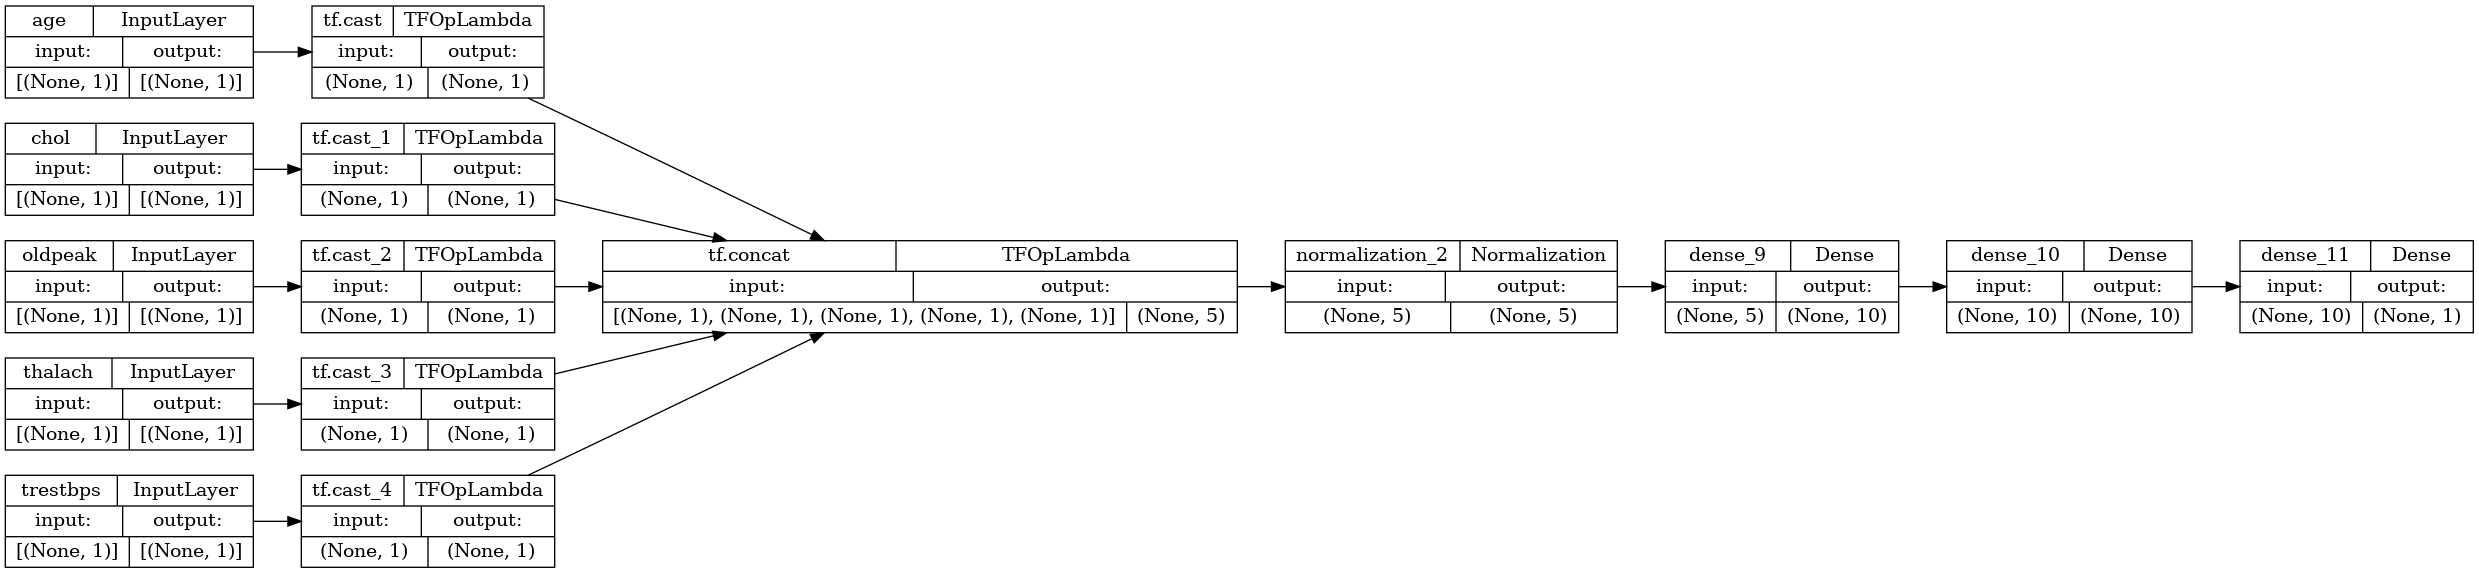

In [25]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)

您可以像模型子类一样训练函数式模型：

In [26]:
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5


  1/152 [..............................] - ETA: 1:31 - loss: 0.5625 - accuracy: 0.5000

  3/152 [..............................] - ETA: 4s - loss: 0.6703 - accuracy: 0.5000  

  5/152 [..............................] - ETA: 4s - loss: 0.6391 - accuracy: 0.5000

  7/152 [>.............................] - ETA: 3s - loss: 0.6277 - accuracy: 0.5714

  9/152 [>.............................] - ETA: 3s - loss: 0.6109 - accuracy: 0.6111

 11/152 [=>............................] - ETA: 3s - loss: 0.6046 - accuracy: 0.5909

 13/152 [=>............................] - ETA: 3s - loss: 0.5866 - accuracy: 0.6538

 15/152 [=>............................] - ETA: 3s - loss: 0.5772 - accuracy: 0.7000

 17/152 [==>...........................] - ETA: 3s - loss: 0.5715 - accuracy: 0.7353

 19/152 [==>...........................] - ETA: 3s - loss: 0.5620 - accuracy: 0.7368

 21/152 [===>..........................] - ETA: 3s - loss: 0.5729 - accuracy: 0.6905

 23/152 [===>..........................] - ETA: 3s - loss: 0.5682 - accuracy: 0.6957

 25/152 [===>..........................] - ETA: 3s - loss: 0.5768 - accuracy: 0.7000

 27/152 [====>.........................] - ETA: 3s - loss: 0.6057 - accuracy: 0.6852

 29/152 [====>.........................] - ETA: 3s - loss: 0.6065 - accuracy: 0.6897

 31/152 [=====>........................] - ETA: 3s - loss: 0.5988 - accuracy: 0.6935

 33/152 [=====>........................] - ETA: 3s - loss: 0.5976 - accuracy: 0.6970

 35/152 [=====>........................] - ETA: 3s - loss: 0.5888 - accuracy: 0.7143

 37/152 [======>.......................] - ETA: 2s - loss: 0.5910 - accuracy: 0.6892

 39/152 [======>.......................] - ETA: 2s - loss: 0.5936 - accuracy: 0.6923

 41/152 [=======>......................] - ETA: 2s - loss: 0.5992 - accuracy: 0.6829

 43/152 [=======>......................] - ETA: 2s - loss: 0.5957 - accuracy: 0.6977

 45/152 [=======>......................] - ETA: 2s - loss: 0.6006 - accuracy: 0.6889

 47/152 [========>.....................] - ETA: 2s - loss: 0.5895 - accuracy: 0.7021

 49/152 [========>.....................] - ETA: 2s - loss: 0.5827 - accuracy: 0.7041

 51/152 [=========>....................] - ETA: 2s - loss: 0.5867 - accuracy: 0.7157

 53/152 [=========>....................] - ETA: 2s - loss: 0.5859 - accuracy: 0.7264

 55/152 [=========>....................] - ETA: 2s - loss: 0.5810 - accuracy: 0.7364

 57/152 [==========>...................] - ETA: 2s - loss: 0.5856 - accuracy: 0.7281

 59/152 [==========>...................] - ETA: 2s - loss: 0.5836 - accuracy: 0.7373

 61/152 [===========>..................] - ETA: 2s - loss: 0.5798 - accuracy: 0.7459

 63/152 [===========>..................] - ETA: 2s - loss: 0.5743 - accuracy: 0.7460

 65/152 [===========>..................] - ETA: 2s - loss: 0.5679 - accuracy: 0.7462

 67/152 [============>.................] - ETA: 2s - loss: 0.5632 - accuracy: 0.7463

 69/152 [============>.................] - ETA: 2s - loss: 0.5594 - accuracy: 0.7536

 71/152 [=============>................] - ETA: 2s - loss: 0.5585 - accuracy: 0.7606

 73/152 [=============>................] - ETA: 2s - loss: 0.5595 - accuracy: 0.7603

 75/152 [=============>................] - ETA: 2s - loss: 0.5582 - accuracy: 0.7600

 77/152 [==============>...............] - ETA: 1s - loss: 0.5646 - accuracy: 0.7468

 79/152 [==============>...............] - ETA: 1s - loss: 0.5599 - accuracy: 0.7532

 81/152 [==============>...............] - ETA: 1s - loss: 0.5599 - accuracy: 0.7531

 84/152 [===============>..............] - ETA: 1s - loss: 0.5550 - accuracy: 0.7500

 86/152 [===============>..............] - ETA: 1s - loss: 0.5511 - accuracy: 0.7558

 88/152 [================>.............] - ETA: 1s - loss: 0.5517 - accuracy: 0.7500

 90/152 [================>.............] - ETA: 1s - loss: 0.5487 - accuracy: 0.7556

 92/152 [=================>............] - ETA: 1s - loss: 0.5483 - accuracy: 0.7554

 94/152 [=================>............] - ETA: 1s - loss: 0.5510 - accuracy: 0.7553

 96/152 [=================>............] - ETA: 1s - loss: 0.5478 - accuracy: 0.7604

 98/152 [==================>...........] - ETA: 1s - loss: 0.5531 - accuracy: 0.7551

100/152 [==================>...........] - ETA: 1s - loss: 0.5545 - accuracy: 0.7500

102/152 [===================>..........] - ETA: 1s - loss: 0.5515 - accuracy: 0.7549

104/152 [===================>..........] - ETA: 1s - loss: 0.5498 - accuracy: 0.7548

106/152 [===================>..........] - ETA: 1s - loss: 0.5488 - accuracy: 0.7594

108/152 [====================>.........] - ETA: 1s - loss: 0.5439 - accuracy: 0.7639

110/152 [====================>.........] - ETA: 1s - loss: 0.5450 - accuracy: 0.7545

112/152 [=====================>........] - ETA: 1s - loss: 0.5436 - accuracy: 0.7545

114/152 [=====================>........] - ETA: 0s - loss: 0.5463 - accuracy: 0.7456

116/152 [=====================>........] - ETA: 0s - loss: 0.5451 - accuracy: 0.7500

118/152 [======================>.......] - ETA: 0s - loss: 0.5488 - accuracy: 0.7500

120/152 [======================>.......] - ETA: 0s - loss: 0.5464 - accuracy: 0.7500

122/152 [=======================>......] - ETA: 0s - loss: 0.5480 - accuracy: 0.7418

124/152 [=======================>......] - ETA: 0s - loss: 0.5451 - accuracy: 0.7419

126/152 [=======================>......] - ETA: 0s - loss: 0.5404 - accuracy: 0.7460

128/152 [========================>.....] - ETA: 0s - loss: 0.5382 - accuracy: 0.7461

130/152 [========================>.....] - ETA: 0s - loss: 0.5362 - accuracy: 0.7462

133/152 [=========================>....] - ETA: 0s - loss: 0.5315 - accuracy: 0.7519

135/152 [=========================>....] - ETA: 0s - loss: 0.5343 - accuracy: 0.7481

137/152 [==========================>...] - ETA: 0s - loss: 0.5372 - accuracy: 0.7482

139/152 [==========================>...] - ETA: 0s - loss: 0.5408 - accuracy: 0.7446

141/152 [==========================>...] - ETA: 0s - loss: 0.5418 - accuracy: 0.7411

143/152 [===========================>..] - ETA: 0s - loss: 0.5409 - accuracy: 0.7413

145/152 [===========================>..] - ETA: 0s - loss: 0.5388 - accuracy: 0.7414

147/152 [============================>.] - ETA: 0s - loss: 0.5361 - accuracy: 0.7449

149/152 [============================>.] - ETA: 0s - loss: 0.5379 - accuracy: 0.7450

151/152 [============================>.] - ETA: 0s - loss: 0.5367 - accuracy: 0.7450

152/152 [==============================] - 5s 26ms/step - loss: 0.5387 - accuracy: 0.7426


Epoch 2/5


  1/152 [..............................] - ETA: 4s - loss: 0.5826 - accuracy: 0.5000

  3/152 [..............................] - ETA: 3s - loss: 0.3843 - accuracy: 0.8333

  5/152 [..............................] - ETA: 3s - loss: 0.3958 - accuracy: 0.8000

  7/152 [>.............................] - ETA: 3s - loss: 0.3787 - accuracy: 0.7857

  9/152 [>.............................] - ETA: 3s - loss: 0.3448 - accuracy: 0.8333

 11/152 [=>............................] - ETA: 3s - loss: 0.4459 - accuracy: 0.7727

 13/152 [=>............................] - ETA: 3s - loss: 0.4464 - accuracy: 0.7692

 15/152 [=>............................] - ETA: 3s - loss: 0.4869 - accuracy: 0.7000

 17/152 [==>...........................] - ETA: 3s - loss: 0.5033 - accuracy: 0.6765

 19/152 [==>...........................] - ETA: 3s - loss: 0.4814 - accuracy: 0.7105

 21/152 [===>..........................] - ETA: 3s - loss: 0.5247 - accuracy: 0.6905

 23/152 [===>..........................] - ETA: 3s - loss: 0.5203 - accuracy: 0.6957

 25/152 [===>..........................] - ETA: 3s - loss: 0.5027 - accuracy: 0.7000

 27/152 [====>.........................] - ETA: 3s - loss: 0.5159 - accuracy: 0.7037

 29/152 [====>.........................] - ETA: 3s - loss: 0.5116 - accuracy: 0.7069

 31/152 [=====>........................] - ETA: 3s - loss: 0.5061 - accuracy: 0.7097

 33/152 [=====>........................] - ETA: 3s - loss: 0.5131 - accuracy: 0.6970

 35/152 [=====>........................] - ETA: 3s - loss: 0.5248 - accuracy: 0.6857

 37/152 [======>.......................] - ETA: 3s - loss: 0.5173 - accuracy: 0.6757

 39/152 [======>.......................] - ETA: 2s - loss: 0.5156 - accuracy: 0.6795

 41/152 [=======>......................] - ETA: 2s - loss: 0.5239 - accuracy: 0.6707

 43/152 [=======>......................] - ETA: 2s - loss: 0.5222 - accuracy: 0.6628

 45/152 [=======>......................] - ETA: 2s - loss: 0.5273 - accuracy: 0.6556

 47/152 [========>.....................] - ETA: 2s - loss: 0.5219 - accuracy: 0.6702

 49/152 [========>.....................] - ETA: 2s - loss: 0.5226 - accuracy: 0.6735

 51/152 [=========>....................] - ETA: 2s - loss: 0.5234 - accuracy: 0.6765

 53/152 [=========>....................] - ETA: 2s - loss: 0.5223 - accuracy: 0.6792

 55/152 [=========>....................] - ETA: 2s - loss: 0.5334 - accuracy: 0.6818

 57/152 [==========>...................] - ETA: 2s - loss: 0.5361 - accuracy: 0.6842

 59/152 [==========>...................] - ETA: 2s - loss: 0.5344 - accuracy: 0.6780

 61/152 [===========>..................] - ETA: 2s - loss: 0.5395 - accuracy: 0.6803

 63/152 [===========>..................] - ETA: 2s - loss: 0.5458 - accuracy: 0.6746

 65/152 [===========>..................] - ETA: 2s - loss: 0.5469 - accuracy: 0.6769

 67/152 [============>.................] - ETA: 2s - loss: 0.5383 - accuracy: 0.6791

 69/152 [============>.................] - ETA: 2s - loss: 0.5292 - accuracy: 0.6884

 71/152 [=============>................] - ETA: 2s - loss: 0.5281 - accuracy: 0.6901

 73/152 [=============>................] - ETA: 2s - loss: 0.5217 - accuracy: 0.6986

 75/152 [=============>................] - ETA: 2s - loss: 0.5236 - accuracy: 0.7000

 77/152 [==============>...............] - ETA: 1s - loss: 0.5227 - accuracy: 0.7013

 79/152 [==============>...............] - ETA: 1s - loss: 0.5186 - accuracy: 0.7089

 81/152 [==============>...............] - ETA: 1s - loss: 0.5128 - accuracy: 0.7099

 83/152 [===============>..............] - ETA: 1s - loss: 0.5116 - accuracy: 0.7108

 85/152 [===============>..............] - ETA: 1s - loss: 0.5092 - accuracy: 0.7118

 87/152 [================>.............] - ETA: 1s - loss: 0.5044 - accuracy: 0.7126

 89/152 [================>.............] - ETA: 1s - loss: 0.5032 - accuracy: 0.7135

 91/152 [================>.............] - ETA: 1s - loss: 0.5006 - accuracy: 0.7143

 93/152 [=================>............] - ETA: 1s - loss: 0.5004 - accuracy: 0.7151

 95/152 [=================>............] - ETA: 1s - loss: 0.4977 - accuracy: 0.7211

 97/152 [==================>...........] - ETA: 1s - loss: 0.4963 - accuracy: 0.7268

 99/152 [==================>...........] - ETA: 1s - loss: 0.4965 - accuracy: 0.7273

101/152 [==================>...........] - ETA: 1s - loss: 0.4901 - accuracy: 0.7327

103/152 [===================>..........] - ETA: 1s - loss: 0.4883 - accuracy: 0.7379

105/152 [===================>..........] - ETA: 1s - loss: 0.4889 - accuracy: 0.7333

107/152 [====================>.........] - ETA: 1s - loss: 0.4912 - accuracy: 0.7290

109/152 [====================>.........] - ETA: 1s - loss: 0.4919 - accuracy: 0.7294

111/152 [====================>.........] - ETA: 1s - loss: 0.4969 - accuracy: 0.7252

113/152 [=====================>........] - ETA: 1s - loss: 0.4961 - accuracy: 0.7257

115/152 [=====================>........] - ETA: 0s - loss: 0.4926 - accuracy: 0.7261

117/152 [======================>.......] - ETA: 0s - loss: 0.4894 - accuracy: 0.7308

119/152 [======================>.......] - ETA: 0s - loss: 0.4852 - accuracy: 0.7353

121/152 [======================>.......] - ETA: 0s - loss: 0.4804 - accuracy: 0.7397

123/152 [=======================>......] - ETA: 0s - loss: 0.4782 - accuracy: 0.7398

125/152 [=======================>......] - ETA: 0s - loss: 0.4787 - accuracy: 0.7400

127/152 [========================>.....] - ETA: 0s - loss: 0.4814 - accuracy: 0.7402

129/152 [========================>.....] - ETA: 0s - loss: 0.4840 - accuracy: 0.7364

131/152 [========================>.....] - ETA: 0s - loss: 0.4822 - accuracy: 0.7405

133/152 [=========================>....] - ETA: 0s - loss: 0.4809 - accuracy: 0.7406

135/152 [=========================>....] - ETA: 0s - loss: 0.4768 - accuracy: 0.7444

137/152 [==========================>...] - ETA: 0s - loss: 0.4771 - accuracy: 0.7445

139/152 [==========================>...] - ETA: 0s - loss: 0.4785 - accuracy: 0.7446

141/152 [==========================>...] - ETA: 0s - loss: 0.4835 - accuracy: 0.7411

143/152 [===========================>..] - ETA: 0s - loss: 0.4806 - accuracy: 0.7448

146/152 [===========================>..] - ETA: 0s - loss: 0.4777 - accuracy: 0.7432

148/152 [============================>.] - ETA: 0s - loss: 0.4798 - accuracy: 0.7399

150/152 [============================>.] - ETA: 0s - loss: 0.4808 - accuracy: 0.7367

152/152 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.7393

152/152 [==============================] - 4s 26ms/step - loss: 0.4771 - accuracy: 0.7393


Epoch 3/5


  1/152 [..............................] - ETA: 3s - loss: 0.3714 - accuracy: 0.5000

  3/152 [..............................] - ETA: 3s - loss: 0.5662 - accuracy: 0.5000

  5/152 [..............................] - ETA: 3s - loss: 0.4844 - accuracy: 0.7000

  7/152 [>.............................] - ETA: 3s - loss: 0.5529 - accuracy: 0.7143

  9/152 [>.............................] - ETA: 3s - loss: 0.5219 - accuracy: 0.7778

 11/152 [=>............................] - ETA: 3s - loss: 0.5304 - accuracy: 0.7727

 13/152 [=>............................] - ETA: 3s - loss: 0.5467 - accuracy: 0.7692

 15/152 [=>............................] - ETA: 3s - loss: 0.5158 - accuracy: 0.8000

 17/152 [==>...........................] - ETA: 3s - loss: 0.4756 - accuracy: 0.7941

 19/152 [==>...........................] - ETA: 3s - loss: 0.4868 - accuracy: 0.7632

 21/152 [===>..........................] - ETA: 3s - loss: 0.4604 - accuracy: 0.7619

 23/152 [===>..........................] - ETA: 3s - loss: 0.4923 - accuracy: 0.7391

 25/152 [===>..........................] - ETA: 3s - loss: 0.4772 - accuracy: 0.7600

 27/152 [====>.........................] - ETA: 3s - loss: 0.4751 - accuracy: 0.7407

 29/152 [====>.........................] - ETA: 3s - loss: 0.4670 - accuracy: 0.7414

 31/152 [=====>........................] - ETA: 3s - loss: 0.4602 - accuracy: 0.7419

 33/152 [=====>........................] - ETA: 3s - loss: 0.4547 - accuracy: 0.7424

 35/152 [=====>........................] - ETA: 3s - loss: 0.4464 - accuracy: 0.7429

 37/152 [======>.......................] - ETA: 3s - loss: 0.4358 - accuracy: 0.7568

 39/152 [======>.......................] - ETA: 2s - loss: 0.4332 - accuracy: 0.7564

 41/152 [=======>......................] - ETA: 2s - loss: 0.4424 - accuracy: 0.7439

 43/152 [=======>......................] - ETA: 2s - loss: 0.4535 - accuracy: 0.7442

 45/152 [=======>......................] - ETA: 2s - loss: 0.4487 - accuracy: 0.7444

 47/152 [========>.....................] - ETA: 2s - loss: 0.4441 - accuracy: 0.7447

 49/152 [========>.....................] - ETA: 2s - loss: 0.4500 - accuracy: 0.7449

 51/152 [=========>....................] - ETA: 2s - loss: 0.4559 - accuracy: 0.7353

 53/152 [=========>....................] - ETA: 2s - loss: 0.4630 - accuracy: 0.7264

 55/152 [=========>....................] - ETA: 2s - loss: 0.4633 - accuracy: 0.7182

 57/152 [==========>...................] - ETA: 2s - loss: 0.4517 - accuracy: 0.7281

 59/152 [==========>...................] - ETA: 2s - loss: 0.4467 - accuracy: 0.7373

 62/152 [===========>..................] - ETA: 2s - loss: 0.4486 - accuracy: 0.7419

 64/152 [===========>..................] - ETA: 2s - loss: 0.4420 - accuracy: 0.7500

 66/152 [============>.................] - ETA: 2s - loss: 0.4392 - accuracy: 0.7576

 68/152 [============>.................] - ETA: 2s - loss: 0.4433 - accuracy: 0.7500

 70/152 [============>.................] - ETA: 2s - loss: 0.4440 - accuracy: 0.7429

 72/152 [=============>................] - ETA: 2s - loss: 0.4360 - accuracy: 0.7500

 74/152 [=============>................] - ETA: 2s - loss: 0.4355 - accuracy: 0.7568

 76/152 [==============>...............] - ETA: 1s - loss: 0.4436 - accuracy: 0.7500

 78/152 [==============>...............] - ETA: 1s - loss: 0.4399 - accuracy: 0.7500

 80/152 [==============>...............] - ETA: 1s - loss: 0.4349 - accuracy: 0.7563

 82/152 [===============>..............] - ETA: 1s - loss: 0.4365 - accuracy: 0.7561

 85/152 [===============>..............] - ETA: 1s - loss: 0.4278 - accuracy: 0.7588

 87/152 [================>.............] - ETA: 1s - loss: 0.4319 - accuracy: 0.7529

 89/152 [================>.............] - ETA: 1s - loss: 0.4288 - accuracy: 0.7528

 91/152 [================>.............] - ETA: 1s - loss: 0.4281 - accuracy: 0.7527

 93/152 [=================>............] - ETA: 1s - loss: 0.4357 - accuracy: 0.7527

 96/152 [=================>............] - ETA: 1s - loss: 0.4532 - accuracy: 0.7448

 98/152 [==================>...........] - ETA: 1s - loss: 0.4485 - accuracy: 0.7500

100/152 [==================>...........] - ETA: 1s - loss: 0.4482 - accuracy: 0.7550

102/152 [===================>..........] - ETA: 1s - loss: 0.4451 - accuracy: 0.7598

104/152 [===================>..........] - ETA: 1s - loss: 0.4542 - accuracy: 0.7500

106/152 [===================>..........] - ETA: 1s - loss: 0.4552 - accuracy: 0.7453

108/152 [====================>.........] - ETA: 1s - loss: 0.4608 - accuracy: 0.7407

110/152 [====================>.........] - ETA: 1s - loss: 0.4576 - accuracy: 0.7455

112/152 [=====================>........] - ETA: 1s - loss: 0.4560 - accuracy: 0.7411

114/152 [=====================>........] - ETA: 0s - loss: 0.4509 - accuracy: 0.7456

116/152 [=====================>........] - ETA: 0s - loss: 0.4485 - accuracy: 0.7457

118/152 [======================>.......] - ETA: 0s - loss: 0.4426 - accuracy: 0.7500

120/152 [======================>.......] - ETA: 0s - loss: 0.4392 - accuracy: 0.7542

122/152 [=======================>......] - ETA: 0s - loss: 0.4452 - accuracy: 0.7500

124/152 [=======================>......] - ETA: 0s - loss: 0.4455 - accuracy: 0.7500

126/152 [=======================>......] - ETA: 0s - loss: 0.4465 - accuracy: 0.7500

128/152 [========================>.....] - ETA: 0s - loss: 0.4424 - accuracy: 0.7500

130/152 [========================>.....] - ETA: 0s - loss: 0.4465 - accuracy: 0.7500

132/152 [=========================>....] - ETA: 0s - loss: 0.4479 - accuracy: 0.7500

134/152 [=========================>....] - ETA: 0s - loss: 0.4479 - accuracy: 0.7500

136/152 [=========================>....] - ETA: 0s - loss: 0.4480 - accuracy: 0.7463

138/152 [==========================>...] - ETA: 0s - loss: 0.4454 - accuracy: 0.7464

140/152 [==========================>...] - ETA: 0s - loss: 0.4438 - accuracy: 0.7500

142/152 [===========================>..] - ETA: 0s - loss: 0.4459 - accuracy: 0.7500

145/152 [===========================>..] - ETA: 0s - loss: 0.4477 - accuracy: 0.7483

147/152 [============================>.] - ETA: 0s - loss: 0.4516 - accuracy: 0.7483

149/152 [============================>.] - ETA: 0s - loss: 0.4490 - accuracy: 0.7517

151/152 [============================>.] - ETA: 0s - loss: 0.4509 - accuracy: 0.7450

152/152 [==============================] - 4s 26ms/step - loss: 0.4580 - accuracy: 0.7426


Epoch 4/5


  1/152 [..............................] - ETA: 3s - loss: 0.8958 - accuracy: 0.5000

  3/152 [..............................] - ETA: 3s - loss: 1.0042 - accuracy: 0.5000

  5/152 [..............................] - ETA: 3s - loss: 1.0367 - accuracy: 0.6000

  7/152 [>.............................] - ETA: 3s - loss: 0.9459 - accuracy: 0.6429

  9/152 [>.............................] - ETA: 3s - loss: 0.8085 - accuracy: 0.6667

 11/152 [=>............................] - ETA: 3s - loss: 0.7383 - accuracy: 0.6818

 13/152 [=>............................] - ETA: 3s - loss: 0.7044 - accuracy: 0.7308

 15/152 [=>............................] - ETA: 3s - loss: 0.6421 - accuracy: 0.7333

 17/152 [==>...........................] - ETA: 3s - loss: 0.6181 - accuracy: 0.7647

 19/152 [==>...........................] - ETA: 3s - loss: 0.5804 - accuracy: 0.7895

 21/152 [===>..........................] - ETA: 3s - loss: 0.6087 - accuracy: 0.7619

 23/152 [===>..........................] - ETA: 3s - loss: 0.6014 - accuracy: 0.7609

 25/152 [===>..........................] - ETA: 3s - loss: 0.5781 - accuracy: 0.7800

 27/152 [====>.........................] - ETA: 3s - loss: 0.5529 - accuracy: 0.7963

 29/152 [====>.........................] - ETA: 3s - loss: 0.5424 - accuracy: 0.7931

 31/152 [=====>........................] - ETA: 3s - loss: 0.5319 - accuracy: 0.7903

 33/152 [=====>........................] - ETA: 3s - loss: 0.5315 - accuracy: 0.7879

 35/152 [=====>........................] - ETA: 3s - loss: 0.5221 - accuracy: 0.7714

 37/152 [======>.......................] - ETA: 3s - loss: 0.5315 - accuracy: 0.7297

 39/152 [======>.......................] - ETA: 2s - loss: 0.5281 - accuracy: 0.7308

 41/152 [=======>......................] - ETA: 2s - loss: 0.5248 - accuracy: 0.7317

 43/152 [=======>......................] - ETA: 2s - loss: 0.5118 - accuracy: 0.7326

 45/152 [=======>......................] - ETA: 2s - loss: 0.5121 - accuracy: 0.7222

 47/152 [========>.....................] - ETA: 2s - loss: 0.5140 - accuracy: 0.7128

 49/152 [========>.....................] - ETA: 2s - loss: 0.5048 - accuracy: 0.7143

 51/152 [=========>....................] - ETA: 2s - loss: 0.4889 - accuracy: 0.7255

 53/152 [=========>....................] - ETA: 2s - loss: 0.4798 - accuracy: 0.7264

 55/152 [=========>....................] - ETA: 2s - loss: 0.4738 - accuracy: 0.7364

 57/152 [==========>...................] - ETA: 2s - loss: 0.4680 - accuracy: 0.7281

 59/152 [==========>...................] - ETA: 2s - loss: 0.4669 - accuracy: 0.7373

 61/152 [===========>..................] - ETA: 2s - loss: 0.4642 - accuracy: 0.7459

 63/152 [===========>..................] - ETA: 2s - loss: 0.4737 - accuracy: 0.7460

 65/152 [===========>..................] - ETA: 2s - loss: 0.4754 - accuracy: 0.7462

 67/152 [============>.................] - ETA: 2s - loss: 0.4828 - accuracy: 0.7313

 69/152 [============>.................] - ETA: 2s - loss: 0.4727 - accuracy: 0.7391

 71/152 [=============>................] - ETA: 2s - loss: 0.4702 - accuracy: 0.7394

 73/152 [=============>................] - ETA: 2s - loss: 0.4787 - accuracy: 0.7397

 75/152 [=============>................] - ETA: 2s - loss: 0.4813 - accuracy: 0.7333

 77/152 [==============>...............] - ETA: 1s - loss: 0.4821 - accuracy: 0.7338

 79/152 [==============>...............] - ETA: 1s - loss: 0.4755 - accuracy: 0.7405

 81/152 [==============>...............] - ETA: 1s - loss: 0.4785 - accuracy: 0.7407

 83/152 [===============>..............] - ETA: 1s - loss: 0.4884 - accuracy: 0.7349

 85/152 [===============>..............] - ETA: 1s - loss: 0.4842 - accuracy: 0.7294

 87/152 [================>.............] - ETA: 1s - loss: 0.4958 - accuracy: 0.7241

 89/152 [================>.............] - ETA: 1s - loss: 0.4911 - accuracy: 0.7303

 91/152 [================>.............] - ETA: 1s - loss: 0.4913 - accuracy: 0.7308

 93/152 [=================>............] - ETA: 1s - loss: 0.4825 - accuracy: 0.7366

 95/152 [=================>............] - ETA: 1s - loss: 0.4823 - accuracy: 0.7368

 97/152 [==================>...........] - ETA: 1s - loss: 0.4874 - accuracy: 0.7371

 99/152 [==================>...........] - ETA: 1s - loss: 0.4861 - accuracy: 0.7374

101/152 [==================>...........] - ETA: 1s - loss: 0.4872 - accuracy: 0.7327

103/152 [===================>..........] - ETA: 1s - loss: 0.4833 - accuracy: 0.7330

105/152 [===================>..........] - ETA: 1s - loss: 0.4815 - accuracy: 0.7381

107/152 [====================>.........] - ETA: 1s - loss: 0.4771 - accuracy: 0.7383

109/152 [====================>.........] - ETA: 1s - loss: 0.4734 - accuracy: 0.7385

111/152 [====================>.........] - ETA: 1s - loss: 0.4759 - accuracy: 0.7342

113/152 [=====================>........] - ETA: 1s - loss: 0.4700 - accuracy: 0.7389

115/152 [=====================>........] - ETA: 0s - loss: 0.4668 - accuracy: 0.7435

117/152 [======================>.......] - ETA: 0s - loss: 0.4628 - accuracy: 0.7479

119/152 [======================>.......] - ETA: 0s - loss: 0.4648 - accuracy: 0.7437

121/152 [======================>.......] - ETA: 0s - loss: 0.4591 - accuracy: 0.7479

123/152 [=======================>......] - ETA: 0s - loss: 0.4620 - accuracy: 0.7439

125/152 [=======================>......] - ETA: 0s - loss: 0.4674 - accuracy: 0.7440

127/152 [========================>.....] - ETA: 0s - loss: 0.4696 - accuracy: 0.7402

129/152 [========================>.....] - ETA: 0s - loss: 0.4696 - accuracy: 0.7403

131/152 [========================>.....] - ETA: 0s - loss: 0.4665 - accuracy: 0.7405

133/152 [=========================>....] - ETA: 0s - loss: 0.4660 - accuracy: 0.7444

135/152 [=========================>....] - ETA: 0s - loss: 0.4624 - accuracy: 0.7444

137/152 [==========================>...] - ETA: 0s - loss: 0.4622 - accuracy: 0.7445

139/152 [==========================>...] - ETA: 0s - loss: 0.4582 - accuracy: 0.7482

141/152 [==========================>...] - ETA: 0s - loss: 0.4571 - accuracy: 0.7482

143/152 [===========================>..] - ETA: 0s - loss: 0.4549 - accuracy: 0.7517

145/152 [===========================>..] - ETA: 0s - loss: 0.4533 - accuracy: 0.7552

147/152 [============================>.] - ETA: 0s - loss: 0.4546 - accuracy: 0.7585

149/152 [============================>.] - ETA: 0s - loss: 0.4529 - accuracy: 0.7584

151/152 [============================>.] - ETA: 0s - loss: 0.4518 - accuracy: 0.7616

152/152 [==============================] - 4s 26ms/step - loss: 0.4504 - accuracy: 0.7624


Epoch 5/5


  1/152 [..............................] - ETA: 4s - loss: 0.1987 - accuracy: 1.0000

  3/152 [..............................] - ETA: 3s - loss: 0.4564 - accuracy: 0.8333

  5/152 [..............................] - ETA: 3s - loss: 0.3293 - accuracy: 0.9000

  7/152 [>.............................] - ETA: 3s - loss: 0.4048 - accuracy: 0.7857

  9/152 [>.............................] - ETA: 3s - loss: 0.4745 - accuracy: 0.7778

 11/152 [=>............................] - ETA: 3s - loss: 0.4279 - accuracy: 0.8182

 13/152 [=>............................] - ETA: 3s - loss: 0.3891 - accuracy: 0.8462

 15/152 [=>............................] - ETA: 3s - loss: 0.4300 - accuracy: 0.8333

 17/152 [==>...........................] - ETA: 3s - loss: 0.4229 - accuracy: 0.8235

 19/152 [==>...........................] - ETA: 3s - loss: 0.4980 - accuracy: 0.7895

 21/152 [===>..........................] - ETA: 3s - loss: 0.4725 - accuracy: 0.7857

 23/152 [===>..........................] - ETA: 3s - loss: 0.4624 - accuracy: 0.8043

 25/152 [===>..........................] - ETA: 3s - loss: 0.4459 - accuracy: 0.8000

 27/152 [====>.........................] - ETA: 3s - loss: 0.4697 - accuracy: 0.7593

 29/152 [====>.........................] - ETA: 3s - loss: 0.4600 - accuracy: 0.7586

 31/152 [=====>........................] - ETA: 3s - loss: 0.4651 - accuracy: 0.7581

 34/152 [=====>........................] - ETA: 3s - loss: 0.4860 - accuracy: 0.7500

 36/152 [======>.......................] - ETA: 3s - loss: 0.4827 - accuracy: 0.7500

 38/152 [======>.......................] - ETA: 2s - loss: 0.4771 - accuracy: 0.7500

 40/152 [======>.......................] - ETA: 2s - loss: 0.4694 - accuracy: 0.7625

 42/152 [=======>......................] - ETA: 2s - loss: 0.4596 - accuracy: 0.7619

 44/152 [=======>......................] - ETA: 2s - loss: 0.4483 - accuracy: 0.7614

 46/152 [========>.....................] - ETA: 2s - loss: 0.4393 - accuracy: 0.7717

 48/152 [========>.....................] - ETA: 2s - loss: 0.4346 - accuracy: 0.7708

 50/152 [========>.....................] - ETA: 2s - loss: 0.4347 - accuracy: 0.7700

 52/152 [=========>....................] - ETA: 2s - loss: 0.4266 - accuracy: 0.7692

 54/152 [=========>....................] - ETA: 2s - loss: 0.4192 - accuracy: 0.7778

 56/152 [==========>...................] - ETA: 2s - loss: 0.4350 - accuracy: 0.7768

 58/152 [==========>...................] - ETA: 2s - loss: 0.4403 - accuracy: 0.7672

 60/152 [==========>...................] - ETA: 2s - loss: 0.4548 - accuracy: 0.7667

 62/152 [===========>..................] - ETA: 2s - loss: 0.4517 - accuracy: 0.7661

 64/152 [===========>..................] - ETA: 2s - loss: 0.4472 - accuracy: 0.7656

 66/152 [============>.................] - ETA: 2s - loss: 0.4437 - accuracy: 0.7727

 68/152 [============>.................] - ETA: 2s - loss: 0.4388 - accuracy: 0.7721

 70/152 [============>.................] - ETA: 2s - loss: 0.4341 - accuracy: 0.7714

 72/152 [=============>................] - ETA: 2s - loss: 0.4315 - accuracy: 0.7708

 74/152 [=============>................] - ETA: 2s - loss: 0.4395 - accuracy: 0.7703

 76/152 [==============>...............] - ETA: 1s - loss: 0.4319 - accuracy: 0.7763

 78/152 [==============>...............] - ETA: 1s - loss: 0.4237 - accuracy: 0.7821

 80/152 [==============>...............] - ETA: 1s - loss: 0.4169 - accuracy: 0.7875

 82/152 [===============>..............] - ETA: 1s - loss: 0.4193 - accuracy: 0.7866

 84/152 [===============>..............] - ETA: 1s - loss: 0.4162 - accuracy: 0.7798

 86/152 [===============>..............] - ETA: 1s - loss: 0.4161 - accuracy: 0.7791

 88/152 [================>.............] - ETA: 1s - loss: 0.4277 - accuracy: 0.7784

 90/152 [================>.............] - ETA: 1s - loss: 0.4332 - accuracy: 0.7778

 92/152 [=================>............] - ETA: 1s - loss: 0.4396 - accuracy: 0.7717

 94/152 [=================>............] - ETA: 1s - loss: 0.4492 - accuracy: 0.7713

 96/152 [=================>............] - ETA: 1s - loss: 0.4446 - accuracy: 0.7760

 98/152 [==================>...........] - ETA: 1s - loss: 0.4482 - accuracy: 0.7755

100/152 [==================>...........] - ETA: 1s - loss: 0.4485 - accuracy: 0.7700

102/152 [===================>..........] - ETA: 1s - loss: 0.4489 - accuracy: 0.7647

104/152 [===================>..........] - ETA: 1s - loss: 0.4453 - accuracy: 0.7692

106/152 [===================>..........] - ETA: 1s - loss: 0.4466 - accuracy: 0.7689

108/152 [====================>.........] - ETA: 1s - loss: 0.4465 - accuracy: 0.7685

110/152 [====================>.........] - ETA: 1s - loss: 0.4447 - accuracy: 0.7727

112/152 [=====================>........] - ETA: 1s - loss: 0.4390 - accuracy: 0.7768

114/152 [=====================>........] - ETA: 0s - loss: 0.4371 - accuracy: 0.7763

116/152 [=====================>........] - ETA: 0s - loss: 0.4443 - accuracy: 0.7716

118/152 [======================>.......] - ETA: 0s - loss: 0.4378 - accuracy: 0.7754

120/152 [======================>.......] - ETA: 0s - loss: 0.4465 - accuracy: 0.7708

122/152 [=======================>......] - ETA: 0s - loss: 0.4445 - accuracy: 0.7746

124/152 [=======================>......] - ETA: 0s - loss: 0.4464 - accuracy: 0.7742

126/152 [=======================>......] - ETA: 0s - loss: 0.4413 - accuracy: 0.7778

128/152 [========================>.....] - ETA: 0s - loss: 0.4423 - accuracy: 0.7734

130/152 [========================>.....] - ETA: 0s - loss: 0.4384 - accuracy: 0.7769

132/152 [=========================>....] - ETA: 0s - loss: 0.4370 - accuracy: 0.7765

134/152 [=========================>....] - ETA: 0s - loss: 0.4357 - accuracy: 0.7799

136/152 [=========================>....] - ETA: 0s - loss: 0.4367 - accuracy: 0.7794

138/152 [==========================>...] - ETA: 0s - loss: 0.4392 - accuracy: 0.7754

140/152 [==========================>...] - ETA: 0s - loss: 0.4394 - accuracy: 0.7750

142/152 [===========================>..] - ETA: 0s - loss: 0.4439 - accuracy: 0.7711

144/152 [===========================>..] - ETA: 0s - loss: 0.4434 - accuracy: 0.7708

146/152 [===========================>..] - ETA: 0s - loss: 0.4453 - accuracy: 0.7705

148/152 [============================>.] - ETA: 0s - loss: 0.4437 - accuracy: 0.7703

150/152 [============================>.] - ETA: 0s - loss: 0.4447 - accuracy: 0.7700

152/152 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.7723

152/152 [==============================] - 4s 26ms/step - loss: 0.4442 - accuracy: 0.7723


In [27]:
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
model.fit(numeric_dict_batches, epochs=5)

Epoch 1/5


  1/152 [..............................] - ETA: 4s - loss: 0.0337 - accuracy: 1.0000

  3/152 [..............................] - ETA: 4s - loss: 0.3910 - accuracy: 0.8333

  5/152 [..............................] - ETA: 4s - loss: 0.3697 - accuracy: 0.8000

  7/152 [>.............................] - ETA: 4s - loss: 0.4201 - accuracy: 0.7857

  9/152 [>.............................] - ETA: 3s - loss: 0.3675 - accuracy: 0.8333

 11/152 [=>............................] - ETA: 3s - loss: 0.4244 - accuracy: 0.7727

 13/152 [=>............................] - ETA: 3s - loss: 0.4857 - accuracy: 0.6923

 15/152 [=>............................] - ETA: 3s - loss: 0.5054 - accuracy: 0.7000

 17/152 [==>...........................] - ETA: 3s - loss: 0.5063 - accuracy: 0.6765

 19/152 [==>...........................] - ETA: 3s - loss: 0.4747 - accuracy: 0.7105

 21/152 [===>..........................] - ETA: 3s - loss: 0.4494 - accuracy: 0.7381

 23/152 [===>..........................] - ETA: 3s - loss: 0.4299 - accuracy: 0.7609

 25/152 [===>..........................] - ETA: 3s - loss: 0.4507 - accuracy: 0.7600

 27/152 [====>.........................] - ETA: 3s - loss: 0.4413 - accuracy: 0.7593

 29/152 [====>.........................] - ETA: 3s - loss: 0.4225 - accuracy: 0.7759

 31/152 [=====>........................] - ETA: 3s - loss: 0.4273 - accuracy: 0.7742

 33/152 [=====>........................] - ETA: 3s - loss: 0.4190 - accuracy: 0.7879

 35/152 [=====>........................] - ETA: 3s - loss: 0.4207 - accuracy: 0.7857

 37/152 [======>.......................] - ETA: 3s - loss: 0.4181 - accuracy: 0.7973

 39/152 [======>.......................] - ETA: 3s - loss: 0.4064 - accuracy: 0.8077

 41/152 [=======>......................] - ETA: 2s - loss: 0.4261 - accuracy: 0.7927

 43/152 [=======>......................] - ETA: 2s - loss: 0.4463 - accuracy: 0.7791

 45/152 [=======>......................] - ETA: 2s - loss: 0.4382 - accuracy: 0.7889

 47/152 [========>.....................] - ETA: 2s - loss: 0.4763 - accuracy: 0.7766

 49/152 [========>.....................] - ETA: 2s - loss: 0.4691 - accuracy: 0.7857

 51/152 [=========>....................] - ETA: 2s - loss: 0.4813 - accuracy: 0.7843

 53/152 [=========>....................] - ETA: 2s - loss: 0.4853 - accuracy: 0.7830

 55/152 [=========>....................] - ETA: 2s - loss: 0.4850 - accuracy: 0.7727

 57/152 [==========>...................] - ETA: 2s - loss: 0.4939 - accuracy: 0.7719

 59/152 [==========>...................] - ETA: 2s - loss: 0.4889 - accuracy: 0.7712

 61/152 [===========>..................] - ETA: 2s - loss: 0.4815 - accuracy: 0.7787

 63/152 [===========>..................] - ETA: 2s - loss: 0.4790 - accuracy: 0.7778

 65/152 [===========>..................] - ETA: 2s - loss: 0.4797 - accuracy: 0.7692

 67/152 [============>.................] - ETA: 2s - loss: 0.4728 - accuracy: 0.7687

 69/152 [============>.................] - ETA: 2s - loss: 0.4639 - accuracy: 0.7681

 71/152 [=============>................] - ETA: 2s - loss: 0.4595 - accuracy: 0.7676

 73/152 [=============>................] - ETA: 2s - loss: 0.4589 - accuracy: 0.7740

 75/152 [=============>................] - ETA: 2s - loss: 0.4726 - accuracy: 0.7533

 77/152 [==============>...............] - ETA: 2s - loss: 0.4644 - accuracy: 0.7597

 79/152 [==============>...............] - ETA: 1s - loss: 0.4637 - accuracy: 0.7658

 81/152 [==============>...............] - ETA: 1s - loss: 0.4604 - accuracy: 0.7716

 83/152 [===============>..............] - ETA: 1s - loss: 0.4586 - accuracy: 0.7711

 85/152 [===============>..............] - ETA: 1s - loss: 0.4569 - accuracy: 0.7706

 87/152 [================>.............] - ETA: 1s - loss: 0.4579 - accuracy: 0.7644

 89/152 [================>.............] - ETA: 1s - loss: 0.4542 - accuracy: 0.7697

 91/152 [================>.............] - ETA: 1s - loss: 0.4472 - accuracy: 0.7747

 93/152 [=================>............] - ETA: 1s - loss: 0.4465 - accuracy: 0.7688

 95/152 [=================>............] - ETA: 1s - loss: 0.4574 - accuracy: 0.7632

 97/152 [==================>...........] - ETA: 1s - loss: 0.4537 - accuracy: 0.7680

 99/152 [==================>...........] - ETA: 1s - loss: 0.4484 - accuracy: 0.7727

101/152 [==================>...........] - ETA: 1s - loss: 0.4427 - accuracy: 0.7772

103/152 [===================>..........] - ETA: 1s - loss: 0.4377 - accuracy: 0.7816

105/152 [===================>..........] - ETA: 1s - loss: 0.4391 - accuracy: 0.7762

107/152 [====================>.........] - ETA: 1s - loss: 0.4439 - accuracy: 0.7710

109/152 [====================>.........] - ETA: 1s - loss: 0.4430 - accuracy: 0.7661

111/152 [====================>.........] - ETA: 1s - loss: 0.4422 - accuracy: 0.7613

113/152 [=====================>........] - ETA: 1s - loss: 0.4367 - accuracy: 0.7655

115/152 [=====================>........] - ETA: 0s - loss: 0.4372 - accuracy: 0.7609

117/152 [======================>.......] - ETA: 0s - loss: 0.4332 - accuracy: 0.7650

119/152 [======================>.......] - ETA: 0s - loss: 0.4358 - accuracy: 0.7647

121/152 [======================>.......] - ETA: 0s - loss: 0.4420 - accuracy: 0.7603

123/152 [=======================>......] - ETA: 0s - loss: 0.4368 - accuracy: 0.7642

125/152 [=======================>......] - ETA: 0s - loss: 0.4353 - accuracy: 0.7640

127/152 [========================>.....] - ETA: 0s - loss: 0.4307 - accuracy: 0.7677

129/152 [========================>.....] - ETA: 0s - loss: 0.4257 - accuracy: 0.7713

131/152 [========================>.....] - ETA: 0s - loss: 0.4285 - accuracy: 0.7672

133/152 [=========================>....] - ETA: 0s - loss: 0.4306 - accuracy: 0.7669

135/152 [=========================>....] - ETA: 0s - loss: 0.4371 - accuracy: 0.7630

137/152 [==========================>...] - ETA: 0s - loss: 0.4374 - accuracy: 0.7628

139/152 [==========================>...] - ETA: 0s - loss: 0.4424 - accuracy: 0.7626

141/152 [==========================>...] - ETA: 0s - loss: 0.4420 - accuracy: 0.7624

143/152 [===========================>..] - ETA: 0s - loss: 0.4408 - accuracy: 0.7622

145/152 [===========================>..] - ETA: 0s - loss: 0.4379 - accuracy: 0.7655

147/152 [============================>.] - ETA: 0s - loss: 0.4351 - accuracy: 0.7687

149/152 [============================>.] - ETA: 0s - loss: 0.4331 - accuracy: 0.7718

151/152 [============================>.] - ETA: 0s - loss: 0.4394 - accuracy: 0.7715

152/152 [==============================] - 4s 27ms/step - loss: 0.4412 - accuracy: 0.7690


Epoch 2/5


  1/152 [..............................] - ETA: 4s - loss: 0.2886 - accuracy: 1.0000

  3/152 [..............................] - ETA: 4s - loss: 0.2218 - accuracy: 1.0000

  5/152 [..............................] - ETA: 4s - loss: 0.3128 - accuracy: 0.9000

  7/152 [>.............................] - ETA: 4s - loss: 0.3528 - accuracy: 0.7857

  9/152 [>.............................] - ETA: 4s - loss: 0.3820 - accuracy: 0.7222

 11/152 [=>............................] - ETA: 3s - loss: 0.3398 - accuracy: 0.7727

 13/152 [=>............................] - ETA: 3s - loss: 0.4124 - accuracy: 0.7308

 15/152 [=>............................] - ETA: 3s - loss: 0.3894 - accuracy: 0.7667

 17/152 [==>...........................] - ETA: 3s - loss: 0.4156 - accuracy: 0.7647

 19/152 [==>...........................] - ETA: 3s - loss: 0.3975 - accuracy: 0.7895

 21/152 [===>..........................] - ETA: 3s - loss: 0.4047 - accuracy: 0.8095

 23/152 [===>..........................] - ETA: 3s - loss: 0.4032 - accuracy: 0.8043

 25/152 [===>..........................] - ETA: 3s - loss: 0.4002 - accuracy: 0.8000

 27/152 [====>.........................] - ETA: 3s - loss: 0.3895 - accuracy: 0.8148

 29/152 [====>.........................] - ETA: 3s - loss: 0.3846 - accuracy: 0.8103

 31/152 [=====>........................] - ETA: 3s - loss: 0.3879 - accuracy: 0.8065

 33/152 [=====>........................] - ETA: 3s - loss: 0.3752 - accuracy: 0.8182

 35/152 [=====>........................] - ETA: 3s - loss: 0.3712 - accuracy: 0.8286

 37/152 [======>.......................] - ETA: 3s - loss: 0.3890 - accuracy: 0.8108

 39/152 [======>.......................] - ETA: 3s - loss: 0.4031 - accuracy: 0.8205

 41/152 [=======>......................] - ETA: 3s - loss: 0.3999 - accuracy: 0.8171

 43/152 [=======>......................] - ETA: 2s - loss: 0.4038 - accuracy: 0.8140

 45/152 [=======>......................] - ETA: 2s - loss: 0.3958 - accuracy: 0.8222

 47/152 [========>.....................] - ETA: 2s - loss: 0.3843 - accuracy: 0.8298

 49/152 [========>.....................] - ETA: 2s - loss: 0.3818 - accuracy: 0.8367

 51/152 [=========>....................] - ETA: 2s - loss: 0.3812 - accuracy: 0.8431

 53/152 [=========>....................] - ETA: 2s - loss: 0.3857 - accuracy: 0.8396

 55/152 [=========>....................] - ETA: 2s - loss: 0.3757 - accuracy: 0.8455

 57/152 [==========>...................] - ETA: 2s - loss: 0.3756 - accuracy: 0.8421

 59/152 [==========>...................] - ETA: 2s - loss: 0.3742 - accuracy: 0.8390

 61/152 [===========>..................] - ETA: 2s - loss: 0.3672 - accuracy: 0.8443

 63/152 [===========>..................] - ETA: 2s - loss: 0.3740 - accuracy: 0.8492

 65/152 [===========>..................] - ETA: 2s - loss: 0.3740 - accuracy: 0.8462

 67/152 [============>.................] - ETA: 2s - loss: 0.3804 - accuracy: 0.8433

 69/152 [============>.................] - ETA: 2s - loss: 0.3731 - accuracy: 0.8478

 71/152 [=============>................] - ETA: 2s - loss: 0.3927 - accuracy: 0.8380

 73/152 [=============>................] - ETA: 2s - loss: 0.3917 - accuracy: 0.8356

 75/152 [=============>................] - ETA: 2s - loss: 0.3870 - accuracy: 0.8400

 77/152 [==============>...............] - ETA: 2s - loss: 0.3853 - accuracy: 0.8377

 79/152 [==============>...............] - ETA: 1s - loss: 0.3830 - accuracy: 0.8418

 81/152 [==============>...............] - ETA: 1s - loss: 0.3832 - accuracy: 0.8395

 83/152 [===============>..............] - ETA: 1s - loss: 0.3985 - accuracy: 0.8373

 85/152 [===============>..............] - ETA: 1s - loss: 0.4035 - accuracy: 0.8412

 87/152 [================>.............] - ETA: 1s - loss: 0.3970 - accuracy: 0.8448

 89/152 [================>.............] - ETA: 1s - loss: 0.4064 - accuracy: 0.8371

 91/152 [================>.............] - ETA: 1s - loss: 0.4196 - accuracy: 0.8297

 93/152 [=================>............] - ETA: 1s - loss: 0.4219 - accuracy: 0.8226

 95/152 [=================>............] - ETA: 1s - loss: 0.4271 - accuracy: 0.8158

 97/152 [==================>...........] - ETA: 1s - loss: 0.4222 - accuracy: 0.8196

 99/152 [==================>...........] - ETA: 1s - loss: 0.4313 - accuracy: 0.8131

101/152 [==================>...........] - ETA: 1s - loss: 0.4293 - accuracy: 0.8119

103/152 [===================>..........] - ETA: 1s - loss: 0.4312 - accuracy: 0.8058

105/152 [===================>..........] - ETA: 1s - loss: 0.4286 - accuracy: 0.8048

107/152 [====================>.........] - ETA: 1s - loss: 0.4257 - accuracy: 0.8084

109/152 [====================>.........] - ETA: 1s - loss: 0.4258 - accuracy: 0.8028

111/152 [====================>.........] - ETA: 1s - loss: 0.4240 - accuracy: 0.8063

113/152 [=====================>........] - ETA: 1s - loss: 0.4216 - accuracy: 0.8053

115/152 [=====================>........] - ETA: 1s - loss: 0.4229 - accuracy: 0.8043

117/152 [======================>.......] - ETA: 0s - loss: 0.4241 - accuracy: 0.8034

119/152 [======================>.......] - ETA: 0s - loss: 0.4208 - accuracy: 0.8025

121/152 [======================>.......] - ETA: 0s - loss: 0.4205 - accuracy: 0.7975

123/152 [=======================>......] - ETA: 0s - loss: 0.4159 - accuracy: 0.8008

125/152 [=======================>......] - ETA: 0s - loss: 0.4163 - accuracy: 0.7960

127/152 [========================>.....] - ETA: 0s - loss: 0.4122 - accuracy: 0.7992

129/152 [========================>.....] - ETA: 0s - loss: 0.4184 - accuracy: 0.7984

131/152 [========================>.....] - ETA: 0s - loss: 0.4203 - accuracy: 0.7939

133/152 [=========================>....] - ETA: 0s - loss: 0.4186 - accuracy: 0.7932

135/152 [=========================>....] - ETA: 0s - loss: 0.4234 - accuracy: 0.7889

137/152 [==========================>...] - ETA: 0s - loss: 0.4254 - accuracy: 0.7883

139/152 [==========================>...] - ETA: 0s - loss: 0.4263 - accuracy: 0.7842

141/152 [==========================>...] - ETA: 0s - loss: 0.4241 - accuracy: 0.7872

143/152 [===========================>..] - ETA: 0s - loss: 0.4292 - accuracy: 0.7867

145/152 [===========================>..] - ETA: 0s - loss: 0.4321 - accuracy: 0.7793

147/152 [============================>.] - ETA: 0s - loss: 0.4277 - accuracy: 0.7823

149/152 [============================>.] - ETA: 0s - loss: 0.4324 - accuracy: 0.7819

151/152 [============================>.] - ETA: 0s - loss: 0.4323 - accuracy: 0.7815

152/152 [==============================] - 4s 27ms/step - loss: 0.4387 - accuracy: 0.7789


Epoch 3/5


  1/152 [..............................] - ETA: 4s - loss: 0.4947 - accuracy: 1.0000

  3/152 [..............................] - ETA: 4s - loss: 0.4180 - accuracy: 0.8333

  5/152 [..............................] - ETA: 4s - loss: 0.4300 - accuracy: 0.8000

  7/152 [>.............................] - ETA: 4s - loss: 0.4850 - accuracy: 0.8571

  9/152 [>.............................] - ETA: 4s - loss: 0.4495 - accuracy: 0.8889

 11/152 [=>............................] - ETA: 3s - loss: 0.3993 - accuracy: 0.9091

 13/152 [=>............................] - ETA: 3s - loss: 0.3711 - accuracy: 0.9231

 15/152 [=>............................] - ETA: 3s - loss: 0.3529 - accuracy: 0.9333

 17/152 [==>...........................] - ETA: 3s - loss: 0.4031 - accuracy: 0.8824

 19/152 [==>...........................] - ETA: 3s - loss: 0.3987 - accuracy: 0.8947

 21/152 [===>..........................] - ETA: 3s - loss: 0.3909 - accuracy: 0.8810

 23/152 [===>..........................] - ETA: 3s - loss: 0.3837 - accuracy: 0.8696

 25/152 [===>..........................] - ETA: 3s - loss: 0.4355 - accuracy: 0.8200

 27/152 [====>.........................] - ETA: 3s - loss: 0.4275 - accuracy: 0.8333

 29/152 [====>.........................] - ETA: 3s - loss: 0.4415 - accuracy: 0.7931

 31/152 [=====>........................] - ETA: 3s - loss: 0.4206 - accuracy: 0.8065

 33/152 [=====>........................] - ETA: 3s - loss: 0.4286 - accuracy: 0.8030

 35/152 [=====>........................] - ETA: 3s - loss: 0.4189 - accuracy: 0.8143

 37/152 [======>.......................] - ETA: 3s - loss: 0.4118 - accuracy: 0.8108

 39/152 [======>.......................] - ETA: 3s - loss: 0.3979 - accuracy: 0.8205

 41/152 [=======>......................] - ETA: 3s - loss: 0.4241 - accuracy: 0.8049

 43/152 [=======>......................] - ETA: 2s - loss: 0.4215 - accuracy: 0.8140

 45/152 [=======>......................] - ETA: 2s - loss: 0.4255 - accuracy: 0.8111

 47/152 [========>.....................] - ETA: 2s - loss: 0.4119 - accuracy: 0.8191

 49/152 [========>.....................] - ETA: 2s - loss: 0.4046 - accuracy: 0.8265

 51/152 [=========>....................] - ETA: 2s - loss: 0.4144 - accuracy: 0.8235

 53/152 [=========>....................] - ETA: 2s - loss: 0.4054 - accuracy: 0.8302

 55/152 [=========>....................] - ETA: 2s - loss: 0.4168 - accuracy: 0.8182

 57/152 [==========>...................] - ETA: 2s - loss: 0.4179 - accuracy: 0.8158

 59/152 [==========>...................] - ETA: 2s - loss: 0.4078 - accuracy: 0.8220

 61/152 [===========>..................] - ETA: 2s - loss: 0.4056 - accuracy: 0.8197

 63/152 [===========>..................] - ETA: 2s - loss: 0.3937 - accuracy: 0.8254

 65/152 [===========>..................] - ETA: 2s - loss: 0.3940 - accuracy: 0.8231

 67/152 [============>.................] - ETA: 2s - loss: 0.3900 - accuracy: 0.8209

 69/152 [============>.................] - ETA: 2s - loss: 0.4056 - accuracy: 0.8188

 71/152 [=============>................] - ETA: 2s - loss: 0.4059 - accuracy: 0.8239

 73/152 [=============>................] - ETA: 2s - loss: 0.3988 - accuracy: 0.8288

 75/152 [=============>................] - ETA: 2s - loss: 0.3907 - accuracy: 0.8333

 77/152 [==============>...............] - ETA: 2s - loss: 0.3915 - accuracy: 0.8312

 79/152 [==============>...............] - ETA: 1s - loss: 0.3970 - accuracy: 0.8291

 81/152 [==============>...............] - ETA: 1s - loss: 0.3989 - accuracy: 0.8210

 83/152 [===============>..............] - ETA: 1s - loss: 0.3998 - accuracy: 0.8193

 85/152 [===============>..............] - ETA: 1s - loss: 0.4087 - accuracy: 0.8118

 87/152 [================>.............] - ETA: 1s - loss: 0.4084 - accuracy: 0.8103

 89/152 [================>.............] - ETA: 1s - loss: 0.4100 - accuracy: 0.8146

 91/152 [================>.............] - ETA: 1s - loss: 0.4187 - accuracy: 0.8077

 93/152 [=================>............] - ETA: 1s - loss: 0.4320 - accuracy: 0.8011

 95/152 [=================>............] - ETA: 1s - loss: 0.4280 - accuracy: 0.8053

 97/152 [==================>...........] - ETA: 1s - loss: 0.4217 - accuracy: 0.8093

 99/152 [==================>...........] - ETA: 1s - loss: 0.4167 - accuracy: 0.8131

101/152 [==================>...........] - ETA: 1s - loss: 0.4221 - accuracy: 0.8119

103/152 [===================>..........] - ETA: 1s - loss: 0.4257 - accuracy: 0.8107

105/152 [===================>..........] - ETA: 1s - loss: 0.4213 - accuracy: 0.8095

107/152 [====================>.........] - ETA: 1s - loss: 0.4181 - accuracy: 0.8131

109/152 [====================>.........] - ETA: 1s - loss: 0.4151 - accuracy: 0.8165

111/152 [====================>.........] - ETA: 1s - loss: 0.4127 - accuracy: 0.8198

113/152 [=====================>........] - ETA: 1s - loss: 0.4099 - accuracy: 0.8186

115/152 [=====================>........] - ETA: 1s - loss: 0.4064 - accuracy: 0.8174

117/152 [======================>.......] - ETA: 0s - loss: 0.4082 - accuracy: 0.8162

119/152 [======================>.......] - ETA: 0s - loss: 0.4086 - accuracy: 0.8151

121/152 [======================>.......] - ETA: 0s - loss: 0.4211 - accuracy: 0.8058

123/152 [=======================>......] - ETA: 0s - loss: 0.4244 - accuracy: 0.8049

125/152 [=======================>......] - ETA: 0s - loss: 0.4344 - accuracy: 0.8000

127/152 [========================>.....] - ETA: 0s - loss: 0.4383 - accuracy: 0.7953

129/152 [========================>.....] - ETA: 0s - loss: 0.4369 - accuracy: 0.7984

131/152 [========================>.....] - ETA: 0s - loss: 0.4331 - accuracy: 0.7977

133/152 [=========================>....] - ETA: 0s - loss: 0.4281 - accuracy: 0.8008

135/152 [=========================>....] - ETA: 0s - loss: 0.4255 - accuracy: 0.8037

137/152 [==========================>...] - ETA: 0s - loss: 0.4254 - accuracy: 0.8029

139/152 [==========================>...] - ETA: 0s - loss: 0.4287 - accuracy: 0.7950

141/152 [==========================>...] - ETA: 0s - loss: 0.4266 - accuracy: 0.7979

143/152 [===========================>..] - ETA: 0s - loss: 0.4297 - accuracy: 0.7937

145/152 [===========================>..] - ETA: 0s - loss: 0.4283 - accuracy: 0.7931

147/152 [============================>.] - ETA: 0s - loss: 0.4251 - accuracy: 0.7959

149/152 [============================>.] - ETA: 0s - loss: 0.4278 - accuracy: 0.7919

151/152 [============================>.] - ETA: 0s - loss: 0.4346 - accuracy: 0.7914

152/152 [==============================] - 4s 27ms/step - loss: 0.4359 - accuracy: 0.7921


Epoch 4/5


  1/152 [..............................] - ETA: 4s - loss: 0.2749 - accuracy: 1.0000

  3/152 [..............................] - ETA: 4s - loss: 0.3902 - accuracy: 1.0000

  5/152 [..............................] - ETA: 4s - loss: 0.2794 - accuracy: 1.0000

  7/152 [>.............................] - ETA: 3s - loss: 0.3076 - accuracy: 0.9286

  9/152 [>.............................] - ETA: 3s - loss: 0.3482 - accuracy: 0.8333

 11/152 [=>............................] - ETA: 3s - loss: 0.3476 - accuracy: 0.8182

 13/152 [=>............................] - ETA: 3s - loss: 0.3084 - accuracy: 0.8462

 15/152 [=>............................] - ETA: 3s - loss: 0.3422 - accuracy: 0.8333

 17/152 [==>...........................] - ETA: 3s - loss: 0.3415 - accuracy: 0.8529

 19/152 [==>...........................] - ETA: 3s - loss: 0.3524 - accuracy: 0.8684

 21/152 [===>..........................] - ETA: 3s - loss: 0.3542 - accuracy: 0.8810

 23/152 [===>..........................] - ETA: 3s - loss: 0.3652 - accuracy: 0.8478

 25/152 [===>..........................] - ETA: 3s - loss: 0.3543 - accuracy: 0.8600

 27/152 [====>.........................] - ETA: 3s - loss: 0.3462 - accuracy: 0.8704

 29/152 [====>.........................] - ETA: 3s - loss: 0.3887 - accuracy: 0.8448

 31/152 [=====>........................] - ETA: 3s - loss: 0.4103 - accuracy: 0.8387

 33/152 [=====>........................] - ETA: 3s - loss: 0.3920 - accuracy: 0.8485

 35/152 [=====>........................] - ETA: 3s - loss: 0.3989 - accuracy: 0.8571

 37/152 [======>.......................] - ETA: 3s - loss: 0.3980 - accuracy: 0.8649

 39/152 [======>.......................] - ETA: 3s - loss: 0.3993 - accuracy: 0.8718

 41/152 [=======>......................] - ETA: 3s - loss: 0.3912 - accuracy: 0.8780

 43/152 [=======>......................] - ETA: 2s - loss: 0.3963 - accuracy: 0.8721

 45/152 [=======>......................] - ETA: 2s - loss: 0.3942 - accuracy: 0.8667

 47/152 [========>.....................] - ETA: 2s - loss: 0.3960 - accuracy: 0.8617

 49/152 [========>.....................] - ETA: 2s - loss: 0.4056 - accuracy: 0.8367

 51/152 [=========>....................] - ETA: 2s - loss: 0.3991 - accuracy: 0.8431

 53/152 [=========>....................] - ETA: 2s - loss: 0.3923 - accuracy: 0.8396

 55/152 [=========>....................] - ETA: 2s - loss: 0.3802 - accuracy: 0.8455

 57/152 [==========>...................] - ETA: 2s - loss: 0.3797 - accuracy: 0.8421

 59/152 [==========>...................] - ETA: 2s - loss: 0.3758 - accuracy: 0.8390

 61/152 [===========>..................] - ETA: 2s - loss: 0.3750 - accuracy: 0.8279

 63/152 [===========>..................] - ETA: 2s - loss: 0.3717 - accuracy: 0.8254

 65/152 [===========>..................] - ETA: 2s - loss: 0.3705 - accuracy: 0.8231

 67/152 [============>.................] - ETA: 2s - loss: 0.3631 - accuracy: 0.8284

 69/152 [============>.................] - ETA: 2s - loss: 0.3819 - accuracy: 0.8116

 71/152 [=============>................] - ETA: 2s - loss: 0.3808 - accuracy: 0.8099

 73/152 [=============>................] - ETA: 2s - loss: 0.3871 - accuracy: 0.8082

 75/152 [=============>................] - ETA: 2s - loss: 0.3873 - accuracy: 0.8067

 77/152 [==============>...............] - ETA: 2s - loss: 0.3834 - accuracy: 0.8117

 79/152 [==============>...............] - ETA: 1s - loss: 0.4017 - accuracy: 0.8038

 81/152 [==============>...............] - ETA: 1s - loss: 0.4149 - accuracy: 0.7901

 83/152 [===============>..............] - ETA: 1s - loss: 0.4181 - accuracy: 0.7892

 85/152 [===============>..............] - ETA: 1s - loss: 0.4138 - accuracy: 0.7882

 87/152 [================>.............] - ETA: 1s - loss: 0.4105 - accuracy: 0.7874

 89/152 [================>.............] - ETA: 1s - loss: 0.4062 - accuracy: 0.7921

 91/152 [================>.............] - ETA: 1s - loss: 0.4140 - accuracy: 0.7857

 93/152 [=================>............] - ETA: 1s - loss: 0.4102 - accuracy: 0.7849

 95/152 [=================>............] - ETA: 1s - loss: 0.4143 - accuracy: 0.7842

 97/152 [==================>...........] - ETA: 1s - loss: 0.4143 - accuracy: 0.7835

 99/152 [==================>...........] - ETA: 1s - loss: 0.4105 - accuracy: 0.7879

101/152 [==================>...........] - ETA: 1s - loss: 0.4261 - accuracy: 0.7822

103/152 [===================>..........] - ETA: 1s - loss: 0.4210 - accuracy: 0.7864

105/152 [===================>..........] - ETA: 1s - loss: 0.4217 - accuracy: 0.7857

107/152 [====================>.........] - ETA: 1s - loss: 0.4196 - accuracy: 0.7804

109/152 [====================>.........] - ETA: 1s - loss: 0.4141 - accuracy: 0.7844

111/152 [====================>.........] - ETA: 1s - loss: 0.4137 - accuracy: 0.7793

113/152 [=====================>........] - ETA: 1s - loss: 0.4117 - accuracy: 0.7788

115/152 [=====================>........] - ETA: 1s - loss: 0.4162 - accuracy: 0.7783

117/152 [======================>.......] - ETA: 0s - loss: 0.4163 - accuracy: 0.7821

119/152 [======================>.......] - ETA: 0s - loss: 0.4155 - accuracy: 0.7815

121/152 [======================>.......] - ETA: 0s - loss: 0.4143 - accuracy: 0.7810

123/152 [=======================>......] - ETA: 0s - loss: 0.4165 - accuracy: 0.7764

125/152 [=======================>......] - ETA: 0s - loss: 0.4177 - accuracy: 0.7760

127/152 [========================>.....] - ETA: 0s - loss: 0.4216 - accuracy: 0.7756

129/152 [========================>.....] - ETA: 0s - loss: 0.4295 - accuracy: 0.7713

131/152 [========================>.....] - ETA: 0s - loss: 0.4264 - accuracy: 0.7748

133/152 [=========================>....] - ETA: 0s - loss: 0.4349 - accuracy: 0.7707

135/152 [=========================>....] - ETA: 0s - loss: 0.4375 - accuracy: 0.7704

137/152 [==========================>...] - ETA: 0s - loss: 0.4394 - accuracy: 0.7737

139/152 [==========================>...] - ETA: 0s - loss: 0.4399 - accuracy: 0.7734

141/152 [==========================>...] - ETA: 0s - loss: 0.4381 - accuracy: 0.7730

143/152 [===========================>..] - ETA: 0s - loss: 0.4350 - accuracy: 0.7762

145/152 [===========================>..] - ETA: 0s - loss: 0.4315 - accuracy: 0.7793

147/152 [============================>.] - ETA: 0s - loss: 0.4356 - accuracy: 0.7789

149/152 [============================>.] - ETA: 0s - loss: 0.4384 - accuracy: 0.7785

151/152 [============================>.] - ETA: 0s - loss: 0.4362 - accuracy: 0.7815

152/152 [==============================] - 4s 27ms/step - loss: 0.4355 - accuracy: 0.7822


Epoch 5/5


  1/152 [..............................] - ETA: 4s - loss: 0.6079 - accuracy: 0.5000

  3/152 [..............................] - ETA: 3s - loss: 0.5541 - accuracy: 0.5000

  5/152 [..............................] - ETA: 3s - loss: 0.4869 - accuracy: 0.6000

  7/152 [>.............................] - ETA: 3s - loss: 0.3925 - accuracy: 0.7143

  9/152 [>.............................] - ETA: 3s - loss: 0.4137 - accuracy: 0.7778

 11/152 [=>............................] - ETA: 3s - loss: 0.4489 - accuracy: 0.7273

 13/152 [=>............................] - ETA: 3s - loss: 0.4214 - accuracy: 0.7692

 15/152 [=>............................] - ETA: 3s - loss: 0.4986 - accuracy: 0.7333

 17/152 [==>...........................] - ETA: 3s - loss: 0.5606 - accuracy: 0.7353

 19/152 [==>...........................] - ETA: 3s - loss: 0.5348 - accuracy: 0.7632

 21/152 [===>..........................] - ETA: 3s - loss: 0.5081 - accuracy: 0.7857

 23/152 [===>..........................] - ETA: 3s - loss: 0.5123 - accuracy: 0.7826

 25/152 [===>..........................] - ETA: 3s - loss: 0.4760 - accuracy: 0.8000

 27/152 [====>.........................] - ETA: 3s - loss: 0.4937 - accuracy: 0.7963

 29/152 [====>.........................] - ETA: 3s - loss: 0.4915 - accuracy: 0.7931

 31/152 [=====>........................] - ETA: 3s - loss: 0.4708 - accuracy: 0.8065

 33/152 [=====>........................] - ETA: 3s - loss: 0.4775 - accuracy: 0.8030

 35/152 [=====>........................] - ETA: 3s - loss: 0.4746 - accuracy: 0.8143

 37/152 [======>.......................] - ETA: 3s - loss: 0.5272 - accuracy: 0.7838

 39/152 [======>.......................] - ETA: 3s - loss: 0.5133 - accuracy: 0.7949

 41/152 [=======>......................] - ETA: 2s - loss: 0.5035 - accuracy: 0.7805

 43/152 [=======>......................] - ETA: 2s - loss: 0.4938 - accuracy: 0.7791

 45/152 [=======>......................] - ETA: 2s - loss: 0.4925 - accuracy: 0.7778

 47/152 [========>.....................] - ETA: 2s - loss: 0.4783 - accuracy: 0.7872

 49/152 [========>.....................] - ETA: 2s - loss: 0.4614 - accuracy: 0.7959

 51/152 [=========>....................] - ETA: 2s - loss: 0.4584 - accuracy: 0.7941

 53/152 [=========>....................] - ETA: 2s - loss: 0.4642 - accuracy: 0.7830

 55/152 [=========>....................] - ETA: 2s - loss: 0.4620 - accuracy: 0.7818

 57/152 [==========>...................] - ETA: 2s - loss: 0.4596 - accuracy: 0.7807

 59/152 [==========>...................] - ETA: 2s - loss: 0.4610 - accuracy: 0.7712

 61/152 [===========>..................] - ETA: 2s - loss: 0.4577 - accuracy: 0.7787

 63/152 [===========>..................] - ETA: 2s - loss: 0.4514 - accuracy: 0.7778

 65/152 [===========>..................] - ETA: 2s - loss: 0.4407 - accuracy: 0.7846

 67/152 [============>.................] - ETA: 2s - loss: 0.4435 - accuracy: 0.7836

 69/152 [============>.................] - ETA: 2s - loss: 0.4435 - accuracy: 0.7826

 71/152 [=============>................] - ETA: 2s - loss: 0.4423 - accuracy: 0.7817

 73/152 [=============>................] - ETA: 2s - loss: 0.4469 - accuracy: 0.7808

 75/152 [=============>................] - ETA: 2s - loss: 0.4386 - accuracy: 0.7867

 77/152 [==============>...............] - ETA: 2s - loss: 0.4301 - accuracy: 0.7922

 79/152 [==============>...............] - ETA: 1s - loss: 0.4320 - accuracy: 0.7911

 81/152 [==============>...............] - ETA: 1s - loss: 0.4282 - accuracy: 0.7963

 83/152 [===============>..............] - ETA: 1s - loss: 0.4273 - accuracy: 0.7952

 85/152 [===============>..............] - ETA: 1s - loss: 0.4211 - accuracy: 0.8000

 87/152 [================>.............] - ETA: 1s - loss: 0.4182 - accuracy: 0.8046

 89/152 [================>.............] - ETA: 1s - loss: 0.4164 - accuracy: 0.8034

 91/152 [================>.............] - ETA: 1s - loss: 0.4222 - accuracy: 0.8022

 93/152 [=================>............] - ETA: 1s - loss: 0.4269 - accuracy: 0.7957

 95/152 [=================>............] - ETA: 1s - loss: 0.4231 - accuracy: 0.7947

 97/152 [==================>...........] - ETA: 1s - loss: 0.4236 - accuracy: 0.7990

 99/152 [==================>...........] - ETA: 1s - loss: 0.4482 - accuracy: 0.7879

101/152 [==================>...........] - ETA: 1s - loss: 0.4506 - accuracy: 0.7871

103/152 [===================>..........] - ETA: 1s - loss: 0.4438 - accuracy: 0.7913

105/152 [===================>..........] - ETA: 1s - loss: 0.4430 - accuracy: 0.7905

107/152 [====================>.........] - ETA: 1s - loss: 0.4365 - accuracy: 0.7944

109/152 [====================>.........] - ETA: 1s - loss: 0.4320 - accuracy: 0.7982

111/152 [====================>.........] - ETA: 1s - loss: 0.4269 - accuracy: 0.8018

113/152 [=====================>........] - ETA: 1s - loss: 0.4265 - accuracy: 0.8053

115/152 [=====================>........] - ETA: 0s - loss: 0.4282 - accuracy: 0.8087

117/152 [======================>.......] - ETA: 0s - loss: 0.4289 - accuracy: 0.8077

119/152 [======================>.......] - ETA: 0s - loss: 0.4263 - accuracy: 0.8067

121/152 [======================>.......] - ETA: 0s - loss: 0.4260 - accuracy: 0.8058

123/152 [=======================>......] - ETA: 0s - loss: 0.4214 - accuracy: 0.8089

125/152 [=======================>......] - ETA: 0s - loss: 0.4375 - accuracy: 0.8040

127/152 [========================>.....] - ETA: 0s - loss: 0.4373 - accuracy: 0.8031

129/152 [========================>.....] - ETA: 0s - loss: 0.4362 - accuracy: 0.7984

132/152 [=========================>....] - ETA: 0s - loss: 0.4366 - accuracy: 0.7955

134/152 [=========================>....] - ETA: 0s - loss: 0.4340 - accuracy: 0.7948

136/152 [=========================>....] - ETA: 0s - loss: 0.4389 - accuracy: 0.7904

138/152 [==========================>...] - ETA: 0s - loss: 0.4393 - accuracy: 0.7899

140/152 [==========================>...] - ETA: 0s - loss: 0.4362 - accuracy: 0.7929

142/152 [===========================>..] - ETA: 0s - loss: 0.4343 - accuracy: 0.7958

144/152 [===========================>..] - ETA: 0s - loss: 0.4404 - accuracy: 0.7917

146/152 [===========================>..] - ETA: 0s - loss: 0.4431 - accuracy: 0.7877

148/152 [============================>.] - ETA: 0s - loss: 0.4401 - accuracy: 0.7872

150/152 [============================>.] - ETA: 0s - loss: 0.4355 - accuracy: 0.7900

152/152 [==============================] - ETA: 0s - loss: 0.4330 - accuracy: 0.7921

152/152 [==============================] - 4s 27ms/step - loss: 0.4330 - accuracy: 0.7921


## 完整样本

如果您将异构 DataFrame 传递给 Keras，则每列都可能需要独特的预处理。您可以直接在 DataFrame 中进行此预处理，但要使模型正常工作，始终需要以相同的方式对输入进行预处理。因此，最好的方式是将预处理构建到模型中。[Keras 预处理层](https://tensorflow.google.cn/guide/keras/preprocessing_layers)涵盖许多常见任务。

### 构建预处理头文件

在此数据集中，原始数据中的一些“整数”特征实际上是分类索引。这些索引并非真正有序的数值（有关详细信息，请参阅<a href="https://archive.ics.uci.edu/ml/datasets/heart+Disease" class="external">数据集描述</a>）。这些索引是无序的，因此不适合直接馈送给模型；该模型会将它们解释为有序索引。要使用这些输入，您需要将它们编码为独热向量或嵌入向量。这同样适用于字符串分类特征。

注：如果您有许多特征需要相同的预处理，那么在应用预处理之前将它们连接在一起会更加有效。

另一方面，二元特征通常不需要编码或归一化。

首先创建属于每个组的特征的列表：

In [28]:
binary_feature_names = ['sex', 'fbs', 'exang']

In [29]:
categorical_feature_names = ['cp', 'restecg', 'slope', 'thal', 'ca']

下一步为构建预处理模型，该模型将对每个输入应用适当的预处理并连接结果。

本部分使用 [Keras 函数式 API](https://tensorflow.google.cn/guide/keras/functional) 来实现预处理。首先为 dataframe 的每一列创建一个 `tf.keras.Input`：

In [30]:
inputs = {}
for name, column in df.items():
  if type(column[0]) == str:
    dtype = tf.string
  elif (name in categorical_feature_names or
        name in binary_feature_names):
    dtype = tf.int64
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

In [31]:
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

对于每个输入，您都将使用 Keras 层和 TensorFlow 运算应用一些转换。每个特征都以一批标量 (`shape=(batch,)`) 开始。每个特征的输出都应是一批 `tf.float32` 向量 (`shape=(batch, n)`)。最后一步将把这些向量全部连接到一起。


#### 二元输入

二元输入不需要任何预处理，因此只需添加向量轴，将它们强制转换为 `float32` 并将它们添加到预处理输入列表中：

In [32]:
preprocessed = []

for name in binary_feature_names:
  inp = inputs[name]
  inp = inp[:, tf.newaxis]
  float_value = tf.cast(inp, tf.float32)
  preprocessed.append(float_value)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>]

#### 数值输入

与之前的部分一样，使用前需要先通过 `tf.keras.layers.Normalization` 层运行这些数值输入。不同之处是此次它们将作为字典输入。以下代码会从 DataFrame 中收集数值特征，将它们堆叠在一起并将传递给 `Normalization.adapt` 方法。

In [33]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

以下代码堆叠数值特征并通过规一化层运行它们。

In [34]:
numeric_inputs = {}
for name in numeric_feature_names:
  numeric_inputs[name]=inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_3')>]

#### 分类特征

要使用分类特征，您首先需要将它们编码为二元向量或嵌入向量。这些特征仅包含少量类别，因此使用 `tf.keras.layers.StringLookup` 和 `tf.keras.layers.IntegerLookup` 层均支持的 `output_mode='one_hot'` 选项将输入直接转换为独热向量。

以下是这些层如何工作的示例：

In [35]:
vocab = ['a','b','c']
lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
lookup(['c','a','a','b','zzz'])

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [36]:
vocab = [1,4,7,99]
lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

lookup([-1,4,1])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

要确定每个输入的词汇表，请创建一个用于将该词汇表转换为独热向量的层：

In [37]:
for name in categorical_feature_names:
  vocab = sorted(set(df[name]))
  print(f'name: {name}')
  print(f'vocab: {vocab}\n')

  if type(vocab[0]) is str:
    lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
  else:
    lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

  x = inputs[name][:, tf.newaxis]
  x = lookup(x)
  preprocessed.append(x)

name: cp
vocab: [0, 1, 2, 3, 4]

name: restecg
vocab: [0, 1, 2]

name: slope
vocab: [1, 2, 3]

name: thal
vocab: ['1', '2', 'fixed', 'normal', 'reversible']

name: ca
vocab: [0, 1, 2, 3]



#### 组装预处理头文件

此时，`preprocessed` 仅为所有预处理结果的 Python 列表，每个结果的形状均为 `(batch_size, depth)`：

In [38]:
preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_2')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_3')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'string_lookup_1')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'integer_lookup_4')>]

沿 `depth` 轴连接所有预处理特征，使每个字典样本都转换为单个向量。向量包含分类特征、数值特征和分类独热特征：

In [39]:
preprocesssed_result = tf.concat(preprocessed, axis=-1)
preprocesssed_result

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'tf.concat_1')>

现在通过该计算创建模型以便重用：

In [40]:
preprocessor = tf.keras.Model(inputs, preprocesssed_result)

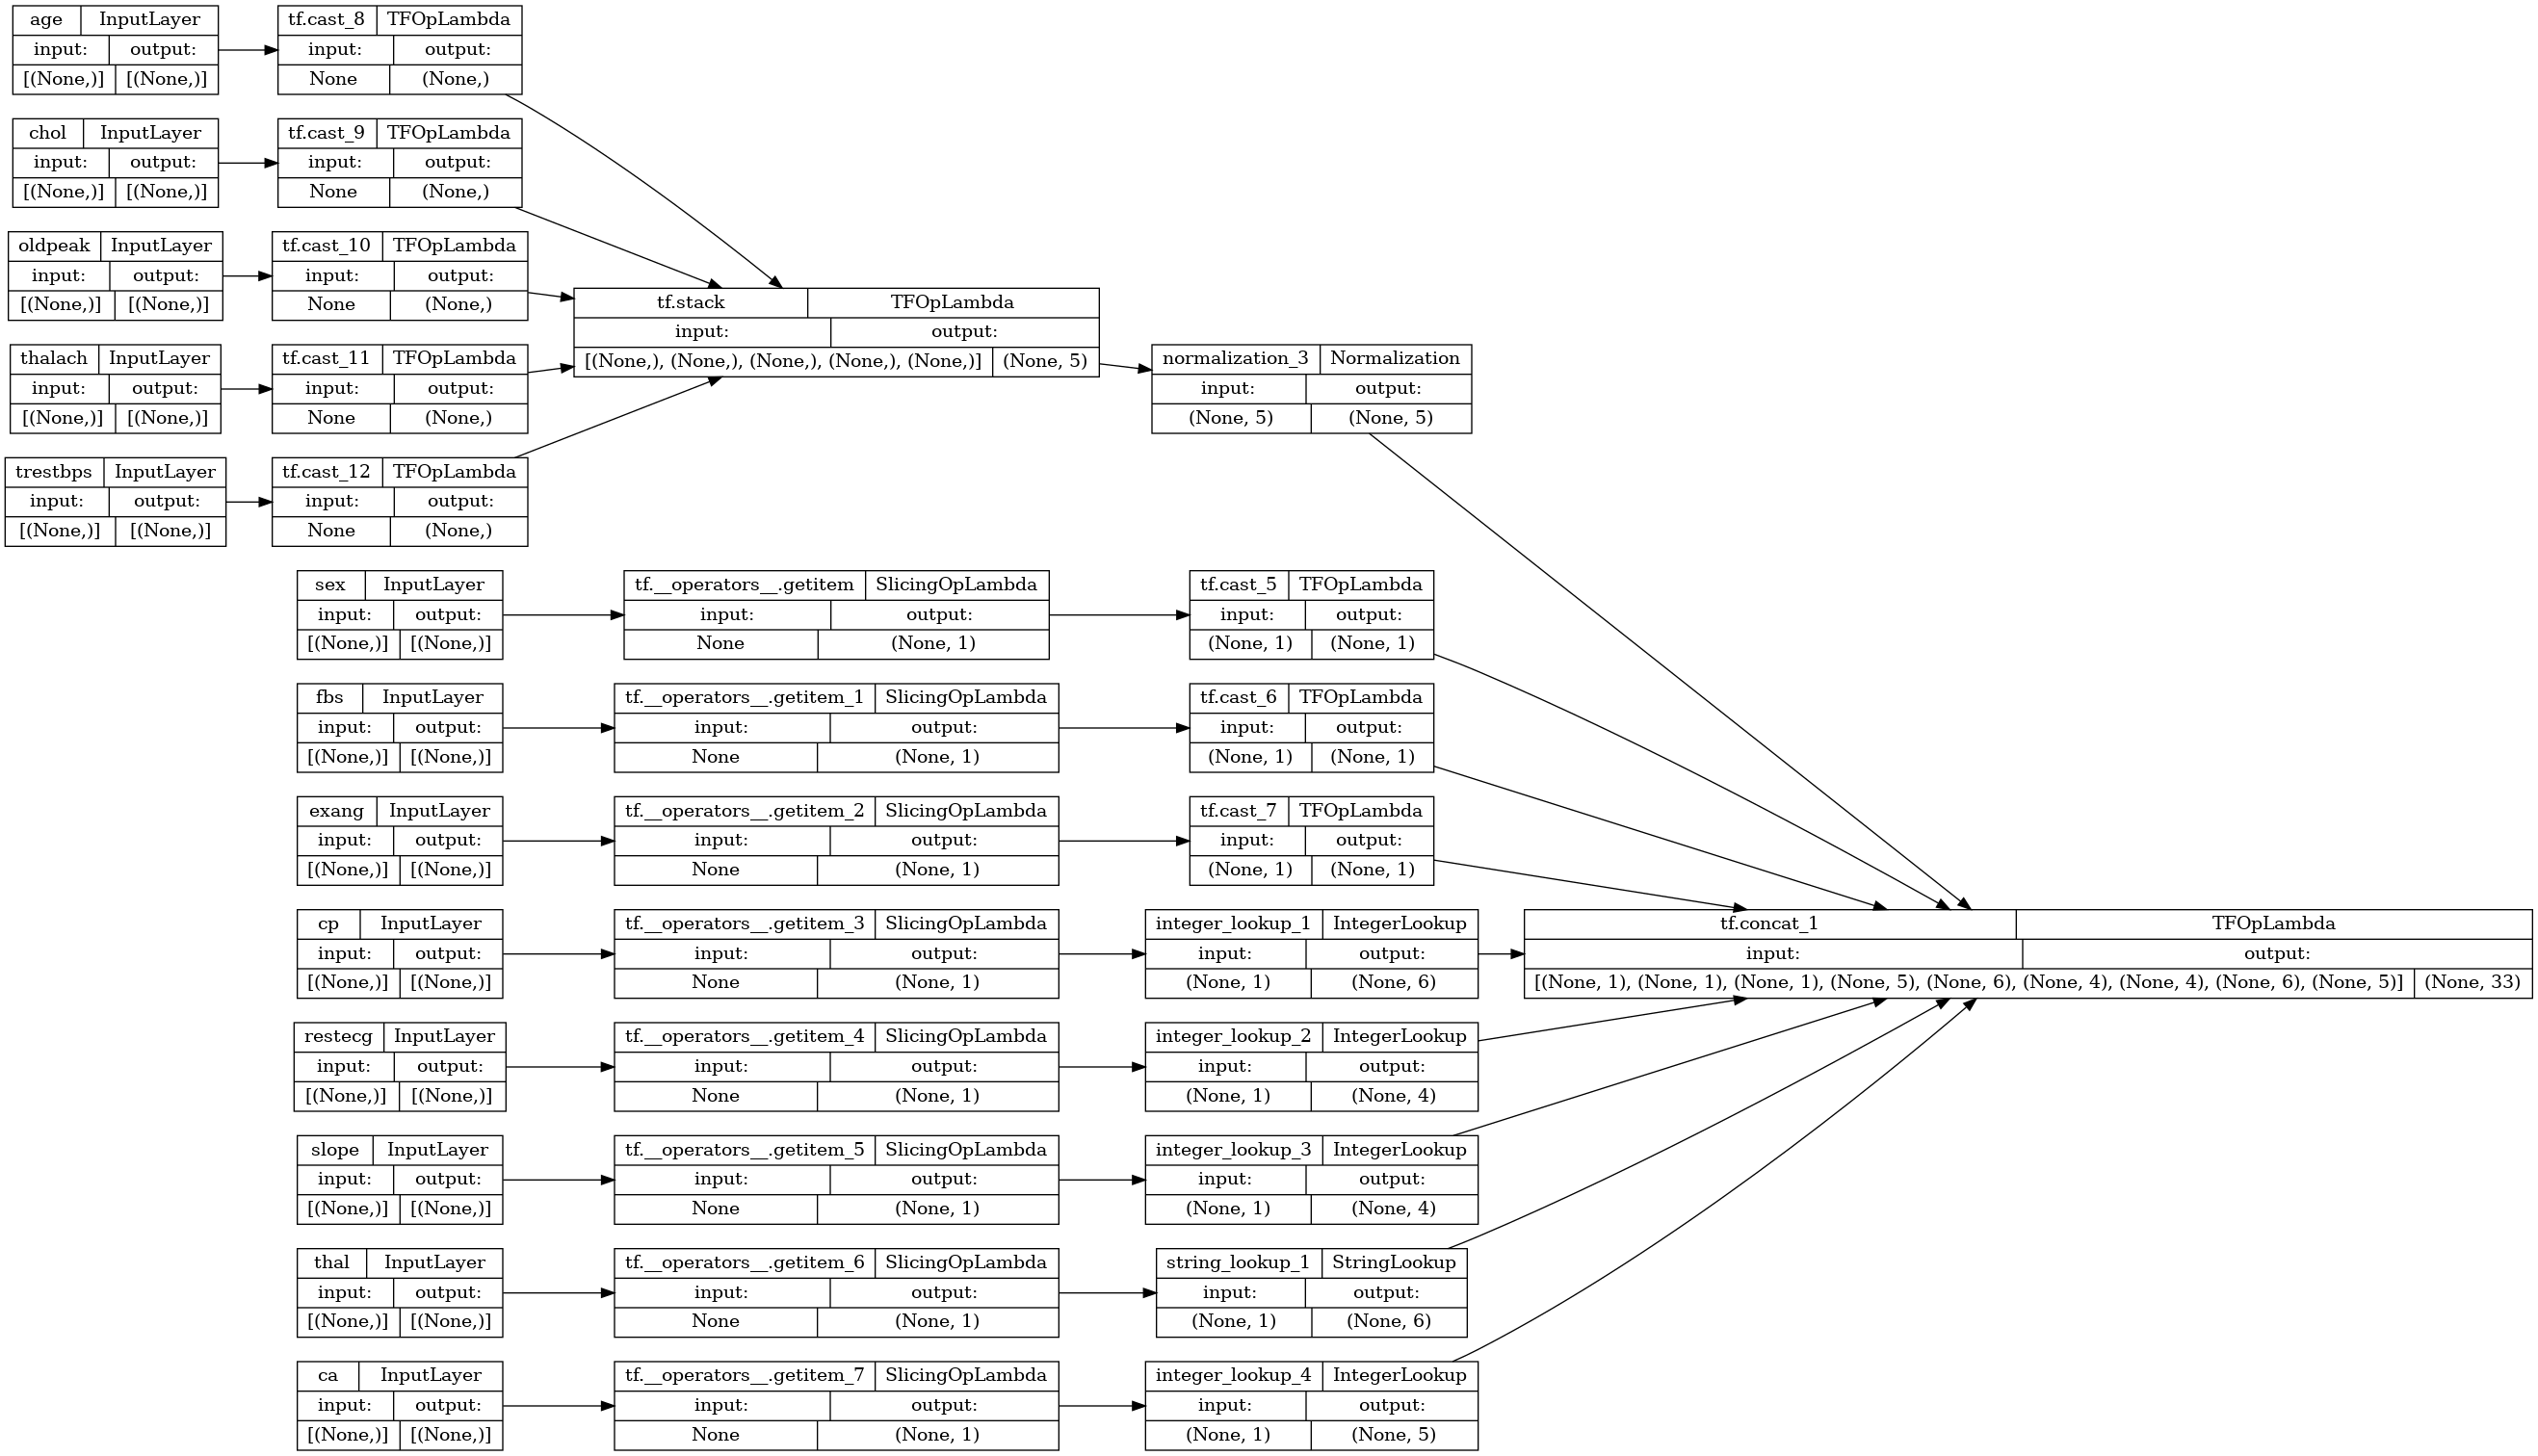

In [41]:
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

要测试预处理器，请使用 <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html" class="external">DataFrame.iloc</a> 访问器对 DataFrame 中的第一个样本进行切片。然后将它转换为字典并将字典传递给预处理器。结果为包含二元特征、归一化数值特征和独热分类特征的单个向量，按该顺序：

In [42]:
preprocessor(dict(df.iloc[:1]))

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[ 1.        ,  1.        ,  0.        ,  0.93383914, -0.26008663,
         1.0680453 ,  0.03480718,  0.74578077,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ]], dtype=float32)>

### 创建和训练模型

现在，构建模型主体。使用与上一个示例相同的配置：一对 `Dense` 修正线性层和一个 `Dense(1)` 输出层用于分类。

In [43]:
body = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

现在，使用 Keras 函数式 API 将这两部分结合在一起。

In [44]:
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

In [45]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'model_1')>

In [46]:
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential_3')>

In [47]:
model = tf.keras.Model(inputs, result)

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

此模型需要一个输入字典。将数据传递给它的最简单方式是将 DataFrame 转换为字典并将该字典作为 `x` 参数传递给 `Model.fit`：

In [48]:
history = model.fit(dict(df), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5


  1/152 [..............................] - ETA: 3:17 - loss: 0.4281 - accuracy: 1.0000

 12/152 [=>............................] - ETA: 0s - loss: 0.5509 - accuracy: 0.7917  

 24/152 [===>..........................] - ETA: 0s - loss: 0.5083 - accuracy: 0.7917

 36/152 [======>.......................] - ETA: 0s - loss: 0.5340 - accuracy: 0.7361

 48/152 [========>.....................] - ETA: 0s - loss: 0.5096 - accuracy: 0.7396

 60/152 [==========>...................] - ETA: 0s - loss: 0.5119 - accuracy: 0.7500

 72/152 [=============>................] - ETA: 0s - loss: 0.5070 - accuracy: 0.7361

 83/152 [===============>..............] - ETA: 0s - loss: 0.4955 - accuracy: 0.7410

 96/152 [=================>............] - ETA: 0s - loss: 0.5005 - accuracy: 0.7344

109/152 [====================>.........] - ETA: 0s - loss: 0.4945 - accuracy: 0.7431

121/152 [======================>.......] - ETA: 0s - loss: 0.4921 - accuracy: 0.7355

133/152 [=========================>....] - ETA: 0s - loss: 0.4997 - accuracy: 0.7331

145/152 [===========================>..] - ETA: 0s - loss: 0.4944 - accuracy: 0.7414

152/152 [==============================] - 2s 4ms/step - loss: 0.4911 - accuracy: 0.7327


Epoch 2/5


  1/152 [..............................] - ETA: 0s - loss: 0.2957 - accuracy: 1.0000

 13/152 [=>............................] - ETA: 0s - loss: 0.3745 - accuracy: 0.7692

 25/152 [===>..........................] - ETA: 0s - loss: 0.4129 - accuracy: 0.7800

 37/152 [======>.......................] - ETA: 0s - loss: 0.4018 - accuracy: 0.7838

 49/152 [========>.....................] - ETA: 0s - loss: 0.4052 - accuracy: 0.7755

 61/152 [===========>..................] - ETA: 0s - loss: 0.4116 - accuracy: 0.7787

 73/152 [=============>................] - ETA: 0s - loss: 0.4326 - accuracy: 0.7397

 86/152 [===============>..............] - ETA: 0s - loss: 0.4558 - accuracy: 0.7384

 98/152 [==================>...........] - ETA: 0s - loss: 0.4389 - accuracy: 0.7551

111/152 [====================>.........] - ETA: 0s - loss: 0.4205 - accuracy: 0.7703

123/152 [=======================>......] - ETA: 0s - loss: 0.4200 - accuracy: 0.7724

135/152 [=========================>....] - ETA: 0s - loss: 0.4062 - accuracy: 0.7778

147/152 [============================>.] - ETA: 0s - loss: 0.4039 - accuracy: 0.7755

152/152 [==============================] - 1s 4ms/step - loss: 0.4004 - accuracy: 0.7789


Epoch 3/5


  1/152 [..............................] - ETA: 0s - loss: 0.1546 - accuracy: 1.0000

 13/152 [=>............................] - ETA: 0s - loss: 0.3017 - accuracy: 0.9231

 25/152 [===>..........................] - ETA: 0s - loss: 0.3022 - accuracy: 0.9000

 37/152 [======>.......................] - ETA: 0s - loss: 0.3108 - accuracy: 0.8649

 49/152 [========>.....................] - ETA: 0s - loss: 0.2933 - accuracy: 0.8673

 61/152 [===========>..................] - ETA: 0s - loss: 0.2817 - accuracy: 0.8770

 73/152 [=============>................] - ETA: 0s - loss: 0.2984 - accuracy: 0.8493

 85/152 [===============>..............] - ETA: 0s - loss: 0.2999 - accuracy: 0.8412

 97/152 [==================>...........] - ETA: 0s - loss: 0.3274 - accuracy: 0.8299

110/152 [====================>.........] - ETA: 0s - loss: 0.3506 - accuracy: 0.8227

122/152 [=======================>......] - ETA: 0s - loss: 0.3495 - accuracy: 0.8279

134/152 [=========================>....] - ETA: 0s - loss: 0.3530 - accuracy: 0.8284

146/152 [===========================>..] - ETA: 0s - loss: 0.3480 - accuracy: 0.8288

152/152 [==============================] - 1s 4ms/step - loss: 0.3546 - accuracy: 0.8218


Epoch 4/5


  1/152 [..............................] - ETA: 0s - loss: 0.1873 - accuracy: 1.0000

 13/152 [=>............................] - ETA: 0s - loss: 0.4305 - accuracy: 0.7308

 25/152 [===>..........................] - ETA: 0s - loss: 0.4172 - accuracy: 0.7600

 37/152 [======>.......................] - ETA: 0s - loss: 0.3618 - accuracy: 0.8108

 49/152 [========>.....................] - ETA: 0s - loss: 0.3613 - accuracy: 0.8367

 61/152 [===========>..................] - ETA: 0s - loss: 0.3695 - accuracy: 0.8361

 73/152 [=============>................] - ETA: 0s - loss: 0.3602 - accuracy: 0.8425

 85/152 [===============>..............] - ETA: 0s - loss: 0.3296 - accuracy: 0.8529

 97/152 [==================>...........] - ETA: 0s - loss: 0.3271 - accuracy: 0.8454

109/152 [====================>.........] - ETA: 0s - loss: 0.3517 - accuracy: 0.8303

121/152 [======================>.......] - ETA: 0s - loss: 0.3306 - accuracy: 0.8430

133/152 [=========================>....] - ETA: 0s - loss: 0.3249 - accuracy: 0.8421

145/152 [===========================>..] - ETA: 0s - loss: 0.3243 - accuracy: 0.8414

152/152 [==============================] - 1s 4ms/step - loss: 0.3270 - accuracy: 0.8383


Epoch 5/5


  1/152 [..............................] - ETA: 0s - loss: 0.7382 - accuracy: 0.5000

 13/152 [=>............................] - ETA: 0s - loss: 0.3586 - accuracy: 0.8077

 25/152 [===>..........................] - ETA: 0s - loss: 0.2828 - accuracy: 0.8400

 37/152 [======>.......................] - ETA: 0s - loss: 0.2441 - accuracy: 0.8649

 49/152 [========>.....................] - ETA: 0s - loss: 0.2572 - accuracy: 0.8469

 61/152 [===========>..................] - ETA: 0s - loss: 0.2873 - accuracy: 0.8279

 73/152 [=============>................] - ETA: 0s - loss: 0.2904 - accuracy: 0.8356

 85/152 [===============>..............] - ETA: 0s - loss: 0.3007 - accuracy: 0.8294

 97/152 [==================>...........] - ETA: 0s - loss: 0.2946 - accuracy: 0.8299

109/152 [====================>.........] - ETA: 0s - loss: 0.2938 - accuracy: 0.8394

122/152 [=======================>......] - ETA: 0s - loss: 0.2907 - accuracy: 0.8484

134/152 [=========================>....] - ETA: 0s - loss: 0.2950 - accuracy: 0.8433

146/152 [===========================>..] - ETA: 0s - loss: 0.2949 - accuracy: 0.8425

152/152 [==============================] - 1s 4ms/step - loss: 0.3083 - accuracy: 0.8350


也可以使用 `tf.data`：

In [49]:
ds = tf.data.Dataset.from_tensor_slices((
    dict(df),
    target
))

ds = ds.batch(BATCH_SIZE)

In [50]:
import pprint

for x, y in ds.take(1):
  pprint.pprint(x)
  print()
  print(y)

{'age': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([63, 67])>,
 'ca': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 3])>,
 'chol': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([233, 286])>,
 'cp': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 4])>,
 'exang': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>,
 'fbs': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>,
 'oldpeak': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.3, 1.5])>,
 'restecg': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2])>,
 'sex': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1])>,
 'slope': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 2])>,
 'thal': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'fixed', b'normal'], dtype=object)>,
 'thalach': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([150, 108])>,
 'trestbps': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([145, 160])>}

tf.Tensor([0 1], shape=(2,), dtype=int64)


In [51]:
history = model.fit(ds, epochs=5)

Epoch 1/5


  1/152 [..............................] - ETA: 1:02 - loss: 0.3983 - accuracy: 1.0000

 12/152 [=>............................] - ETA: 0s - loss: 0.2682 - accuracy: 0.8333  

 24/152 [===>..........................] - ETA: 0s - loss: 0.2876 - accuracy: 0.8333

 37/152 [======>.......................] - ETA: 0s - loss: 0.2756 - accuracy: 0.8243

 49/152 [========>.....................] - ETA: 0s - loss: 0.2420 - accuracy: 0.8571

 61/152 [===========>..................] - ETA: 0s - loss: 0.2420 - accuracy: 0.8689

 73/152 [=============>................] - ETA: 0s - loss: 0.2728 - accuracy: 0.8425

 85/152 [===============>..............] - ETA: 0s - loss: 0.2553 - accuracy: 0.8471

 97/152 [==================>...........] - ETA: 0s - loss: 0.2731 - accuracy: 0.8351

109/152 [====================>.........] - ETA: 0s - loss: 0.2907 - accuracy: 0.8211

121/152 [======================>.......] - ETA: 0s - loss: 0.2817 - accuracy: 0.8306

133/152 [=========================>....] - ETA: 0s - loss: 0.2836 - accuracy: 0.8421

145/152 [===========================>..] - ETA: 0s - loss: 0.2859 - accuracy: 0.8414

152/152 [==============================] - 1s 4ms/step - loss: 0.2946 - accuracy: 0.8383


Epoch 2/5


  1/152 [..............................] - ETA: 0s - loss: 0.3869 - accuracy: 1.0000

 13/152 [=>............................] - ETA: 0s - loss: 0.2422 - accuracy: 0.8462

 25/152 [===>..........................] - ETA: 0s - loss: 0.2712 - accuracy: 0.8600

 37/152 [======>.......................] - ETA: 0s - loss: 0.2701 - accuracy: 0.8378

 49/152 [========>.....................] - ETA: 0s - loss: 0.2378 - accuracy: 0.8673

 61/152 [===========>..................] - ETA: 0s - loss: 0.2367 - accuracy: 0.8770

 73/152 [=============>................] - ETA: 0s - loss: 0.2651 - accuracy: 0.8493

 85/152 [===============>..............] - ETA: 0s - loss: 0.2469 - accuracy: 0.8529

 97/152 [==================>...........] - ETA: 0s - loss: 0.2638 - accuracy: 0.8402

109/152 [====================>.........] - ETA: 0s - loss: 0.2811 - accuracy: 0.8303

122/152 [=======================>......] - ETA: 0s - loss: 0.2721 - accuracy: 0.8402

135/152 [=========================>....] - ETA: 0s - loss: 0.2801 - accuracy: 0.8444

148/152 [============================>.] - ETA: 0s - loss: 0.2804 - accuracy: 0.8480

152/152 [==============================] - 1s 4ms/step - loss: 0.2832 - accuracy: 0.8515


Epoch 3/5


  1/152 [..............................] - ETA: 0s - loss: 0.3545 - accuracy: 1.0000

 13/152 [=>............................] - ETA: 0s - loss: 0.2318 - accuracy: 0.8846

 25/152 [===>..........................] - ETA: 0s - loss: 0.2636 - accuracy: 0.8800

 37/152 [======>.......................] - ETA: 0s - loss: 0.2643 - accuracy: 0.8514

 49/152 [========>.....................] - ETA: 0s - loss: 0.2329 - accuracy: 0.8673

 61/152 [===========>..................] - ETA: 0s - loss: 0.2315 - accuracy: 0.8770

 73/152 [=============>................] - ETA: 0s - loss: 0.2579 - accuracy: 0.8562

 85/152 [===============>..............] - ETA: 0s - loss: 0.2397 - accuracy: 0.8588

 98/152 [==================>...........] - ETA: 0s - loss: 0.2630 - accuracy: 0.8418

110/152 [====================>.........] - ETA: 0s - loss: 0.2716 - accuracy: 0.8409

122/152 [=======================>......] - ETA: 0s - loss: 0.2636 - accuracy: 0.8484

134/152 [=========================>....] - ETA: 0s - loss: 0.2711 - accuracy: 0.8507

146/152 [===========================>..] - ETA: 0s - loss: 0.2656 - accuracy: 0.8562

152/152 [==============================] - 1s 4ms/step - loss: 0.2742 - accuracy: 0.8548


Epoch 4/5


  1/152 [..............................] - ETA: 0s - loss: 0.3332 - accuracy: 1.0000

 13/152 [=>............................] - ETA: 0s - loss: 0.2235 - accuracy: 0.8846

 25/152 [===>..........................] - ETA: 0s - loss: 0.2565 - accuracy: 0.8800

 37/152 [======>.......................] - ETA: 0s - loss: 0.2582 - accuracy: 0.8514

 49/152 [========>.....................] - ETA: 0s - loss: 0.2274 - accuracy: 0.8673

 61/152 [===========>..................] - ETA: 0s - loss: 0.2253 - accuracy: 0.8770

 73/152 [=============>................] - ETA: 0s - loss: 0.2507 - accuracy: 0.8630

 85/152 [===============>..............] - ETA: 0s - loss: 0.2329 - accuracy: 0.8647

 97/152 [==================>...........] - ETA: 0s - loss: 0.2488 - accuracy: 0.8505

109/152 [====================>.........] - ETA: 0s - loss: 0.2655 - accuracy: 0.8394

122/152 [=======================>......] - ETA: 0s - loss: 0.2560 - accuracy: 0.8484

135/152 [=========================>....] - ETA: 0s - loss: 0.2633 - accuracy: 0.8519

147/152 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.8537

152/152 [==============================] - 1s 4ms/step - loss: 0.2663 - accuracy: 0.8548


Epoch 5/5


  1/152 [..............................] - ETA: 0s - loss: 0.3224 - accuracy: 1.0000

 13/152 [=>............................] - ETA: 0s - loss: 0.2181 - accuracy: 0.9231

 25/152 [===>..........................] - ETA: 0s - loss: 0.2519 - accuracy: 0.9000

 37/152 [======>.......................] - ETA: 0s - loss: 0.2554 - accuracy: 0.8649

 48/152 [========>.....................] - ETA: 0s - loss: 0.2302 - accuracy: 0.8750

 60/152 [==========>...................] - ETA: 0s - loss: 0.2252 - accuracy: 0.8833

 72/152 [=============>................] - ETA: 0s - loss: 0.2500 - accuracy: 0.8681

 84/152 [===============>..............] - ETA: 0s - loss: 0.2315 - accuracy: 0.8750

 96/152 [=================>............] - ETA: 0s - loss: 0.2297 - accuracy: 0.8698

108/152 [====================>.........] - ETA: 0s - loss: 0.2565 - accuracy: 0.8565

120/152 [======================>.......] - ETA: 0s - loss: 0.2503 - accuracy: 0.8625

132/152 [=========================>....] - ETA: 0s - loss: 0.2425 - accuracy: 0.8750

144/152 [===========================>..] - ETA: 0s - loss: 0.2532 - accuracy: 0.8681

152/152 [==============================] - 1s 4ms/step - loss: 0.2596 - accuracy: 0.8680
